In [1]:
# Libraries

import os
import cv2
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import pickle 

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import dotenv

2024-11-20 13:30:10.177143: E external/local_xla/xla/stream_executor/plugin_registry.cc:93] Invalid plugin kind specified: DNN


### Hyperparameters

In [2]:
# Load environment variables
dotenv.load_dotenv()

EPOCHS = 50
BATCH_SIZE = 128 
IMAGE_SIZE = 224  # ResNet50 input size

### Import Dataset

In [3]:
training_dataset_path = os.path.join(os.environ['DATASET_PATH'], 'Training')

class_labels = {'glioma': 0, 'meningioma': 1, 'pituitary': 2, 'notumor': 3}
image_folders = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_labels_reverse = {v: k for k, v in class_labels.items()}

In [4]:
# Initialize lists to store images and labels for the training dataset
images = []
labels = []

# Loop over the folders in the Training dataset to load images and their labels
for folder in image_folders:
    folder_path = os.path.join(training_dataset_path, folder)
    
    # List image files in the folder
    image_files = sorted(os.listdir(folder_path))

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)

        # Read the image (grayscale because MRI data)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Resize image if necessary (standardize image size)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Resize to 224x224 for ResNet50

        # Append image and label (use list append method)
        images.append(img)
        labels.append(class_labels[folder])  # Assign label based on folder name

# Convert lists to numpy arrays after appending all images and labels
images = np.array(images)
labels = np.array(labels)

# Normalize the images (optional but helps with training)
images = images.astype('float32') / 255.0

# Convert images to 3 channels (grayscale to RGB) for ResNet50
X_rgb = np.repeat(images.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1), 3, axis=-1)

# Split the dataset into training and validation sets (80% for training, 20% for validation)
X_train, X_val, y_train, y_val = train_test_split(X_rgb, labels, test_size=0.2, random_state=42)

# Data augmentation to improve model generalization
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load pre-trained ResNet50 model (without the top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Unfreeze the base model layers to allow fine-tuning
base_model.trainable = True

In [5]:
# Add custom classifier layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  # Increased the number of neurons
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)  # 4 classes

# Create the full model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model with a learning rate scheduler
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)
model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model"


__________________________________________________________________________________________________


 Layer (type)                Output Shape                 Param #   Connected to                  


 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            


 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             


 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           


 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          


 on)                                                                                              


 conv1_relu (Activation)     (None, 112, 112, 64)         0         ['conv1_bn[0][0]']            


 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_relu[0][0]']          


 pool1_pool (MaxPooling2D)   (None, 56, 56, 64)           0         ['pool1_pad[0][0]']           


 conv2_block1_1_conv (Conv2  (None, 56, 56, 64)           4160      ['pool1_pool[0][0]']          


 D)                                                                                               


 conv2_block1_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block1_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv2_block1_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block1_1_bn[0][0]']   


 ation)                                                                                           


 conv2_block1_2_conv (Conv2  (None, 56, 56, 64)           36928     ['conv2_block1_1_relu[0][0]'] 


 D)                                                                                               


 conv2_block1_2_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block1_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv2_block1_2_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block1_2_bn[0][0]']   


 ation)                                                                                           


 conv2_block1_0_conv (Conv2  (None, 56, 56, 256)          16640     ['pool1_pool[0][0]']          


 D)                                                                                               


 conv2_block1_3_conv (Conv2  (None, 56, 56, 256)          16640     ['conv2_block1_2_relu[0][0]'] 


 D)                                                                                               


 conv2_block1_0_bn (BatchNo  (None, 56, 56, 256)          1024      ['conv2_block1_0_conv[0][0]'] 


 rmalization)                                                                                     


 conv2_block1_3_bn (BatchNo  (None, 56, 56, 256)          1024      ['conv2_block1_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv2_block1_add (Add)      (None, 56, 56, 256)          0         ['conv2_block1_0_bn[0][0]',   


                                                                     'conv2_block1_3_bn[0][0]']   


 conv2_block1_out (Activati  (None, 56, 56, 256)          0         ['conv2_block1_add[0][0]']    


 on)                                                                                              


 conv2_block2_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block1_out[0][0]']    


 D)                                                                                               


 conv2_block2_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block2_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv2_block2_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block2_1_bn[0][0]']   


 ation)                                                                                           


 conv2_block2_2_conv (Conv2  (None, 56, 56, 64)           36928     ['conv2_block2_1_relu[0][0]'] 


 D)                                                                                               


 conv2_block2_2_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block2_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv2_block2_2_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block2_2_bn[0][0]']   


 ation)                                                                                           


 conv2_block2_3_conv (Conv2  (None, 56, 56, 256)          16640     ['conv2_block2_2_relu[0][0]'] 


 D)                                                                                               


 conv2_block2_3_bn (BatchNo  (None, 56, 56, 256)          1024      ['conv2_block2_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv2_block2_add (Add)      (None, 56, 56, 256)          0         ['conv2_block1_out[0][0]',    


                                                                     'conv2_block2_3_bn[0][0]']   


 conv2_block2_out (Activati  (None, 56, 56, 256)          0         ['conv2_block2_add[0][0]']    


 on)                                                                                              


 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    


 D)                                                                                               


 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   


 ation)                                                                                           


 conv2_block3_2_conv (Conv2  (None, 56, 56, 64)           36928     ['conv2_block3_1_relu[0][0]'] 


 D)                                                                                               


 conv2_block3_2_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv2_block3_2_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_2_bn[0][0]']   


 ation)                                                                                           


 conv2_block3_3_conv (Conv2  (None, 56, 56, 256)          16640     ['conv2_block3_2_relu[0][0]'] 


 D)                                                                                               


 conv2_block3_3_bn (BatchNo  (None, 56, 56, 256)          1024      ['conv2_block3_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv2_block3_add (Add)      (None, 56, 56, 256)          0         ['conv2_block2_out[0][0]',    


                                                                     'conv2_block3_3_bn[0][0]']   


 conv2_block3_out (Activati  (None, 56, 56, 256)          0         ['conv2_block3_add[0][0]']    


 on)                                                                                              


 conv3_block1_1_conv (Conv2  (None, 28, 28, 128)          32896     ['conv2_block3_out[0][0]']    


 D)                                                                                               


 conv3_block1_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block1_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block1_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block1_1_bn[0][0]']   


 ation)                                                                                           


 conv3_block1_2_conv (Conv2  (None, 28, 28, 128)          147584    ['conv3_block1_1_relu[0][0]'] 


 D)                                                                                               


 conv3_block1_2_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block1_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block1_2_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block1_2_bn[0][0]']   


 ation)                                                                                           


 conv3_block1_0_conv (Conv2  (None, 28, 28, 512)          131584    ['conv2_block3_out[0][0]']    


 D)                                                                                               


 conv3_block1_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block1_2_relu[0][0]'] 


 D)                                                                                               


 conv3_block1_0_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block1_0_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block1_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block1_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block1_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_0_bn[0][0]',   


                                                                     'conv3_block1_3_bn[0][0]']   


 conv3_block1_out (Activati  (None, 28, 28, 512)          0         ['conv3_block1_add[0][0]']    


 on)                                                                                              


 conv3_block2_1_conv (Conv2  (None, 28, 28, 128)          65664     ['conv3_block1_out[0][0]']    


 D)                                                                                               


 conv3_block2_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block2_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block2_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block2_1_bn[0][0]']   


 ation)                                                                                           


 conv3_block2_2_conv (Conv2  (None, 28, 28, 128)          147584    ['conv3_block2_1_relu[0][0]'] 


 D)                                                                                               


 conv3_block2_2_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block2_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block2_2_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block2_2_bn[0][0]']   


 ation)                                                                                           


 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 


 D)                                                                                               


 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    


                                                                     'conv3_block2_3_bn[0][0]']   


 conv3_block2_out (Activati  (None, 28, 28, 512)          0         ['conv3_block2_add[0][0]']    


 on)                                                                                              


 conv3_block3_1_conv (Conv2  (None, 28, 28, 128)          65664     ['conv3_block2_out[0][0]']    


 D)                                                                                               


 conv3_block3_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block3_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block3_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block3_1_bn[0][0]']   


 ation)                                                                                           


 conv3_block3_2_conv (Conv2  (None, 28, 28, 128)          147584    ['conv3_block3_1_relu[0][0]'] 


 D)                                                                                               


 conv3_block3_2_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block3_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block3_2_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block3_2_bn[0][0]']   


 ation)                                                                                           


 conv3_block3_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block3_2_relu[0][0]'] 


 D)                                                                                               


 conv3_block3_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block3_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block3_add (Add)      (None, 28, 28, 512)          0         ['conv3_block2_out[0][0]',    


                                                                     'conv3_block3_3_bn[0][0]']   


 conv3_block3_out (Activati  (None, 28, 28, 512)          0         ['conv3_block3_add[0][0]']    


 on)                                                                                              


 conv3_block4_1_conv (Conv2  (None, 28, 28, 128)          65664     ['conv3_block3_out[0][0]']    


 D)                                                                                               


 conv3_block4_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block4_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block4_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block4_1_bn[0][0]']   


 ation)                                                                                           


 conv3_block4_2_conv (Conv2  (None, 28, 28, 128)          147584    ['conv3_block4_1_relu[0][0]'] 


 D)                                                                                               


 conv3_block4_2_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block4_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block4_2_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block4_2_bn[0][0]']   


 ation)                                                                                           


 conv3_block4_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block4_2_relu[0][0]'] 


 D)                                                                                               


 conv3_block4_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block4_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block4_add (Add)      (None, 28, 28, 512)          0         ['conv3_block3_out[0][0]',    


                                                                     'conv3_block4_3_bn[0][0]']   


 conv3_block4_out (Activati  (None, 28, 28, 512)          0         ['conv3_block4_add[0][0]']    


 on)                                                                                              


 conv4_block1_1_conv (Conv2  (None, 14, 14, 256)          131328    ['conv3_block4_out[0][0]']    


 D)                                                                                               


 conv4_block1_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block1_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_1_bn[0][0]']   


 ation)                                                                                           


 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 


 D)                                                                                               


 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   


 ation)                                                                                           


 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    


 D)                                                                                               


 conv4_block1_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block1_2_relu[0][0]'] 


 D)                                                                                               


 conv4_block1_0_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block1_0_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block1_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block1_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block1_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block1_0_bn[0][0]',   


                                                                     'conv4_block1_3_bn[0][0]']   


 conv4_block1_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block1_add[0][0]']    


 on)                                                                                              


 conv4_block2_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block1_out[0][0]']    


 D)                                                                                               


 conv4_block2_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block2_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block2_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block2_1_bn[0][0]']   


 ation)                                                                                           


 conv4_block2_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block2_1_relu[0][0]'] 


 D)                                                                                               


 conv4_block2_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block2_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block2_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block2_2_bn[0][0]']   


 ation)                                                                                           


 conv4_block2_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block2_2_relu[0][0]'] 


 D)                                                                                               


 conv4_block2_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block2_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block2_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block1_out[0][0]',    


                                                                     'conv4_block2_3_bn[0][0]']   


 conv4_block2_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block2_add[0][0]']    


 on)                                                                                              


 conv4_block3_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block2_out[0][0]']    


 D)                                                                                               


 conv4_block3_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block3_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block3_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block3_1_bn[0][0]']   


 ation)                                                                                           


 conv4_block3_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block3_1_relu[0][0]'] 


 D)                                                                                               


 conv4_block3_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block3_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block3_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block3_2_bn[0][0]']   


 ation)                                                                                           


 conv4_block3_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block3_2_relu[0][0]'] 


 D)                                                                                               


 conv4_block3_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block3_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block3_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block2_out[0][0]',    


                                                                     'conv4_block3_3_bn[0][0]']   


 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    


 on)                                                                                              


 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    


 D)                                                                                               


 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block4_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block4_1_bn[0][0]']   


 ation)                                                                                           


 conv4_block4_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block4_1_relu[0][0]'] 


 D)                                                                                               


 conv4_block4_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block4_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block4_2_bn[0][0]']   


 ation)                                                                                           


 conv4_block4_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block4_2_relu[0][0]'] 


 D)                                                                                               


 conv4_block4_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block4_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block4_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block3_out[0][0]',    


                                                                     'conv4_block4_3_bn[0][0]']   


 conv4_block4_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block4_add[0][0]']    


 on)                                                                                              


 conv4_block5_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block4_out[0][0]']    


 D)                                                                                               


 conv4_block5_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block5_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block5_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block5_1_bn[0][0]']   


 ation)                                                                                           


 conv4_block5_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block5_1_relu[0][0]'] 


 D)                                                                                               


 conv4_block5_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block5_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block5_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block5_2_bn[0][0]']   


 ation)                                                                                           


 conv4_block5_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block5_2_relu[0][0]'] 


 D)                                                                                               


 conv4_block5_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block5_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block5_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block4_out[0][0]',    


                                                                     'conv4_block5_3_bn[0][0]']   


 conv4_block5_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block5_add[0][0]']    


 on)                                                                                              


 conv4_block6_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block5_out[0][0]']    


 D)                                                                                               


 conv4_block6_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block6_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block6_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block6_1_bn[0][0]']   


 ation)                                                                                           


 conv4_block6_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block6_1_relu[0][0]'] 


 D)                                                                                               


 conv4_block6_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block6_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block6_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block6_2_bn[0][0]']   


 ation)                                                                                           


 conv4_block6_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block6_2_relu[0][0]'] 


 D)                                                                                               


 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    


                                                                     'conv4_block6_3_bn[0][0]']   


 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    


 on)                                                                                              


 conv5_block1_1_conv (Conv2  (None, 7, 7, 512)            524800    ['conv4_block6_out[0][0]']    


 D)                                                                                               


 conv5_block1_1_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block1_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv5_block1_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block1_1_bn[0][0]']   


 ation)                                                                                           


 conv5_block1_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block1_1_relu[0][0]'] 


 D)                                                                                               


 conv5_block1_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block1_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv5_block1_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block1_2_bn[0][0]']   


 ation)                                                                                           


 conv5_block1_0_conv (Conv2  (None, 7, 7, 2048)           2099200   ['conv4_block6_out[0][0]']    


 D)                                                                                               


 conv5_block1_3_conv (Conv2  (None, 7, 7, 2048)           1050624   ['conv5_block1_2_relu[0][0]'] 


 D)                                                                                               


 conv5_block1_0_bn (BatchNo  (None, 7, 7, 2048)           8192      ['conv5_block1_0_conv[0][0]'] 


 rmalization)                                                                                     


 conv5_block1_3_bn (BatchNo  (None, 7, 7, 2048)           8192      ['conv5_block1_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv5_block1_add (Add)      (None, 7, 7, 2048)           0         ['conv5_block1_0_bn[0][0]',   


                                                                     'conv5_block1_3_bn[0][0]']   


 conv5_block1_out (Activati  (None, 7, 7, 2048)           0         ['conv5_block1_add[0][0]']    


 on)                                                                                              


 conv5_block2_1_conv (Conv2  (None, 7, 7, 512)            1049088   ['conv5_block1_out[0][0]']    


 D)                                                                                               


 conv5_block2_1_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block2_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv5_block2_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block2_1_bn[0][0]']   


 ation)                                                                                           


 conv5_block2_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block2_1_relu[0][0]'] 


 D)                                                                                               


 conv5_block2_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block2_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv5_block2_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block2_2_bn[0][0]']   


 ation)                                                                                           


 conv5_block2_3_conv (Conv2  (None, 7, 7, 2048)           1050624   ['conv5_block2_2_relu[0][0]'] 


 D)                                                                                               


 conv5_block2_3_bn (BatchNo  (None, 7, 7, 2048)           8192      ['conv5_block2_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv5_block2_add (Add)      (None, 7, 7, 2048)           0         ['conv5_block1_out[0][0]',    


                                                                     'conv5_block2_3_bn[0][0]']   


 conv5_block2_out (Activati  (None, 7, 7, 2048)           0         ['conv5_block2_add[0][0]']    


 on)                                                                                              


 conv5_block3_1_conv (Conv2  (None, 7, 7, 512)            1049088   ['conv5_block2_out[0][0]']    


 D)                                                                                               


 conv5_block3_1_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   


 ation)                                                                                           


 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 


 D)                                                                                               


 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   


 ation)                                                                                           


 conv5_block3_3_conv (Conv2  (None, 7, 7, 2048)           1050624   ['conv5_block3_2_relu[0][0]'] 


 D)                                                                                               


 conv5_block3_3_bn (BatchNo  (None, 7, 7, 2048)           8192      ['conv5_block3_3_conv[0][0]'] 


 rmalization)                                                                                     


 conv5_block3_add (Add)      (None, 7, 7, 2048)           0         ['conv5_block2_out[0][0]',    


                                                                     'conv5_block3_3_bn[0][0]']   


 conv5_block3_out (Activati  (None, 7, 7, 2048)           0         ['conv5_block3_add[0][0]']    


 on)                                                                                              


 flatten (Flatten)           (None, 100352)               0         ['conv5_block3_out[0][0]']    


 dense (Dense)               (None, 1024)                 1027614   ['flatten[0][0]']             


                                                          72                                      


 dropout (Dropout)           (None, 1024)                 0         ['dense[0][0]']               


 dense_1 (Dense)             (None, 512)                  524800    ['dropout[0][0]']             


 dropout_1 (Dropout)         (None, 512)                  0         ['dense_1[0][0]']             


 dense_2 (Dense)             (None, 4)                    2052      ['dropout_1[0][0]']           


Total params: 126876036 (483.99 MB)


Trainable params: 126822916 (483.79 MB)


Non-trainable params: 53120 (207.50 KB)


__________________________________________________________________________________________________


In [6]:
# Train the model using the training data
datagen.fit(X_train)
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val),
                    steps_per_epoch=len(X_train) // BATCH_SIZE)

Epoch 1/50


I0000 00:00:1732127429.654774   37103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 1/35 [..............................] - ETA: 9:29 - loss: 3.3923 - accuracy: 0.2734

 2/35 [>.............................] - ETA: 38s - loss: 3.6214 - accuracy: 0.3203 

 3/35 [=>............................] - ETA: 39s - loss: 3.4864 - accuracy: 0.3385

 4/35 [==>...........................] - ETA: 37s - loss: 3.3611 - accuracy: 0.3633

 5/35 [===>..........................] - ETA: 35s - loss: 3.2476 - accuracy: 0.4016

 6/35 [====>.........................] - ETA: 34s - loss: 3.0323 - accuracy: 0.4336

 7/35 [=====>........................] - ETA: 33s - loss: 2.9593 - accuracy: 0.4487

 8/35 [=====>........................] - ETA: 32s - loss: 2.8017 - accuracy: 0.4746

 9/35 [======>.......................] - ETA: 31s - loss: 2.7051 - accuracy: 0.4974

10/35 [=======>......................] - ETA: 29s - loss: 2.5774 - accuracy: 0.5172

11/35 [========>.....................] - ETA: 28s - loss: 2.4870 - accuracy: 0.5298

12/35 [=========>....................] - ETA: 27s - loss: 2.4065 - accuracy: 0.5417

13/35 [==========>...................] - ETA: 26s - loss: 2.3043 - accuracy: 0.5571

14/35 [===========>..................] - ETA: 25s - loss: 2.2322 - accuracy: 0.5709

15/35 [===========>..................] - ETA: 23s - loss: 2.1373 - accuracy: 0.5844

16/35 [============>.................] - ETA: 22s - loss: 2.0891 - accuracy: 0.5962

17/35 [=============>................] - ETA: 21s - loss: 2.0409 - accuracy: 0.6066

18/35 [==============>...............] - ETA: 20s - loss: 2.0056 - accuracy: 0.6102

19/35 [===============>..............] - ETA: 19s - loss: 1.9584 - accuracy: 0.6184

20/35 [================>.............] - ETA: 17s - loss: 1.9088 - accuracy: 0.6248

21/35 [=================>............] - ETA: 16s - loss: 1.8719 - accuracy: 0.6327

22/35 [=================>............] - ETA: 15s - loss: 1.8383 - accuracy: 0.6367

23/35 [==================>...........] - ETA: 14s - loss: 1.7868 - accuracy: 0.6458

24/35 [===================>..........] - ETA: 12s - loss: 1.7489 - accuracy: 0.6525

25/35 [====================>.........] - ETA: 11s - loss: 1.7029 - accuracy: 0.6599

26/35 [=====================>........] - ETA: 10s - loss: 1.6652 - accuracy: 0.6659

27/35 [======================>.......] - ETA: 9s - loss: 1.6401 - accuracy: 0.6696 

28/35 [=======================>......] - ETA: 8s - loss: 1.6089 - accuracy: 0.6748

29/35 [=======================>......] - ETA: 7s - loss: 1.5787 - accuracy: 0.6801

30/35 [========================>.....] - ETA: 5s - loss: 1.5679 - accuracy: 0.6832

31/35 [=========================>....] - ETA: 4s - loss: 1.5422 - accuracy: 0.6885

32/35 [==========================>...] - ETA: 3s - loss: 1.5102 - accuracy: 0.6934

33/35 [===========================>..] - ETA: 2s - loss: 1.4865 - accuracy: 0.6970

34/35 [============================>.] - ETA: 1s - loss: 1.4601 - accuracy: 0.7011

35/35 [==============================] - ETA: 0s - loss: 1.4402 - accuracy: 0.7052

35/35 [==============================] - 63s 1s/step - loss: 1.4402 - accuracy: 0.7052 - val_loss: 1.8132 - val_accuracy: 0.1225


Epoch 2/50


 1/35 [..............................] - ETA: 1:00 - loss: 0.4669 - accuracy: 0.8906

 2/35 [>.............................] - ETA: 37s - loss: 0.4866 - accuracy: 0.8594 

 3/35 [=>............................] - ETA: 38s - loss: 0.4840 - accuracy: 0.8594

 4/35 [==>...........................] - ETA: 36s - loss: 0.4497 - accuracy: 0.8711

 5/35 [===>..........................] - ETA: 35s - loss: 0.4594 - accuracy: 0.8625

 6/35 [====>.........................] - ETA: 34s - loss: 0.4613 - accuracy: 0.8646

 7/35 [=====>........................] - ETA: 32s - loss: 0.4860 - accuracy: 0.8605

 8/35 [=====>........................] - ETA: 31s - loss: 0.5081 - accuracy: 0.8564

 9/35 [======>.......................] - ETA: 30s - loss: 0.5028 - accuracy: 0.8524

10/35 [=======>......................] - ETA: 29s - loss: 0.4885 - accuracy: 0.8523

11/35 [========>.....................] - ETA: 28s - loss: 0.4666 - accuracy: 0.8587

12/35 [=========>....................] - ETA: 27s - loss: 0.4537 - accuracy: 0.8620

13/35 [==========>...................] - ETA: 25s - loss: 0.4496 - accuracy: 0.8630

14/35 [===========>..................] - ETA: 24s - loss: 0.4493 - accuracy: 0.8650

15/35 [===========>..................] - ETA: 23s - loss: 0.4477 - accuracy: 0.8661

16/35 [============>.................] - ETA: 22s - loss: 0.4747 - accuracy: 0.8638

17/35 [=============>................] - ETA: 21s - loss: 0.4742 - accuracy: 0.8640

18/35 [==============>...............] - ETA: 20s - loss: 0.4634 - accuracy: 0.8668

19/35 [===============>..............] - ETA: 18s - loss: 0.4734 - accuracy: 0.8672

20/35 [================>.............] - ETA: 17s - loss: 0.4783 - accuracy: 0.8664

21/35 [=================>............] - ETA: 16s - loss: 0.4701 - accuracy: 0.8687

22/35 [=================>............] - ETA: 15s - loss: 0.4662 - accuracy: 0.8704

23/35 [==================>...........] - ETA: 14s - loss: 0.4639 - accuracy: 0.8699

24/35 [===================>..........] - ETA: 12s - loss: 0.4617 - accuracy: 0.8695

25/35 [====================>.........] - ETA: 11s - loss: 0.4595 - accuracy: 0.8681

26/35 [=====================>........] - ETA: 10s - loss: 0.4550 - accuracy: 0.8683

27/35 [======================>.......] - ETA: 9s - loss: 0.4476 - accuracy: 0.8698 

28/35 [=======================>......] - ETA: 8s - loss: 0.4409 - accuracy: 0.8708

29/35 [=======================>......] - ETA: 7s - loss: 0.4361 - accuracy: 0.8710

30/35 [========================>.....] - ETA: 5s - loss: 0.4334 - accuracy: 0.8721

31/35 [=========================>....] - ETA: 4s - loss: 0.4328 - accuracy: 0.8712

32/35 [==========================>...] - ETA: 3s - loss: 0.4286 - accuracy: 0.8721

33/35 [===========================>..] - ETA: 2s - loss: 0.4283 - accuracy: 0.8731

34/35 [============================>.] - ETA: 1s - loss: 0.4242 - accuracy: 0.8746

35/35 [==============================] - ETA: 0s - loss: 0.4187 - accuracy: 0.8766

35/35 [==============================] - 45s 1s/step - loss: 0.4187 - accuracy: 0.8766 - val_loss: 3.5251 - val_accuracy: 0.2546


Epoch 3/50


 1/35 [..............................] - ETA: 59s - loss: 0.3527 - accuracy: 0.9062

 2/35 [>.............................] - ETA: 38s - loss: 0.2663 - accuracy: 0.9141

 3/35 [=>............................] - ETA: 39s - loss: 0.2960 - accuracy: 0.9036

 4/35 [==>...........................] - ETA: 37s - loss: 0.2711 - accuracy: 0.9082

 5/35 [===>..........................] - ETA: 35s - loss: 0.2729 - accuracy: 0.9062

 6/35 [====>.........................] - ETA: 35s - loss: 0.2815 - accuracy: 0.9062

 7/35 [=====>........................] - ETA: 33s - loss: 0.2806 - accuracy: 0.9107

 8/35 [=====>........................] - ETA: 32s - loss: 0.2665 - accuracy: 0.9121

 9/35 [======>.......................] - ETA: 30s - loss: 0.2853 - accuracy: 0.9097

10/35 [=======>......................] - ETA: 29s - loss: 0.2915 - accuracy: 0.9070

11/35 [========>.....................] - ETA: 28s - loss: 0.3003 - accuracy: 0.9070

12/35 [=========>....................] - ETA: 27s - loss: 0.2962 - accuracy: 0.9095

13/35 [==========>...................] - ETA: 25s - loss: 0.2932 - accuracy: 0.9095

14/35 [===========>..................] - ETA: 24s - loss: 0.3075 - accuracy: 0.9064

15/35 [===========>..................] - ETA: 23s - loss: 0.3081 - accuracy: 0.9043

16/35 [============>.................] - ETA: 22s - loss: 0.2997 - accuracy: 0.9069

17/35 [=============>................] - ETA: 20s - loss: 0.2973 - accuracy: 0.9055

18/35 [==============>...............] - ETA: 19s - loss: 0.2889 - accuracy: 0.9073

19/35 [===============>..............] - ETA: 18s - loss: 0.2869 - accuracy: 0.9085

20/35 [================>.............] - ETA: 17s - loss: 0.2814 - accuracy: 0.9096

21/35 [=================>............] - ETA: 16s - loss: 0.2745 - accuracy: 0.9105

22/35 [=================>............] - ETA: 15s - loss: 0.2716 - accuracy: 0.9114

23/35 [==================>...........] - ETA: 14s - loss: 0.2683 - accuracy: 0.9115

24/35 [===================>..........] - ETA: 12s - loss: 0.2613 - accuracy: 0.9139

25/35 [====================>.........] - ETA: 11s - loss: 0.2597 - accuracy: 0.9143

26/35 [=====================>........] - ETA: 10s - loss: 0.2578 - accuracy: 0.9149

27/35 [======================>.......] - ETA: 9s - loss: 0.2584 - accuracy: 0.9148 

28/35 [=======================>......] - ETA: 8s - loss: 0.2560 - accuracy: 0.9148

29/35 [=======================>......] - ETA: 7s - loss: 0.2597 - accuracy: 0.9153

30/35 [========================>.....] - ETA: 5s - loss: 0.2548 - accuracy: 0.9166

31/35 [=========================>....] - ETA: 4s - loss: 0.2516 - accuracy: 0.9175

32/35 [==========================>...] - ETA: 3s - loss: 0.2502 - accuracy: 0.9177

33/35 [===========================>..] - ETA: 2s - loss: 0.2533 - accuracy: 0.9188

34/35 [============================>.] - ETA: 1s - loss: 0.2544 - accuracy: 0.9179

35/35 [==============================] - ETA: 0s - loss: 0.2541 - accuracy: 0.9176

35/35 [==============================] - 46s 1s/step - loss: 0.2541 - accuracy: 0.9176 - val_loss: 2.8585 - val_accuracy: 0.2546


Epoch 4/50


 1/35 [..............................] - ETA: 1:03 - loss: 0.2132 - accuracy: 0.9297

 2/35 [>.............................] - ETA: 37s - loss: 0.1877 - accuracy: 0.9375 

 3/35 [=>............................] - ETA: 38s - loss: 0.1883 - accuracy: 0.9375

 4/35 [==>...........................] - ETA: 36s - loss: 0.1569 - accuracy: 0.9473

 5/35 [===>..........................] - ETA: 35s - loss: 0.1680 - accuracy: 0.9375

 6/35 [====>.........................] - ETA: 32s - loss: 0.1960 - accuracy: 0.9314

 7/35 [=====>........................] - ETA: 31s - loss: 0.1857 - accuracy: 0.9335

 8/35 [=====>........................] - ETA: 30s - loss: 0.1881 - accuracy: 0.9320

 9/35 [======>.......................] - ETA: 29s - loss: 0.1874 - accuracy: 0.9326

10/35 [=======>......................] - ETA: 28s - loss: 0.1875 - accuracy: 0.9331

11/35 [========>.....................] - ETA: 27s - loss: 0.1787 - accuracy: 0.9364

12/35 [=========>....................] - ETA: 26s - loss: 0.1765 - accuracy: 0.9365

13/35 [==========>...................] - ETA: 25s - loss: 0.1775 - accuracy: 0.9360

14/35 [===========>..................] - ETA: 24s - loss: 0.1821 - accuracy: 0.9327

15/35 [===========>..................] - ETA: 23s - loss: 0.1863 - accuracy: 0.9309

16/35 [============>.................] - ETA: 22s - loss: 0.1851 - accuracy: 0.9318

17/35 [=============>................] - ETA: 20s - loss: 0.1921 - accuracy: 0.9307

18/35 [==============>...............] - ETA: 19s - loss: 0.1890 - accuracy: 0.9316

19/35 [===============>..............] - ETA: 18s - loss: 0.1884 - accuracy: 0.9315

20/35 [================>.............] - ETA: 17s - loss: 0.1852 - accuracy: 0.9326

21/35 [=================>............] - ETA: 16s - loss: 0.1856 - accuracy: 0.9324

22/35 [=================>............] - ETA: 15s - loss: 0.1885 - accuracy: 0.9316

23/35 [==================>...........] - ETA: 14s - loss: 0.1917 - accuracy: 0.9305

24/35 [===================>..........] - ETA: 12s - loss: 0.1916 - accuracy: 0.9308

25/35 [====================>.........] - ETA: 11s - loss: 0.1877 - accuracy: 0.9317

26/35 [=====================>........] - ETA: 10s - loss: 0.1851 - accuracy: 0.9322

27/35 [======================>.......] - ETA: 9s - loss: 0.1869 - accuracy: 0.9321 

28/35 [=======================>......] - ETA: 8s - loss: 0.1876 - accuracy: 0.9320

29/35 [=======================>......] - ETA: 7s - loss: 0.1856 - accuracy: 0.9333

30/35 [========================>.....] - ETA: 5s - loss: 0.1826 - accuracy: 0.9342

31/35 [=========================>....] - ETA: 4s - loss: 0.1831 - accuracy: 0.9333

32/35 [==========================>...] - ETA: 3s - loss: 0.1813 - accuracy: 0.9344

33/35 [===========================>..] - ETA: 2s - loss: 0.1786 - accuracy: 0.9357

34/35 [============================>.] - ETA: 1s - loss: 0.1786 - accuracy: 0.9365

35/35 [==============================] - ETA: 0s - loss: 0.1802 - accuracy: 0.9367

35/35 [==============================] - 46s 1s/step - loss: 0.1802 - accuracy: 0.9367 - val_loss: 3.2641 - val_accuracy: 0.2546


Epoch 5/50


 1/35 [..............................] - ETA: 59s - loss: 0.2423 - accuracy: 0.9375

 2/35 [>.............................] - ETA: 37s - loss: 0.1860 - accuracy: 0.9492

 3/35 [=>............................] - ETA: 38s - loss: 0.1629 - accuracy: 0.9479

 4/35 [==>...........................] - ETA: 36s - loss: 0.1895 - accuracy: 0.9434

 5/35 [===>..........................] - ETA: 34s - loss: 0.1668 - accuracy: 0.9516

 6/35 [====>.........................] - ETA: 34s - loss: 0.1824 - accuracy: 0.9440

 7/35 [=====>........................] - ETA: 33s - loss: 0.1652 - accuracy: 0.9475

 8/35 [=====>........................] - ETA: 32s - loss: 0.1689 - accuracy: 0.9443

 9/35 [======>.......................] - ETA: 30s - loss: 0.1622 - accuracy: 0.9470

10/35 [=======>......................] - ETA: 29s - loss: 0.1587 - accuracy: 0.9461

11/35 [========>.....................] - ETA: 28s - loss: 0.1647 - accuracy: 0.9453

12/35 [=========>....................] - ETA: 27s - loss: 0.1590 - accuracy: 0.9453

13/35 [==========>...................] - ETA: 26s - loss: 0.1631 - accuracy: 0.9405

14/35 [===========>..................] - ETA: 25s - loss: 0.1569 - accuracy: 0.9431

15/35 [===========>..................] - ETA: 23s - loss: 0.1514 - accuracy: 0.9438

16/35 [============>.................] - ETA: 22s - loss: 0.1569 - accuracy: 0.9424

17/35 [=============>................] - ETA: 21s - loss: 0.1534 - accuracy: 0.9430

18/35 [==============>...............] - ETA: 20s - loss: 0.1519 - accuracy: 0.9440

19/35 [===============>..............] - ETA: 19s - loss: 0.1507 - accuracy: 0.9449

20/35 [================>.............] - ETA: 17s - loss: 0.1468 - accuracy: 0.9469

21/35 [=================>............] - ETA: 16s - loss: 0.1449 - accuracy: 0.9479

22/35 [=================>............] - ETA: 15s - loss: 0.1476 - accuracy: 0.9478

23/35 [==================>...........] - ETA: 14s - loss: 0.1485 - accuracy: 0.9466

24/35 [===================>..........] - ETA: 12s - loss: 0.1488 - accuracy: 0.9459

25/35 [====================>.........] - ETA: 11s - loss: 0.1536 - accuracy: 0.9450

26/35 [=====================>........] - ETA: 10s - loss: 0.1513 - accuracy: 0.9456

27/35 [======================>.......] - ETA: 9s - loss: 0.1489 - accuracy: 0.9462 

28/35 [=======================>......] - ETA: 8s - loss: 0.1486 - accuracy: 0.9464

29/35 [=======================>......] - ETA: 7s - loss: 0.1471 - accuracy: 0.9472

30/35 [========================>.....] - ETA: 5s - loss: 0.1453 - accuracy: 0.9479

31/35 [=========================>....] - ETA: 4s - loss: 0.1440 - accuracy: 0.9478

32/35 [==========================>...] - ETA: 3s - loss: 0.1453 - accuracy: 0.9475

33/35 [===========================>..] - ETA: 2s - loss: 0.1457 - accuracy: 0.9477

34/35 [============================>.] - ETA: 1s - loss: 0.1446 - accuracy: 0.9478

35/35 [==============================] - ETA: 0s - loss: 0.1445 - accuracy: 0.9482

35/35 [==============================] - 46s 1s/step - loss: 0.1445 - accuracy: 0.9482 - val_loss: 2.8043 - val_accuracy: 0.2432


Epoch 6/50


 1/35 [..............................] - ETA: 59s - loss: 0.0901 - accuracy: 0.9766

 2/35 [>.............................] - ETA: 38s - loss: 0.1296 - accuracy: 0.9688

 3/35 [=>............................] - ETA: 38s - loss: 0.1282 - accuracy: 0.9661

 4/35 [==>...........................] - ETA: 36s - loss: 0.1070 - accuracy: 0.9727

 5/35 [===>..........................] - ETA: 35s - loss: 0.1223 - accuracy: 0.9688

 6/35 [====>.........................] - ETA: 34s - loss: 0.1210 - accuracy: 0.9661

 7/35 [=====>........................] - ETA: 33s - loss: 0.1180 - accuracy: 0.9654

 8/35 [=====>........................] - ETA: 31s - loss: 0.1247 - accuracy: 0.9639

 9/35 [======>.......................] - ETA: 30s - loss: 0.1225 - accuracy: 0.9627

10/35 [=======>......................] - ETA: 29s - loss: 0.1130 - accuracy: 0.9656

11/35 [========>.....................] - ETA: 28s - loss: 0.1116 - accuracy: 0.9652

12/35 [=========>....................] - ETA: 27s - loss: 0.1183 - accuracy: 0.9629

13/35 [==========>...................] - ETA: 25s - loss: 0.1172 - accuracy: 0.9627

14/35 [===========>..................] - ETA: 24s - loss: 0.1170 - accuracy: 0.9615

15/35 [===========>..................] - ETA: 23s - loss: 0.1246 - accuracy: 0.9620

16/35 [============>.................] - ETA: 22s - loss: 0.1322 - accuracy: 0.9619

17/35 [=============>................] - ETA: 21s - loss: 0.1342 - accuracy: 0.9605

18/35 [==============>...............] - ETA: 20s - loss: 0.1376 - accuracy: 0.9583

19/35 [===============>..............] - ETA: 18s - loss: 0.1334 - accuracy: 0.9593

20/35 [================>.............] - ETA: 17s - loss: 0.1381 - accuracy: 0.9578

21/35 [=================>............] - ETA: 16s - loss: 0.1376 - accuracy: 0.9587

22/35 [=================>............] - ETA: 15s - loss: 0.1428 - accuracy: 0.9563

23/35 [==================>...........] - ETA: 14s - loss: 0.1446 - accuracy: 0.9565

24/35 [===================>..........] - ETA: 13s - loss: 0.1436 - accuracy: 0.9580

25/35 [====================>.........] - ETA: 11s - loss: 0.1467 - accuracy: 0.9566

26/35 [=====================>........] - ETA: 10s - loss: 0.1452 - accuracy: 0.9564

27/35 [======================>.......] - ETA: 9s - loss: 0.1435 - accuracy: 0.9567 

28/35 [=======================>......] - ETA: 8s - loss: 0.1399 - accuracy: 0.9580

29/35 [=======================>......] - ETA: 7s - loss: 0.1382 - accuracy: 0.9581

30/35 [========================>.....] - ETA: 5s - loss: 0.1379 - accuracy: 0.9579

31/35 [=========================>....] - ETA: 4s - loss: 0.1374 - accuracy: 0.9575

32/35 [==========================>...] - ETA: 3s - loss: 0.1364 - accuracy: 0.9576

33/35 [===========================>..] - ETA: 2s - loss: 0.1356 - accuracy: 0.9572

34/35 [============================>.] - ETA: 1s - loss: 0.1371 - accuracy: 0.9571

35/35 [==============================] - ETA: 0s - loss: 0.1368 - accuracy: 0.9572

35/35 [==============================] - 46s 1s/step - loss: 0.1368 - accuracy: 0.9572 - val_loss: 2.8654 - val_accuracy: 0.2476


Epoch 7/50


 1/35 [..............................] - ETA: 1:00 - loss: 0.1056 - accuracy: 0.9688

 2/35 [>.............................] - ETA: 37s - loss: 0.0839 - accuracy: 0.9766 

 3/35 [=>............................] - ETA: 38s - loss: 0.1019 - accuracy: 0.9635

 4/35 [==>...........................] - ETA: 36s - loss: 0.1079 - accuracy: 0.9609

 5/35 [===>..........................] - ETA: 35s - loss: 0.1088 - accuracy: 0.9625

 6/35 [====>.........................] - ETA: 34s - loss: 0.0997 - accuracy: 0.9648

 7/35 [=====>........................] - ETA: 32s - loss: 0.1020 - accuracy: 0.9643

 8/35 [=====>........................] - ETA: 31s - loss: 0.1049 - accuracy: 0.9648

 9/35 [======>.......................] - ETA: 30s - loss: 0.1024 - accuracy: 0.9653

10/35 [=======>......................] - ETA: 29s - loss: 0.0952 - accuracy: 0.9672

11/35 [========>.....................] - ETA: 28s - loss: 0.0961 - accuracy: 0.9659

12/35 [=========>....................] - ETA: 27s - loss: 0.0939 - accuracy: 0.9674

13/35 [==========>...................] - ETA: 26s - loss: 0.0907 - accuracy: 0.9688

14/35 [===========>..................] - ETA: 24s - loss: 0.0932 - accuracy: 0.9663

15/35 [===========>..................] - ETA: 23s - loss: 0.0928 - accuracy: 0.9660

16/35 [============>.................] - ETA: 22s - loss: 0.0962 - accuracy: 0.9642

17/35 [=============>................] - ETA: 21s - loss: 0.0969 - accuracy: 0.9640

18/35 [==============>...............] - ETA: 19s - loss: 0.0954 - accuracy: 0.9642

19/35 [===============>..............] - ETA: 18s - loss: 0.0922 - accuracy: 0.9657

20/35 [================>.............] - ETA: 17s - loss: 0.0940 - accuracy: 0.9663

21/35 [=================>............] - ETA: 16s - loss: 0.0904 - accuracy: 0.9679

22/35 [=================>............] - ETA: 15s - loss: 0.0909 - accuracy: 0.9672

23/35 [==================>...........] - ETA: 14s - loss: 0.0940 - accuracy: 0.9659

24/35 [===================>..........] - ETA: 12s - loss: 0.0994 - accuracy: 0.9654

25/35 [====================>.........] - ETA: 11s - loss: 0.0974 - accuracy: 0.9658

26/35 [=====================>........] - ETA: 10s - loss: 0.0987 - accuracy: 0.9647

27/35 [======================>.......] - ETA: 9s - loss: 0.0978 - accuracy: 0.9649 

28/35 [=======================>......] - ETA: 8s - loss: 0.0976 - accuracy: 0.9650

29/35 [=======================>......] - ETA: 7s - loss: 0.0964 - accuracy: 0.9652

30/35 [========================>.....] - ETA: 5s - loss: 0.0966 - accuracy: 0.9650

31/35 [=========================>....] - ETA: 4s - loss: 0.0956 - accuracy: 0.9654

32/35 [==========================>...] - ETA: 3s - loss: 0.0990 - accuracy: 0.9650

33/35 [===========================>..] - ETA: 2s - loss: 0.0985 - accuracy: 0.9654

34/35 [============================>.] - ETA: 1s - loss: 0.0986 - accuracy: 0.9652

35/35 [==============================] - ETA: 0s - loss: 0.0966 - accuracy: 0.9660

35/35 [==============================] - 46s 1s/step - loss: 0.0966 - accuracy: 0.9660 - val_loss: 3.0100 - val_accuracy: 0.2537


Epoch 8/50


 1/35 [..............................] - ETA: 1:01 - loss: 0.1183 - accuracy: 0.9531

 2/35 [>.............................] - ETA: 38s - loss: 0.0711 - accuracy: 0.9688 

 3/35 [=>............................] - ETA: 37s - loss: 0.0923 - accuracy: 0.9661

 4/35 [==>...........................] - ETA: 37s - loss: 0.0878 - accuracy: 0.9707

 5/35 [===>..........................] - ETA: 35s - loss: 0.0840 - accuracy: 0.9750

 6/35 [====>.........................] - ETA: 34s - loss: 0.0827 - accuracy: 0.9753

 7/35 [=====>........................] - ETA: 33s - loss: 0.0952 - accuracy: 0.9710

 8/35 [=====>........................] - ETA: 32s - loss: 0.0959 - accuracy: 0.9717

 9/35 [======>.......................] - ETA: 31s - loss: 0.0945 - accuracy: 0.9731

10/35 [=======>......................] - ETA: 29s - loss: 0.0925 - accuracy: 0.9734

11/35 [========>.....................] - ETA: 28s - loss: 0.0896 - accuracy: 0.9737

12/35 [=========>....................] - ETA: 27s - loss: 0.0873 - accuracy: 0.9746

13/35 [==========>...................] - ETA: 26s - loss: 0.0840 - accuracy: 0.9748

14/35 [===========>..................] - ETA: 25s - loss: 0.0894 - accuracy: 0.9749

15/35 [===========>..................] - ETA: 23s - loss: 0.0872 - accuracy: 0.9755

16/35 [============>.................] - ETA: 22s - loss: 0.0842 - accuracy: 0.9761

17/35 [=============>................] - ETA: 21s - loss: 0.0830 - accuracy: 0.9766

18/35 [==============>...............] - ETA: 19s - loss: 0.0801 - accuracy: 0.9775

19/35 [===============>..............] - ETA: 18s - loss: 0.0778 - accuracy: 0.9779

20/35 [================>.............] - ETA: 17s - loss: 0.0767 - accuracy: 0.9774

21/35 [=================>............] - ETA: 16s - loss: 0.0764 - accuracy: 0.9770

22/35 [=================>............] - ETA: 15s - loss: 0.0782 - accuracy: 0.9762

23/35 [==================>...........] - ETA: 14s - loss: 0.0775 - accuracy: 0.9766

24/35 [===================>..........] - ETA: 12s - loss: 0.0898 - accuracy: 0.9759

25/35 [====================>.........] - ETA: 11s - loss: 0.0919 - accuracy: 0.9747

26/35 [=====================>........] - ETA: 10s - loss: 0.0916 - accuracy: 0.9745

27/35 [======================>.......] - ETA: 9s - loss: 0.0921 - accuracy: 0.9745 

28/35 [=======================>......] - ETA: 8s - loss: 0.0935 - accuracy: 0.9743

29/35 [=======================>......] - ETA: 7s - loss: 0.0916 - accuracy: 0.9747

30/35 [========================>.....] - ETA: 5s - loss: 0.0906 - accuracy: 0.9750

31/35 [=========================>....] - ETA: 4s - loss: 0.0899 - accuracy: 0.9751

32/35 [==========================>...] - ETA: 3s - loss: 0.0919 - accuracy: 0.9749

33/35 [===========================>..] - ETA: 2s - loss: 0.0933 - accuracy: 0.9742

34/35 [============================>.] - ETA: 1s - loss: 0.0985 - accuracy: 0.9729

35/35 [==============================] - ETA: 0s - loss: 0.0973 - accuracy: 0.9728

35/35 [==============================] - 46s 1s/step - loss: 0.0973 - accuracy: 0.9728 - val_loss: 2.5797 - val_accuracy: 0.2546


Epoch 9/50


 1/35 [..............................] - ETA: 1:00 - loss: 0.0759 - accuracy: 0.9609

 2/35 [>.............................] - ETA: 37s - loss: 0.0555 - accuracy: 0.9727 

 3/35 [=>............................] - ETA: 38s - loss: 0.0588 - accuracy: 0.9792

 4/35 [==>...........................] - ETA: 36s - loss: 0.0516 - accuracy: 0.9824

 5/35 [===>..........................] - ETA: 35s - loss: 0.0634 - accuracy: 0.9812

 6/35 [====>.........................] - ETA: 34s - loss: 0.0619 - accuracy: 0.9818

 7/35 [=====>........................] - ETA: 31s - loss: 0.0578 - accuracy: 0.9825

 8/35 [=====>........................] - ETA: 30s - loss: 0.0626 - accuracy: 0.9807

 9/35 [======>.......................] - ETA: 29s - loss: 0.0715 - accuracy: 0.9775

10/35 [=======>......................] - ETA: 28s - loss: 0.0760 - accuracy: 0.9766

11/35 [========>.....................] - ETA: 27s - loss: 0.0715 - accuracy: 0.9788

12/35 [=========>....................] - ETA: 26s - loss: 0.0717 - accuracy: 0.9786

13/35 [==========>...................] - ETA: 25s - loss: 0.0684 - accuracy: 0.9803

14/35 [===========>..................] - ETA: 24s - loss: 0.0666 - accuracy: 0.9800

15/35 [===========>..................] - ETA: 23s - loss: 0.0651 - accuracy: 0.9798

16/35 [============>.................] - ETA: 22s - loss: 0.0663 - accuracy: 0.9801

17/35 [=============>................] - ETA: 20s - loss: 0.0653 - accuracy: 0.9803

18/35 [==============>...............] - ETA: 19s - loss: 0.0660 - accuracy: 0.9792

19/35 [===============>..............] - ETA: 18s - loss: 0.0669 - accuracy: 0.9783

20/35 [================>.............] - ETA: 17s - loss: 0.0671 - accuracy: 0.9786

21/35 [=================>............] - ETA: 16s - loss: 0.0676 - accuracy: 0.9785

22/35 [=================>............] - ETA: 15s - loss: 0.0678 - accuracy: 0.9784

23/35 [==================>...........] - ETA: 14s - loss: 0.0679 - accuracy: 0.9783

24/35 [===================>..........] - ETA: 12s - loss: 0.0682 - accuracy: 0.9786

25/35 [====================>.........] - ETA: 11s - loss: 0.0686 - accuracy: 0.9788

26/35 [=====================>........] - ETA: 10s - loss: 0.0668 - accuracy: 0.9793

27/35 [======================>.......] - ETA: 9s - loss: 0.0668 - accuracy: 0.9795 

28/35 [=======================>......] - ETA: 8s - loss: 0.0651 - accuracy: 0.9800

29/35 [=======================>......] - ETA: 7s - loss: 0.0680 - accuracy: 0.9796

30/35 [========================>.....] - ETA: 5s - loss: 0.0686 - accuracy: 0.9797

31/35 [=========================>....] - ETA: 4s - loss: 0.0676 - accuracy: 0.9799

32/35 [==========================>...] - ETA: 3s - loss: 0.0725 - accuracy: 0.9793

33/35 [===========================>..] - ETA: 2s - loss: 0.0711 - accuracy: 0.9797

34/35 [============================>.] - ETA: 1s - loss: 0.0696 - accuracy: 0.9803

35/35 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9793

35/35 [==============================] - 46s 1s/step - loss: 0.0721 - accuracy: 0.9793 - val_loss: 1.6094 - val_accuracy: 0.2940


Epoch 10/50


 1/35 [..............................] - ETA: 58s - loss: 0.0539 - accuracy: 0.9844

 2/35 [>.............................] - ETA: 37s - loss: 0.0554 - accuracy: 0.9766

 3/35 [=>............................] - ETA: 38s - loss: 0.0512 - accuracy: 0.9818

 4/35 [==>...........................] - ETA: 36s - loss: 0.0705 - accuracy: 0.9766

 5/35 [===>..........................] - ETA: 35s - loss: 0.0635 - accuracy: 0.9781

 6/35 [====>.........................] - ETA: 34s - loss: 0.0582 - accuracy: 0.9805

 7/35 [=====>........................] - ETA: 33s - loss: 0.0525 - accuracy: 0.9821

 8/35 [=====>........................] - ETA: 30s - loss: 0.0501 - accuracy: 0.9827

 9/35 [======>.......................] - ETA: 30s - loss: 0.0505 - accuracy: 0.9829

10/35 [=======>......................] - ETA: 29s - loss: 0.0468 - accuracy: 0.9847

11/35 [========>.....................] - ETA: 27s - loss: 0.0485 - accuracy: 0.9854

12/35 [=========>....................] - ETA: 26s - loss: 0.0453 - accuracy: 0.9866

13/35 [==========>...................] - ETA: 25s - loss: 0.0455 - accuracy: 0.9871

14/35 [===========>..................] - ETA: 24s - loss: 0.0490 - accuracy: 0.9863

15/35 [===========>..................] - ETA: 23s - loss: 0.0473 - accuracy: 0.9867

16/35 [============>.................] - ETA: 22s - loss: 0.0534 - accuracy: 0.9846

17/35 [=============>................] - ETA: 21s - loss: 0.0532 - accuracy: 0.9846

18/35 [==============>...............] - ETA: 20s - loss: 0.0558 - accuracy: 0.9845

19/35 [===============>..............] - ETA: 18s - loss: 0.0571 - accuracy: 0.9833

20/35 [================>.............] - ETA: 17s - loss: 0.0556 - accuracy: 0.9841

21/35 [=================>............] - ETA: 16s - loss: 0.0558 - accuracy: 0.9841

22/35 [=================>............] - ETA: 15s - loss: 0.0539 - accuracy: 0.9849

23/35 [==================>...........] - ETA: 14s - loss: 0.0527 - accuracy: 0.9849

24/35 [===================>..........] - ETA: 12s - loss: 0.0513 - accuracy: 0.9852

25/35 [====================>.........] - ETA: 11s - loss: 0.0526 - accuracy: 0.9842

26/35 [=====================>........] - ETA: 10s - loss: 0.0524 - accuracy: 0.9842

27/35 [======================>.......] - ETA: 9s - loss: 0.0514 - accuracy: 0.9845 

28/35 [=======================>......] - ETA: 8s - loss: 0.0514 - accuracy: 0.9845

29/35 [=======================>......] - ETA: 7s - loss: 0.0524 - accuracy: 0.9839

30/35 [========================>.....] - ETA: 5s - loss: 0.0533 - accuracy: 0.9837

31/35 [=========================>....] - ETA: 4s - loss: 0.0557 - accuracy: 0.9829

32/35 [==========================>...] - ETA: 3s - loss: 0.0544 - accuracy: 0.9832

33/35 [===========================>..] - ETA: 2s - loss: 0.0533 - accuracy: 0.9838

34/35 [============================>.] - ETA: 1s - loss: 0.0540 - accuracy: 0.9838

35/35 [==============================] - ETA: 0s - loss: 0.0530 - accuracy: 0.9838

35/35 [==============================] - 46s 1s/step - loss: 0.0530 - accuracy: 0.9838 - val_loss: 1.5354 - val_accuracy: 0.3832


Epoch 11/50


 1/35 [..............................] - ETA: 58s - loss: 0.0034 - accuracy: 1.0000

 2/35 [>.............................] - ETA: 38s - loss: 0.0464 - accuracy: 0.9883

 3/35 [=>............................] - ETA: 38s - loss: 0.0494 - accuracy: 0.9896

 4/35 [==>...........................] - ETA: 36s - loss: 0.0422 - accuracy: 0.9883

 5/35 [===>..........................] - ETA: 35s - loss: 0.0588 - accuracy: 0.9812

 6/35 [====>.........................] - ETA: 34s - loss: 0.0522 - accuracy: 0.9831

 7/35 [=====>........................] - ETA: 33s - loss: 0.0569 - accuracy: 0.9833

 8/35 [=====>........................] - ETA: 31s - loss: 0.0574 - accuracy: 0.9814

 9/35 [======>.......................] - ETA: 29s - loss: 0.0633 - accuracy: 0.9811

10/35 [=======>......................] - ETA: 28s - loss: 0.0600 - accuracy: 0.9823

11/35 [========>.....................] - ETA: 27s - loss: 0.0558 - accuracy: 0.9839

12/35 [=========>....................] - ETA: 26s - loss: 0.0526 - accuracy: 0.9846

13/35 [==========>...................] - ETA: 25s - loss: 0.0507 - accuracy: 0.9846

14/35 [===========>..................] - ETA: 24s - loss: 0.0525 - accuracy: 0.9840

15/35 [===========>..................] - ETA: 23s - loss: 0.0517 - accuracy: 0.9841

16/35 [============>.................] - ETA: 21s - loss: 0.0684 - accuracy: 0.9831

17/35 [=============>................] - ETA: 20s - loss: 0.0672 - accuracy: 0.9832

18/35 [==============>...............] - ETA: 19s - loss: 0.0642 - accuracy: 0.9837

19/35 [===============>..............] - ETA: 18s - loss: 0.0637 - accuracy: 0.9833

20/35 [================>.............] - ETA: 17s - loss: 0.0623 - accuracy: 0.9833

21/35 [=================>............] - ETA: 16s - loss: 0.0608 - accuracy: 0.9838

22/35 [=================>............] - ETA: 15s - loss: 0.0608 - accuracy: 0.9838

23/35 [==================>...........] - ETA: 14s - loss: 0.0609 - accuracy: 0.9838

24/35 [===================>..........] - ETA: 12s - loss: 0.0611 - accuracy: 0.9838

25/35 [====================>.........] - ETA: 11s - loss: 0.0595 - accuracy: 0.9842

26/35 [=====================>........] - ETA: 10s - loss: 0.0612 - accuracy: 0.9839

27/35 [======================>.......] - ETA: 9s - loss: 0.0618 - accuracy: 0.9827 

28/35 [=======================>......] - ETA: 8s - loss: 0.0640 - accuracy: 0.9822

29/35 [=======================>......] - ETA: 7s - loss: 0.0636 - accuracy: 0.9823

30/35 [========================>.....] - ETA: 5s - loss: 0.0622 - accuracy: 0.9829

31/35 [=========================>....] - ETA: 4s - loss: 0.0640 - accuracy: 0.9824

32/35 [==========================>...] - ETA: 3s - loss: 0.0636 - accuracy: 0.9823

33/35 [===========================>..] - ETA: 2s - loss: 0.0635 - accuracy: 0.9821

34/35 [============================>.] - ETA: 1s - loss: 0.0635 - accuracy: 0.9821

35/35 [==============================] - ETA: 0s - loss: 0.0650 - accuracy: 0.9818

35/35 [==============================] - 46s 1s/step - loss: 0.0650 - accuracy: 0.9818 - val_loss: 2.3788 - val_accuracy: 0.2738


Epoch 12/50


 1/35 [..............................] - ETA: 59s - loss: 0.0512 - accuracy: 0.9688

 2/35 [>.............................] - ETA: 37s - loss: 0.0336 - accuracy: 0.9805

 3/35 [=>............................] - ETA: 38s - loss: 0.0385 - accuracy: 0.9766

 4/35 [==>...........................] - ETA: 36s - loss: 0.0343 - accuracy: 0.9805

 5/35 [===>..........................] - ETA: 35s - loss: 0.0435 - accuracy: 0.9797

 6/35 [====>.........................] - ETA: 34s - loss: 0.0389 - accuracy: 0.9831

 7/35 [=====>........................] - ETA: 32s - loss: 0.0504 - accuracy: 0.9821

 8/35 [=====>........................] - ETA: 32s - loss: 0.0487 - accuracy: 0.9814

 9/35 [======>.......................] - ETA: 29s - loss: 0.0481 - accuracy: 0.9811

10/35 [=======>......................] - ETA: 28s - loss: 0.0459 - accuracy: 0.9815

11/35 [========>.....................] - ETA: 27s - loss: 0.0434 - accuracy: 0.9825

12/35 [=========>....................] - ETA: 26s - loss: 0.0409 - accuracy: 0.9833

13/35 [==========>...................] - ETA: 25s - loss: 0.0388 - accuracy: 0.9840

14/35 [===========>..................] - ETA: 24s - loss: 0.0391 - accuracy: 0.9840

15/35 [===========>..................] - ETA: 23s - loss: 0.0384 - accuracy: 0.9846

16/35 [============>.................] - ETA: 22s - loss: 0.0428 - accuracy: 0.9836

17/35 [=============>................] - ETA: 21s - loss: 0.0407 - accuracy: 0.9846

18/35 [==============>...............] - ETA: 20s - loss: 0.0418 - accuracy: 0.9837

19/35 [===============>..............] - ETA: 18s - loss: 0.0429 - accuracy: 0.9833

20/35 [================>.............] - ETA: 17s - loss: 0.0416 - accuracy: 0.9837

21/35 [=================>............] - ETA: 16s - loss: 0.0406 - accuracy: 0.9841

22/35 [=================>............] - ETA: 15s - loss: 0.0391 - accuracy: 0.9849

23/35 [==================>...........] - ETA: 14s - loss: 0.0401 - accuracy: 0.9845

24/35 [===================>..........] - ETA: 12s - loss: 0.0394 - accuracy: 0.9848

25/35 [====================>.........] - ETA: 11s - loss: 0.0394 - accuracy: 0.9851

26/35 [=====================>........] - ETA: 10s - loss: 0.0396 - accuracy: 0.9854

27/35 [======================>.......] - ETA: 9s - loss: 0.0410 - accuracy: 0.9851 

28/35 [=======================>......] - ETA: 8s - loss: 0.0397 - accuracy: 0.9856

29/35 [=======================>......] - ETA: 7s - loss: 0.0394 - accuracy: 0.9856

30/35 [========================>.....] - ETA: 5s - loss: 0.0424 - accuracy: 0.9855

31/35 [=========================>....] - ETA: 4s - loss: 0.0437 - accuracy: 0.9855

32/35 [==========================>...] - ETA: 3s - loss: 0.0431 - accuracy: 0.9857

33/35 [===========================>..] - ETA: 2s - loss: 0.0431 - accuracy: 0.9857

34/35 [============================>.] - ETA: 1s - loss: 0.0438 - accuracy: 0.9856

35/35 [==============================] - ETA: 0s - loss: 0.0434 - accuracy: 0.9856

35/35 [==============================] - 46s 1s/step - loss: 0.0434 - accuracy: 0.9856 - val_loss: 3.0461 - val_accuracy: 0.2695


Epoch 13/50


 1/35 [..............................] - ETA: 59s - loss: 0.0268 - accuracy: 0.9844

 2/35 [>.............................] - ETA: 38s - loss: 0.0389 - accuracy: 0.9883

 3/35 [=>............................] - ETA: 38s - loss: 0.0332 - accuracy: 0.9896

 4/35 [==>...........................] - ETA: 36s - loss: 0.0329 - accuracy: 0.9883

 5/35 [===>..........................] - ETA: 35s - loss: 0.0271 - accuracy: 0.9906

 6/35 [====>.........................] - ETA: 34s - loss: 0.0253 - accuracy: 0.9922

 7/35 [=====>........................] - ETA: 33s - loss: 0.0257 - accuracy: 0.9911

 8/35 [=====>........................] - ETA: 32s - loss: 0.0239 - accuracy: 0.9922

 9/35 [======>.......................] - ETA: 30s - loss: 0.0235 - accuracy: 0.9922

10/35 [=======>......................] - ETA: 29s - loss: 0.0276 - accuracy: 0.9906

11/35 [========>.....................] - ETA: 28s - loss: 0.0264 - accuracy: 0.9915

12/35 [=========>....................] - ETA: 27s - loss: 0.0259 - accuracy: 0.9909

13/35 [==========>...................] - ETA: 26s - loss: 0.0244 - accuracy: 0.9916

14/35 [===========>..................] - ETA: 24s - loss: 0.0296 - accuracy: 0.9905

15/35 [===========>..................] - ETA: 23s - loss: 0.0288 - accuracy: 0.9906

16/35 [============>.................] - ETA: 22s - loss: 0.0278 - accuracy: 0.9912

17/35 [=============>................] - ETA: 21s - loss: 0.0269 - accuracy: 0.9917

18/35 [==============>...............] - ETA: 20s - loss: 0.0267 - accuracy: 0.9918

19/35 [===============>..............] - ETA: 19s - loss: 0.0259 - accuracy: 0.9918

20/35 [================>.............] - ETA: 17s - loss: 0.0286 - accuracy: 0.9910

21/35 [=================>............] - ETA: 16s - loss: 0.0275 - accuracy: 0.9914

22/35 [=================>............] - ETA: 15s - loss: 0.0272 - accuracy: 0.9915

23/35 [==================>...........] - ETA: 14s - loss: 0.0271 - accuracy: 0.9912

24/35 [===================>..........] - ETA: 12s - loss: 0.0282 - accuracy: 0.9908

25/35 [====================>.........] - ETA: 11s - loss: 0.0281 - accuracy: 0.9908

26/35 [=====================>........] - ETA: 10s - loss: 0.0290 - accuracy: 0.9903

27/35 [======================>.......] - ETA: 9s - loss: 0.0283 - accuracy: 0.9906 

28/35 [=======================>......] - ETA: 8s - loss: 0.0280 - accuracy: 0.9904

29/35 [=======================>......] - ETA: 7s - loss: 0.0286 - accuracy: 0.9905

30/35 [========================>.....] - ETA: 5s - loss: 0.0287 - accuracy: 0.9905

31/35 [=========================>....] - ETA: 4s - loss: 0.0290 - accuracy: 0.9906

32/35 [==========================>...] - ETA: 3s - loss: 0.0288 - accuracy: 0.9906

33/35 [===========================>..] - ETA: 2s - loss: 0.0280 - accuracy: 0.9909

34/35 [============================>.] - ETA: 1s - loss: 0.0274 - accuracy: 0.9912

35/35 [==============================] - ETA: 0s - loss: 0.0270 - accuracy: 0.9914

35/35 [==============================] - 46s 1s/step - loss: 0.0270 - accuracy: 0.9914 - val_loss: 3.6574 - val_accuracy: 0.2607


Epoch 14/50


 1/35 [..............................] - ETA: 59s - loss: 0.0081 - accuracy: 1.0000

 2/35 [>.............................] - ETA: 37s - loss: 0.0066 - accuracy: 1.0000

 3/35 [=>............................] - ETA: 38s - loss: 0.0087 - accuracy: 0.9974

 4/35 [==>...........................] - ETA: 36s - loss: 0.0072 - accuracy: 0.9980

 5/35 [===>..........................] - ETA: 35s - loss: 0.0131 - accuracy: 0.9953

 6/35 [====>.........................] - ETA: 34s - loss: 0.0121 - accuracy: 0.9961

 7/35 [=====>........................] - ETA: 32s - loss: 0.0146 - accuracy: 0.9955

 8/35 [=====>........................] - ETA: 31s - loss: 0.0151 - accuracy: 0.9951

 9/35 [======>.......................] - ETA: 30s - loss: 0.0156 - accuracy: 0.9948

10/35 [=======>......................] - ETA: 29s - loss: 0.0172 - accuracy: 0.9945

11/35 [========>.....................] - ETA: 28s - loss: 0.0194 - accuracy: 0.9929

12/35 [=========>....................] - ETA: 27s - loss: 0.0228 - accuracy: 0.9915

13/35 [==========>...................] - ETA: 26s - loss: 0.0222 - accuracy: 0.9916

14/35 [===========>..................] - ETA: 24s - loss: 0.0207 - accuracy: 0.9922

15/35 [===========>..................] - ETA: 23s - loss: 0.0203 - accuracy: 0.9922

16/35 [============>.................] - ETA: 22s - loss: 0.0222 - accuracy: 0.9912

17/35 [=============>................] - ETA: 21s - loss: 0.0231 - accuracy: 0.9908

18/35 [==============>...............] - ETA: 20s - loss: 0.0221 - accuracy: 0.9913

19/35 [===============>..............] - ETA: 19s - loss: 0.0218 - accuracy: 0.9918

20/35 [================>.............] - ETA: 17s - loss: 0.0224 - accuracy: 0.9913

21/35 [=================>............] - ETA: 16s - loss: 0.0241 - accuracy: 0.9913

22/35 [=================>............] - ETA: 15s - loss: 0.0259 - accuracy: 0.9910

23/35 [==================>...........] - ETA: 14s - loss: 0.0291 - accuracy: 0.9904

24/35 [===================>..........] - ETA: 12s - loss: 0.0286 - accuracy: 0.9904

25/35 [====================>.........] - ETA: 11s - loss: 0.0283 - accuracy: 0.9905

26/35 [=====================>........] - ETA: 10s - loss: 0.0299 - accuracy: 0.9903

27/35 [======================>.......] - ETA: 9s - loss: 0.0295 - accuracy: 0.9903 

28/35 [=======================>......] - ETA: 8s - loss: 0.0287 - accuracy: 0.9904

29/35 [=======================>......] - ETA: 7s - loss: 0.0294 - accuracy: 0.9902

30/35 [========================>.....] - ETA: 5s - loss: 0.0290 - accuracy: 0.9903

31/35 [=========================>....] - ETA: 4s - loss: 0.0281 - accuracy: 0.9906

32/35 [==========================>...] - ETA: 3s - loss: 0.0284 - accuracy: 0.9906

33/35 [===========================>..] - ETA: 2s - loss: 0.0285 - accuracy: 0.9907

34/35 [============================>.] - ETA: 1s - loss: 0.0292 - accuracy: 0.9907

35/35 [==============================] - ETA: 0s - loss: 0.0291 - accuracy: 0.9908

35/35 [==============================] - 46s 1s/step - loss: 0.0291 - accuracy: 0.9908 - val_loss: 3.5534 - val_accuracy: 0.2668


Epoch 15/50


 1/35 [..............................] - ETA: 1:01 - loss: 0.0422 - accuracy: 0.9922

 2/35 [>.............................] - ETA: 39s - loss: 0.0883 - accuracy: 0.9883 

 3/35 [=>............................] - ETA: 39s - loss: 0.0780 - accuracy: 0.9870

 4/35 [==>...........................] - ETA: 37s - loss: 0.0636 - accuracy: 0.9883

 5/35 [===>..........................] - ETA: 36s - loss: 0.0547 - accuracy: 0.9891

 6/35 [====>.........................] - ETA: 35s - loss: 0.0487 - accuracy: 0.9883

 7/35 [=====>........................] - ETA: 33s - loss: 0.0476 - accuracy: 0.9888

 8/35 [=====>........................] - ETA: 32s - loss: 0.0522 - accuracy: 0.9883

 9/35 [======>.......................] - ETA: 31s - loss: 0.0480 - accuracy: 0.9887

10/35 [=======>......................] - ETA: 30s - loss: 0.0437 - accuracy: 0.9898

11/35 [========>.....................] - ETA: 28s - loss: 0.0414 - accuracy: 0.9901

12/35 [=========>....................] - ETA: 27s - loss: 0.0403 - accuracy: 0.9902

13/35 [==========>...................] - ETA: 26s - loss: 0.0404 - accuracy: 0.9898

14/35 [===========>..................] - ETA: 25s - loss: 0.0442 - accuracy: 0.9883

15/35 [===========>..................] - ETA: 23s - loss: 0.0421 - accuracy: 0.9885

16/35 [============>.................] - ETA: 22s - loss: 0.0409 - accuracy: 0.9890

17/35 [=============>................] - ETA: 21s - loss: 0.0387 - accuracy: 0.9897

18/35 [==============>...............] - ETA: 20s - loss: 0.0382 - accuracy: 0.9898

19/35 [===============>..............] - ETA: 18s - loss: 0.0370 - accuracy: 0.9900

20/35 [================>.............] - ETA: 17s - loss: 0.0384 - accuracy: 0.9897

21/35 [=================>............] - ETA: 16s - loss: 0.0372 - accuracy: 0.9898

22/35 [=================>............] - ETA: 15s - loss: 0.0358 - accuracy: 0.9903

23/35 [==================>...........] - ETA: 14s - loss: 0.0367 - accuracy: 0.9893

24/35 [===================>..........] - ETA: 12s - loss: 0.0355 - accuracy: 0.9898

25/35 [====================>.........] - ETA: 11s - loss: 0.0342 - accuracy: 0.9902

26/35 [=====================>........] - ETA: 10s - loss: 0.0344 - accuracy: 0.9900

27/35 [======================>.......] - ETA: 9s - loss: 0.0364 - accuracy: 0.9889 

28/35 [=======================>......] - ETA: 8s - loss: 0.0364 - accuracy: 0.9882

29/35 [=======================>......] - ETA: 7s - loss: 0.0378 - accuracy: 0.9880

30/35 [========================>.....] - ETA: 5s - loss: 0.0377 - accuracy: 0.9882

31/35 [=========================>....] - ETA: 4s - loss: 0.0381 - accuracy: 0.9880

32/35 [==========================>...] - ETA: 3s - loss: 0.0385 - accuracy: 0.9882

33/35 [===========================>..] - ETA: 2s - loss: 0.0379 - accuracy: 0.9883

34/35 [============================>.] - ETA: 1s - loss: 0.0377 - accuracy: 0.9882

35/35 [==============================] - ETA: 0s - loss: 0.0387 - accuracy: 0.9878

35/35 [==============================] - 46s 1s/step - loss: 0.0387 - accuracy: 0.9878 - val_loss: 3.1181 - val_accuracy: 0.3053


Epoch 16/50


 1/35 [..............................] - ETA: 58s - loss: 0.0237 - accuracy: 0.9922

 2/35 [>.............................] - ETA: 37s - loss: 0.0551 - accuracy: 0.9805

 3/35 [=>............................] - ETA: 38s - loss: 0.0639 - accuracy: 0.9766

 4/35 [==>...........................] - ETA: 36s - loss: 0.0540 - accuracy: 0.9805

 5/35 [===>..........................] - ETA: 35s - loss: 0.0443 - accuracy: 0.9844

 6/35 [====>.........................] - ETA: 34s - loss: 0.0391 - accuracy: 0.9857

 7/35 [=====>........................] - ETA: 32s - loss: 0.0421 - accuracy: 0.9855

 8/35 [=====>........................] - ETA: 31s - loss: 0.0393 - accuracy: 0.9863

 9/35 [======>.......................] - ETA: 30s - loss: 0.0360 - accuracy: 0.9878

10/35 [=======>......................] - ETA: 29s - loss: 0.0423 - accuracy: 0.9867

11/35 [========>.....................] - ETA: 28s - loss: 0.0428 - accuracy: 0.9872

12/35 [=========>....................] - ETA: 27s - loss: 0.0442 - accuracy: 0.9870

13/35 [==========>...................] - ETA: 25s - loss: 0.0445 - accuracy: 0.9868

14/35 [===========>..................] - ETA: 24s - loss: 0.0450 - accuracy: 0.9872

15/35 [===========>..................] - ETA: 23s - loss: 0.0427 - accuracy: 0.9880

16/35 [============>.................] - ETA: 22s - loss: 0.0416 - accuracy: 0.9883

17/35 [=============>................] - ETA: 21s - loss: 0.0394 - accuracy: 0.9890

18/35 [==============>...............] - ETA: 20s - loss: 0.0375 - accuracy: 0.9896

19/35 [===============>..............] - ETA: 19s - loss: 0.0359 - accuracy: 0.9901

20/35 [================>.............] - ETA: 17s - loss: 0.0378 - accuracy: 0.9895

21/35 [=================>............] - ETA: 16s - loss: 0.0382 - accuracy: 0.9888

22/35 [=================>............] - ETA: 15s - loss: 0.0366 - accuracy: 0.9893

23/35 [==================>...........] - ETA: 14s - loss: 0.0374 - accuracy: 0.9890

24/35 [===================>..........] - ETA: 12s - loss: 0.0371 - accuracy: 0.9888

25/35 [====================>.........] - ETA: 11s - loss: 0.0366 - accuracy: 0.9889

26/35 [=====================>........] - ETA: 10s - loss: 0.0358 - accuracy: 0.9891

27/35 [======================>.......] - ETA: 9s - loss: 0.0348 - accuracy: 0.9895 

28/35 [=======================>......] - ETA: 8s - loss: 0.0362 - accuracy: 0.9887

29/35 [=======================>......] - ETA: 7s - loss: 0.0358 - accuracy: 0.9888

30/35 [========================>.....] - ETA: 5s - loss: 0.0353 - accuracy: 0.9890

31/35 [=========================>....] - ETA: 4s - loss: 0.0356 - accuracy: 0.9885

32/35 [==========================>...] - ETA: 3s - loss: 0.0348 - accuracy: 0.9889

33/35 [===========================>..] - ETA: 2s - loss: 0.0344 - accuracy: 0.9890

34/35 [============================>.] - ETA: 1s - loss: 0.0348 - accuracy: 0.9889

35/35 [==============================] - ETA: 0s - loss: 0.0341 - accuracy: 0.9892

35/35 [==============================] - 46s 1s/step - loss: 0.0341 - accuracy: 0.9892 - val_loss: 2.5967 - val_accuracy: 0.3535


Epoch 17/50


 1/35 [..............................] - ETA: 58s - loss: 0.0335 - accuracy: 0.9844

 2/35 [>.............................] - ETA: 37s - loss: 0.0812 - accuracy: 0.9844

 3/35 [=>............................] - ETA: 38s - loss: 0.0882 - accuracy: 0.9766

 4/35 [==>...........................] - ETA: 36s - loss: 0.0705 - accuracy: 0.9805

 5/35 [===>..........................] - ETA: 35s - loss: 0.0620 - accuracy: 0.9812

 6/35 [====>.........................] - ETA: 34s - loss: 0.0562 - accuracy: 0.9818

 7/35 [=====>........................] - ETA: 33s - loss: 0.0497 - accuracy: 0.9844

 8/35 [=====>........................] - ETA: 32s - loss: 0.0568 - accuracy: 0.9824

 9/35 [======>.......................] - ETA: 31s - loss: 0.0511 - accuracy: 0.9844

10/35 [=======>......................] - ETA: 29s - loss: 0.0461 - accuracy: 0.9859

11/35 [========>.....................] - ETA: 28s - loss: 0.0448 - accuracy: 0.9851

12/35 [=========>....................] - ETA: 27s - loss: 0.0428 - accuracy: 0.9857

13/35 [==========>...................] - ETA: 26s - loss: 0.0408 - accuracy: 0.9862

14/35 [===========>..................] - ETA: 25s - loss: 0.0385 - accuracy: 0.9872

15/35 [===========>..................] - ETA: 23s - loss: 0.0437 - accuracy: 0.9875

16/35 [============>.................] - ETA: 22s - loss: 0.0422 - accuracy: 0.9878

17/35 [=============>................] - ETA: 21s - loss: 0.0421 - accuracy: 0.9874

18/35 [==============>...............] - ETA: 19s - loss: 0.0404 - accuracy: 0.9876

19/35 [===============>..............] - ETA: 18s - loss: 0.0434 - accuracy: 0.9870

20/35 [================>.............] - ETA: 17s - loss: 0.0417 - accuracy: 0.9877

21/35 [=================>............] - ETA: 16s - loss: 0.0416 - accuracy: 0.9879

22/35 [=================>............] - ETA: 15s - loss: 0.0403 - accuracy: 0.9881

23/35 [==================>...........] - ETA: 14s - loss: 0.0391 - accuracy: 0.9886

24/35 [===================>..........] - ETA: 12s - loss: 0.0378 - accuracy: 0.9891

25/35 [====================>.........] - ETA: 11s - loss: 0.0363 - accuracy: 0.9896

26/35 [=====================>........] - ETA: 10s - loss: 0.0354 - accuracy: 0.9897

27/35 [======================>.......] - ETA: 9s - loss: 0.0343 - accuracy: 0.9900 

28/35 [=======================>......] - ETA: 8s - loss: 0.0335 - accuracy: 0.9904

29/35 [=======================>......] - ETA: 7s - loss: 0.0339 - accuracy: 0.9902

30/35 [========================>.....] - ETA: 5s - loss: 0.0362 - accuracy: 0.9895

31/35 [=========================>....] - ETA: 4s - loss: 0.0355 - accuracy: 0.9896

32/35 [==========================>...] - ETA: 3s - loss: 0.0349 - accuracy: 0.9896

33/35 [===========================>..] - ETA: 2s - loss: 0.0358 - accuracy: 0.9895

34/35 [============================>.] - ETA: 1s - loss: 0.0366 - accuracy: 0.9891

35/35 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9892

35/35 [==============================] - 46s 1s/step - loss: 0.0374 - accuracy: 0.9892 - val_loss: 4.4800 - val_accuracy: 0.2835


Epoch 18/50


 1/35 [..............................] - ETA: 1:00 - loss: 0.0020 - accuracy: 1.0000

 2/35 [>.............................] - ETA: 38s - loss: 0.0116 - accuracy: 0.9961 

 3/35 [=>............................] - ETA: 38s - loss: 0.0093 - accuracy: 0.9974

 4/35 [==>...........................] - ETA: 36s - loss: 0.0124 - accuracy: 0.9961

 5/35 [===>..........................] - ETA: 35s - loss: 0.0112 - accuracy: 0.9969

 6/35 [====>.........................] - ETA: 34s - loss: 0.0124 - accuracy: 0.9974

 7/35 [=====>........................] - ETA: 33s - loss: 0.0163 - accuracy: 0.9955

 8/35 [=====>........................] - ETA: 32s - loss: 0.0445 - accuracy: 0.9951

 9/35 [======>.......................] - ETA: 30s - loss: 0.0432 - accuracy: 0.9939

10/35 [=======>......................] - ETA: 29s - loss: 0.0426 - accuracy: 0.9930

11/35 [========>.....................] - ETA: 28s - loss: 0.0483 - accuracy: 0.9929

12/35 [=========>....................] - ETA: 27s - loss: 0.0462 - accuracy: 0.9928

13/35 [==========>...................] - ETA: 26s - loss: 0.0435 - accuracy: 0.9934

14/35 [===========>..................] - ETA: 24s - loss: 0.0413 - accuracy: 0.9933

15/35 [===========>..................] - ETA: 23s - loss: 0.0396 - accuracy: 0.9932

16/35 [============>.................] - ETA: 22s - loss: 0.0375 - accuracy: 0.9937

17/35 [=============>................] - ETA: 21s - loss: 0.0403 - accuracy: 0.9922

18/35 [==============>...............] - ETA: 20s - loss: 0.0395 - accuracy: 0.9918

19/35 [===============>..............] - ETA: 18s - loss: 0.0470 - accuracy: 0.9901

20/35 [================>.............] - ETA: 17s - loss: 0.0466 - accuracy: 0.9901

21/35 [=================>............] - ETA: 16s - loss: 0.0448 - accuracy: 0.9902

22/35 [=================>............] - ETA: 15s - loss: 0.0446 - accuracy: 0.9899

23/35 [==================>...........] - ETA: 14s - loss: 0.0429 - accuracy: 0.9904

24/35 [===================>..........] - ETA: 12s - loss: 0.0428 - accuracy: 0.9901

25/35 [====================>.........] - ETA: 11s - loss: 0.0416 - accuracy: 0.9902

26/35 [=====================>........] - ETA: 10s - loss: 0.0408 - accuracy: 0.9903

27/35 [======================>.......] - ETA: 9s - loss: 0.0405 - accuracy: 0.9900 

28/35 [=======================>......] - ETA: 8s - loss: 0.0396 - accuracy: 0.9904

29/35 [=======================>......] - ETA: 7s - loss: 0.0390 - accuracy: 0.9905

30/35 [========================>.....] - ETA: 5s - loss: 0.0378 - accuracy: 0.9908

31/35 [=========================>....] - ETA: 4s - loss: 0.0377 - accuracy: 0.9903

32/35 [==========================>...] - ETA: 3s - loss: 0.0371 - accuracy: 0.9904

33/35 [===========================>..] - ETA: 2s - loss: 0.0368 - accuracy: 0.9902

34/35 [============================>.] - ETA: 1s - loss: 0.0358 - accuracy: 0.9905

35/35 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9905

35/35 [==============================] - 46s 1s/step - loss: 0.0374 - accuracy: 0.9905 - val_loss: 6.4259 - val_accuracy: 0.2808


Epoch 19/50


 1/35 [..............................] - ETA: 59s - loss: 0.0128 - accuracy: 0.9922

 2/35 [>.............................] - ETA: 37s - loss: 0.0140 - accuracy: 0.9922

 3/35 [=>............................] - ETA: 38s - loss: 0.0180 - accuracy: 0.9922

 4/35 [==>...........................] - ETA: 36s - loss: 0.0156 - accuracy: 0.9941

 5/35 [===>..........................] - ETA: 34s - loss: 0.0233 - accuracy: 0.9937

 6/35 [====>.........................] - ETA: 34s - loss: 0.0223 - accuracy: 0.9935

 7/35 [=====>........................] - ETA: 32s - loss: 0.0214 - accuracy: 0.9944

 8/35 [=====>........................] - ETA: 31s - loss: 0.0200 - accuracy: 0.9951

 9/35 [======>.......................] - ETA: 30s - loss: 0.0243 - accuracy: 0.9939

10/35 [=======>......................] - ETA: 29s - loss: 0.0220 - accuracy: 0.9945

11/35 [========>.....................] - ETA: 28s - loss: 0.0200 - accuracy: 0.9950

12/35 [=========>....................] - ETA: 27s - loss: 0.0219 - accuracy: 0.9948

13/35 [==========>...................] - ETA: 26s - loss: 0.0209 - accuracy: 0.9946

14/35 [===========>..................] - ETA: 24s - loss: 0.0201 - accuracy: 0.9949

15/35 [===========>..................] - ETA: 23s - loss: 0.0199 - accuracy: 0.9947

16/35 [============>.................] - ETA: 22s - loss: 0.0187 - accuracy: 0.9950

17/35 [=============>................] - ETA: 21s - loss: 0.0191 - accuracy: 0.9949

18/35 [==============>...............] - ETA: 20s - loss: 0.0202 - accuracy: 0.9943

19/35 [===============>..............] - ETA: 18s - loss: 0.0197 - accuracy: 0.9941

20/35 [================>.............] - ETA: 17s - loss: 0.0198 - accuracy: 0.9940

21/35 [=================>............] - ETA: 16s - loss: 0.0230 - accuracy: 0.9924

22/35 [=================>............] - ETA: 15s - loss: 0.0230 - accuracy: 0.9924

23/35 [==================>...........] - ETA: 14s - loss: 0.0227 - accuracy: 0.9924

24/35 [===================>..........] - ETA: 12s - loss: 0.0229 - accuracy: 0.9924

25/35 [====================>.........] - ETA: 11s - loss: 0.0229 - accuracy: 0.9927

26/35 [=====================>........] - ETA: 10s - loss: 0.0227 - accuracy: 0.9927

27/35 [======================>.......] - ETA: 9s - loss: 0.0232 - accuracy: 0.9927 

28/35 [=======================>......] - ETA: 8s - loss: 0.0233 - accuracy: 0.9927

29/35 [=======================>......] - ETA: 7s - loss: 0.0231 - accuracy: 0.9926

30/35 [========================>.....] - ETA: 5s - loss: 0.0234 - accuracy: 0.9921

31/35 [=========================>....] - ETA: 4s - loss: 0.0249 - accuracy: 0.9919

32/35 [==========================>...] - ETA: 3s - loss: 0.0268 - accuracy: 0.9911

33/35 [===========================>..] - ETA: 2s - loss: 0.0264 - accuracy: 0.9914

34/35 [============================>.] - ETA: 1s - loss: 0.0266 - accuracy: 0.9914

35/35 [==============================] - ETA: 0s - loss: 0.0280 - accuracy: 0.9914

35/35 [==============================] - 46s 1s/step - loss: 0.0280 - accuracy: 0.9914 - val_loss: 2.5781 - val_accuracy: 0.5162


Epoch 20/50


 1/35 [..............................] - ETA: 1:01 - loss: 0.0109 - accuracy: 0.9922

 2/35 [>.............................] - ETA: 38s - loss: 0.0115 - accuracy: 0.9961 

 3/35 [=>............................] - ETA: 38s - loss: 0.0584 - accuracy: 0.9948

 4/35 [==>...........................] - ETA: 37s - loss: 0.0582 - accuracy: 0.9863

 5/35 [===>..........................] - ETA: 36s - loss: 0.0648 - accuracy: 0.9859

 6/35 [====>.........................] - ETA: 34s - loss: 0.0583 - accuracy: 0.9870

 7/35 [=====>........................] - ETA: 33s - loss: 0.0504 - accuracy: 0.9888

 8/35 [=====>........................] - ETA: 32s - loss: 0.0457 - accuracy: 0.9893

 9/35 [======>.......................] - ETA: 31s - loss: 0.0443 - accuracy: 0.9887

10/35 [=======>......................] - ETA: 29s - loss: 0.0435 - accuracy: 0.9891

11/35 [========>.....................] - ETA: 28s - loss: 0.0405 - accuracy: 0.9893

12/35 [=========>....................] - ETA: 27s - loss: 0.0383 - accuracy: 0.9896

13/35 [==========>...................] - ETA: 25s - loss: 0.0382 - accuracy: 0.9895

14/35 [===========>..................] - ETA: 24s - loss: 0.0426 - accuracy: 0.9880

15/35 [===========>..................] - ETA: 23s - loss: 0.0411 - accuracy: 0.9883

16/35 [============>.................] - ETA: 22s - loss: 0.0411 - accuracy: 0.9876

17/35 [=============>................] - ETA: 20s - loss: 0.0394 - accuracy: 0.9878

18/35 [==============>...............] - ETA: 19s - loss: 0.0389 - accuracy: 0.9881

19/35 [===============>..............] - ETA: 18s - loss: 0.0374 - accuracy: 0.9887

20/35 [================>.............] - ETA: 17s - loss: 0.0372 - accuracy: 0.9885

21/35 [=================>............] - ETA: 16s - loss: 0.0366 - accuracy: 0.9887

22/35 [=================>............] - ETA: 15s - loss: 0.0359 - accuracy: 0.9888

23/35 [==================>...........] - ETA: 14s - loss: 0.0353 - accuracy: 0.9886

24/35 [===================>..........] - ETA: 12s - loss: 0.0356 - accuracy: 0.9888

25/35 [====================>.........] - ETA: 11s - loss: 0.0346 - accuracy: 0.9892

26/35 [=====================>........] - ETA: 10s - loss: 0.0360 - accuracy: 0.9891

27/35 [======================>.......] - ETA: 9s - loss: 0.0355 - accuracy: 0.9892 

28/35 [=======================>......] - ETA: 8s - loss: 0.0358 - accuracy: 0.9887

29/35 [=======================>......] - ETA: 7s - loss: 0.0357 - accuracy: 0.9886

30/35 [========================>.....] - ETA: 5s - loss: 0.0350 - accuracy: 0.9890

31/35 [=========================>....] - ETA: 4s - loss: 0.0351 - accuracy: 0.9885

32/35 [==========================>...] - ETA: 3s - loss: 0.0346 - accuracy: 0.9887

33/35 [===========================>..] - ETA: 2s - loss: 0.0340 - accuracy: 0.9888

34/35 [============================>.] - ETA: 1s - loss: 0.0342 - accuracy: 0.9889

35/35 [==============================] - ETA: 0s - loss: 0.0350 - accuracy: 0.9885

35/35 [==============================] - 46s 1s/step - loss: 0.0350 - accuracy: 0.9885 - val_loss: 3.3234 - val_accuracy: 0.4646


Epoch 21/50


 1/35 [..............................] - ETA: 58s - loss: 0.0047 - accuracy: 1.0000

 2/35 [>.............................] - ETA: 37s - loss: 0.0061 - accuracy: 1.0000

 3/35 [=>............................] - ETA: 38s - loss: 0.0082 - accuracy: 0.9974

 4/35 [==>...........................] - ETA: 36s - loss: 0.0291 - accuracy: 0.9902

 5/35 [===>..........................] - ETA: 35s - loss: 0.0238 - accuracy: 0.9922

 6/35 [====>.........................] - ETA: 34s - loss: 0.0224 - accuracy: 0.9935

 7/35 [=====>........................] - ETA: 32s - loss: 0.0211 - accuracy: 0.9933

 8/35 [=====>........................] - ETA: 31s - loss: 0.0197 - accuracy: 0.9941

 9/35 [======>.......................] - ETA: 30s - loss: 0.0216 - accuracy: 0.9922

10/35 [=======>......................] - ETA: 29s - loss: 0.0209 - accuracy: 0.9930

11/35 [========>.....................] - ETA: 28s - loss: 0.0211 - accuracy: 0.9929

12/35 [=========>....................] - ETA: 27s - loss: 0.0208 - accuracy: 0.9928

13/35 [==========>...................] - ETA: 26s - loss: 0.0205 - accuracy: 0.9928

14/35 [===========>..................] - ETA: 25s - loss: 0.0194 - accuracy: 0.9933

15/35 [===========>..................] - ETA: 23s - loss: 0.0190 - accuracy: 0.9932

16/35 [============>.................] - ETA: 22s - loss: 0.0183 - accuracy: 0.9932

17/35 [=============>................] - ETA: 21s - loss: 0.0183 - accuracy: 0.9930

18/35 [==============>...............] - ETA: 19s - loss: 0.0184 - accuracy: 0.9929

19/35 [===============>..............] - ETA: 18s - loss: 0.0191 - accuracy: 0.9929

20/35 [================>.............] - ETA: 17s - loss: 0.0184 - accuracy: 0.9933

21/35 [=================>............] - ETA: 16s - loss: 0.0226 - accuracy: 0.9921

22/35 [=================>............] - ETA: 15s - loss: 0.0220 - accuracy: 0.9924

23/35 [==================>...........] - ETA: 14s - loss: 0.0239 - accuracy: 0.9917

24/35 [===================>..........] - ETA: 13s - loss: 0.0272 - accuracy: 0.9918

25/35 [====================>.........] - ETA: 11s - loss: 0.0276 - accuracy: 0.9918

26/35 [=====================>........] - ETA: 10s - loss: 0.0267 - accuracy: 0.9921

27/35 [======================>.......] - ETA: 9s - loss: 0.0274 - accuracy: 0.9918 

28/35 [=======================>......] - ETA: 8s - loss: 0.0276 - accuracy: 0.9918

29/35 [=======================>......] - ETA: 7s - loss: 0.0269 - accuracy: 0.9921

30/35 [========================>.....] - ETA: 5s - loss: 0.0282 - accuracy: 0.9911

31/35 [=========================>....] - ETA: 4s - loss: 0.0277 - accuracy: 0.9913

32/35 [==========================>...] - ETA: 3s - loss: 0.0276 - accuracy: 0.9914

33/35 [===========================>..] - ETA: 2s - loss: 0.0271 - accuracy: 0.9916

34/35 [============================>.] - ETA: 1s - loss: 0.0272 - accuracy: 0.9917

35/35 [==============================] - ETA: 0s - loss: 0.0264 - accuracy: 0.9919

35/35 [==============================] - 46s 1s/step - loss: 0.0264 - accuracy: 0.9919 - val_loss: 2.9516 - val_accuracy: 0.4418


Epoch 22/50


 1/35 [..............................] - ETA: 58s - loss: 0.0042 - accuracy: 1.0000

 2/35 [>.............................] - ETA: 39s - loss: 0.0030 - accuracy: 1.0000

 3/35 [=>............................] - ETA: 39s - loss: 0.0028 - accuracy: 1.0000

 4/35 [==>...........................] - ETA: 37s - loss: 0.0023 - accuracy: 1.0000

 5/35 [===>..........................] - ETA: 36s - loss: 0.0087 - accuracy: 0.9984

 6/35 [====>.........................] - ETA: 35s - loss: 0.0133 - accuracy: 0.9948

 7/35 [=====>........................] - ETA: 34s - loss: 0.0119 - accuracy: 0.9955

 8/35 [=====>........................] - ETA: 32s - loss: 0.0140 - accuracy: 0.9951

 9/35 [======>.......................] - ETA: 31s - loss: 0.0127 - accuracy: 0.9957

10/35 [=======>......................] - ETA: 30s - loss: 0.0169 - accuracy: 0.9945

11/35 [========>.....................] - ETA: 28s - loss: 0.0257 - accuracy: 0.9943

12/35 [=========>....................] - ETA: 27s - loss: 0.0238 - accuracy: 0.9948

13/35 [==========>...................] - ETA: 26s - loss: 0.0244 - accuracy: 0.9940

14/35 [===========>..................] - ETA: 25s - loss: 0.0249 - accuracy: 0.9933

15/35 [===========>..................] - ETA: 24s - loss: 0.0238 - accuracy: 0.9937

16/35 [============>.................] - ETA: 22s - loss: 0.0260 - accuracy: 0.9922

17/35 [=============>................] - ETA: 21s - loss: 0.0257 - accuracy: 0.9922

18/35 [==============>...............] - ETA: 20s - loss: 0.0250 - accuracy: 0.9922

19/35 [===============>..............] - ETA: 19s - loss: 0.0238 - accuracy: 0.9926

20/35 [================>.............] - ETA: 17s - loss: 0.0238 - accuracy: 0.9922

21/35 [=================>............] - ETA: 16s - loss: 0.0235 - accuracy: 0.9922

22/35 [=================>............] - ETA: 15s - loss: 0.0226 - accuracy: 0.9925

23/35 [==================>...........] - ETA: 14s - loss: 0.0224 - accuracy: 0.9925

24/35 [===================>..........] - ETA: 13s - loss: 0.0261 - accuracy: 0.9915

25/35 [====================>.........] - ETA: 11s - loss: 0.0259 - accuracy: 0.9916

26/35 [=====================>........] - ETA: 10s - loss: 0.0254 - accuracy: 0.9916

27/35 [======================>.......] - ETA: 9s - loss: 0.0249 - accuracy: 0.9916 

28/35 [=======================>......] - ETA: 8s - loss: 0.0249 - accuracy: 0.9915

29/35 [=======================>......] - ETA: 7s - loss: 0.0246 - accuracy: 0.9916

30/35 [========================>.....] - ETA: 5s - loss: 0.0239 - accuracy: 0.9918

31/35 [=========================>....] - ETA: 4s - loss: 0.0249 - accuracy: 0.9913

32/35 [==========================>...] - ETA: 3s - loss: 0.0250 - accuracy: 0.9911

33/35 [===========================>..] - ETA: 2s - loss: 0.0243 - accuracy: 0.9914

34/35 [============================>.] - ETA: 1s - loss: 0.0250 - accuracy: 0.9914

35/35 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 0.9912

35/35 [==============================] - 46s 1s/step - loss: 0.0251 - accuracy: 0.9912 - val_loss: 2.3459 - val_accuracy: 0.5118


Epoch 23/50


 1/35 [..............................] - ETA: 59s - loss: 0.0084 - accuracy: 0.9922

 2/35 [>.............................] - ETA: 37s - loss: 0.0084 - accuracy: 0.9961

 3/35 [=>............................] - ETA: 38s - loss: 0.0185 - accuracy: 0.9896

 4/35 [==>...........................] - ETA: 36s - loss: 0.0363 - accuracy: 0.9824

 5/35 [===>..........................] - ETA: 35s - loss: 0.0346 - accuracy: 0.9844

 6/35 [====>.........................] - ETA: 34s - loss: 0.0295 - accuracy: 0.9870

 7/35 [=====>........................] - ETA: 33s - loss: 0.0271 - accuracy: 0.9888

 8/35 [=====>........................] - ETA: 32s - loss: 0.0289 - accuracy: 0.9883

 9/35 [======>.......................] - ETA: 30s - loss: 0.0264 - accuracy: 0.9896

10/35 [=======>......................] - ETA: 29s - loss: 0.0274 - accuracy: 0.9883

11/35 [========>.....................] - ETA: 28s - loss: 0.0254 - accuracy: 0.9893

12/35 [=========>....................] - ETA: 27s - loss: 0.0261 - accuracy: 0.9889

13/35 [==========>...................] - ETA: 26s - loss: 0.0286 - accuracy: 0.9886

14/35 [===========>..................] - ETA: 24s - loss: 0.0276 - accuracy: 0.9894

15/35 [===========>..................] - ETA: 23s - loss: 0.0349 - accuracy: 0.9896

16/35 [============>.................] - ETA: 22s - loss: 0.0356 - accuracy: 0.9893

17/35 [=============>................] - ETA: 21s - loss: 0.0383 - accuracy: 0.9885

18/35 [==============>...............] - ETA: 20s - loss: 0.0379 - accuracy: 0.9883

19/35 [===============>..............] - ETA: 18s - loss: 0.0365 - accuracy: 0.9885

20/35 [================>.............] - ETA: 17s - loss: 0.0349 - accuracy: 0.9891

21/35 [=================>............] - ETA: 16s - loss: 0.0339 - accuracy: 0.9892

22/35 [=================>............] - ETA: 15s - loss: 0.0325 - accuracy: 0.9897

23/35 [==================>...........] - ETA: 14s - loss: 0.0313 - accuracy: 0.9901

24/35 [===================>..........] - ETA: 13s - loss: 0.0307 - accuracy: 0.9902

25/35 [====================>.........] - ETA: 11s - loss: 0.0299 - accuracy: 0.9903

26/35 [=====================>........] - ETA: 10s - loss: 0.0332 - accuracy: 0.9892

27/35 [======================>.......] - ETA: 9s - loss: 0.0325 - accuracy: 0.9893 

28/35 [=======================>......] - ETA: 8s - loss: 0.0321 - accuracy: 0.9894

29/35 [=======================>......] - ETA: 7s - loss: 0.0313 - accuracy: 0.9898

30/35 [========================>.....] - ETA: 5s - loss: 0.0317 - accuracy: 0.9896

31/35 [=========================>....] - ETA: 4s - loss: 0.0320 - accuracy: 0.9894

32/35 [==========================>...] - ETA: 3s - loss: 0.0352 - accuracy: 0.9895

33/35 [===========================>..] - ETA: 2s - loss: 0.0352 - accuracy: 0.9896

34/35 [============================>.] - ETA: 1s - loss: 0.0352 - accuracy: 0.9896

35/35 [==============================] - ETA: 0s - loss: 0.0345 - accuracy: 0.9899

35/35 [==============================] - 46s 1s/step - loss: 0.0345 - accuracy: 0.9899 - val_loss: 3.2304 - val_accuracy: 0.5223


Epoch 24/50


 1/35 [..............................] - ETA: 1:00 - loss: 0.0500 - accuracy: 0.9844

 2/35 [>.............................] - ETA: 37s - loss: 0.0461 - accuracy: 0.9844 

 3/35 [=>............................] - ETA: 38s - loss: 0.0338 - accuracy: 0.9896

 4/35 [==>...........................] - ETA: 36s - loss: 0.0263 - accuracy: 0.9922

 5/35 [===>..........................] - ETA: 34s - loss: 0.0368 - accuracy: 0.9875

 6/35 [====>.........................] - ETA: 33s - loss: 0.0308 - accuracy: 0.9896

 7/35 [=====>........................] - ETA: 33s - loss: 0.0307 - accuracy: 0.9900

 8/35 [=====>........................] - ETA: 31s - loss: 0.0312 - accuracy: 0.9893

 9/35 [======>.......................] - ETA: 29s - loss: 0.0288 - accuracy: 0.9901

10/35 [=======>......................] - ETA: 28s - loss: 0.0276 - accuracy: 0.9903

11/35 [========>.....................] - ETA: 27s - loss: 0.0357 - accuracy: 0.9890

12/35 [=========>....................] - ETA: 26s - loss: 0.0347 - accuracy: 0.9893

13/35 [==========>...................] - ETA: 25s - loss: 0.0357 - accuracy: 0.9889

14/35 [===========>..................] - ETA: 24s - loss: 0.0360 - accuracy: 0.9892

15/35 [===========>..................] - ETA: 23s - loss: 0.0342 - accuracy: 0.9899

16/35 [============>.................] - ETA: 22s - loss: 0.0353 - accuracy: 0.9895

17/35 [=============>................] - ETA: 21s - loss: 0.0342 - accuracy: 0.9897

18/35 [==============>...............] - ETA: 19s - loss: 0.0361 - accuracy: 0.9894

19/35 [===============>..............] - ETA: 18s - loss: 0.0358 - accuracy: 0.9891

20/35 [================>.............] - ETA: 17s - loss: 0.0340 - accuracy: 0.9897

21/35 [=================>............] - ETA: 16s - loss: 0.0327 - accuracy: 0.9902

22/35 [=================>............] - ETA: 15s - loss: 0.0394 - accuracy: 0.9896

23/35 [==================>...........] - ETA: 14s - loss: 0.0401 - accuracy: 0.9897

24/35 [===================>..........] - ETA: 12s - loss: 0.0418 - accuracy: 0.9891

25/35 [====================>.........] - ETA: 11s - loss: 0.0434 - accuracy: 0.9892

26/35 [=====================>........] - ETA: 10s - loss: 0.0441 - accuracy: 0.9894

27/35 [======================>.......] - ETA: 9s - loss: 0.0425 - accuracy: 0.9898 

28/35 [=======================>......] - ETA: 8s - loss: 0.0420 - accuracy: 0.9896

29/35 [=======================>......] - ETA: 7s - loss: 0.0415 - accuracy: 0.9897

30/35 [========================>.....] - ETA: 5s - loss: 0.0404 - accuracy: 0.9900

31/35 [=========================>....] - ETA: 4s - loss: 0.0398 - accuracy: 0.9901

32/35 [==========================>...] - ETA: 3s - loss: 0.0391 - accuracy: 0.9901

33/35 [===========================>..] - ETA: 2s - loss: 0.0390 - accuracy: 0.9902

34/35 [============================>.] - ETA: 1s - loss: 0.0404 - accuracy: 0.9903

35/35 [==============================] - ETA: 0s - loss: 0.0401 - accuracy: 0.9901

35/35 [==============================] - 46s 1s/step - loss: 0.0401 - accuracy: 0.9901 - val_loss: 3.2237 - val_accuracy: 0.4698


Epoch 25/50


 1/35 [..............................] - ETA: 1:00 - loss: 0.0352 - accuracy: 0.9844

 2/35 [>.............................] - ETA: 38s - loss: 0.0340 - accuracy: 0.9844 

 3/35 [=>............................] - ETA: 38s - loss: 0.0269 - accuracy: 0.9896

 4/35 [==>...........................] - ETA: 36s - loss: 0.0211 - accuracy: 0.9922

 5/35 [===>..........................] - ETA: 36s - loss: 0.0220 - accuracy: 0.9922

 6/35 [====>.........................] - ETA: 34s - loss: 0.0196 - accuracy: 0.9935

 7/35 [=====>........................] - ETA: 33s - loss: 0.0236 - accuracy: 0.9922

 8/35 [=====>........................] - ETA: 32s - loss: 0.0219 - accuracy: 0.9932

 9/35 [======>.......................] - ETA: 30s - loss: 0.0222 - accuracy: 0.9931

10/35 [=======>......................] - ETA: 29s - loss: 0.0204 - accuracy: 0.9937

11/35 [========>.....................] - ETA: 28s - loss: 0.0217 - accuracy: 0.9922

12/35 [=========>....................] - ETA: 27s - loss: 0.0212 - accuracy: 0.9928

13/35 [==========>...................] - ETA: 26s - loss: 0.0199 - accuracy: 0.9934

14/35 [===========>..................] - ETA: 24s - loss: 0.0192 - accuracy: 0.9939

15/35 [===========>..................] - ETA: 23s - loss: 0.0192 - accuracy: 0.9937

16/35 [============>.................] - ETA: 22s - loss: 0.0229 - accuracy: 0.9922

17/35 [=============>................] - ETA: 21s - loss: 0.0251 - accuracy: 0.9908

18/35 [==============>...............] - ETA: 20s - loss: 0.0273 - accuracy: 0.9900

19/35 [===============>..............] - ETA: 18s - loss: 0.0264 - accuracy: 0.9905

20/35 [================>.............] - ETA: 17s - loss: 0.0253 - accuracy: 0.9910

21/35 [=================>............] - ETA: 16s - loss: 0.0251 - accuracy: 0.9911

22/35 [=================>............] - ETA: 15s - loss: 0.0242 - accuracy: 0.9915

23/35 [==================>...........] - ETA: 14s - loss: 0.0241 - accuracy: 0.9915

24/35 [===================>..........] - ETA: 13s - loss: 0.0234 - accuracy: 0.9919

25/35 [====================>.........] - ETA: 11s - loss: 0.0227 - accuracy: 0.9922

26/35 [=====================>........] - ETA: 10s - loss: 0.0219 - accuracy: 0.9925

27/35 [======================>.......] - ETA: 9s - loss: 0.0224 - accuracy: 0.9925 

28/35 [=======================>......] - ETA: 8s - loss: 0.0218 - accuracy: 0.9927

29/35 [=======================>......] - ETA: 7s - loss: 0.0224 - accuracy: 0.9925

30/35 [========================>.....] - ETA: 5s - loss: 0.0220 - accuracy: 0.9927

31/35 [=========================>....] - ETA: 4s - loss: 0.0213 - accuracy: 0.9929

32/35 [==========================>...] - ETA: 3s - loss: 0.0211 - accuracy: 0.9929

33/35 [===========================>..] - ETA: 2s - loss: 0.0220 - accuracy: 0.9929

34/35 [============================>.] - ETA: 1s - loss: 0.0217 - accuracy: 0.9929

35/35 [==============================] - ETA: 0s - loss: 0.0214 - accuracy: 0.9930

35/35 [==============================] - 46s 1s/step - loss: 0.0214 - accuracy: 0.9930 - val_loss: 3.5876 - val_accuracy: 0.5074


Epoch 26/50


 1/35 [..............................] - ETA: 58s - loss: 0.0071 - accuracy: 0.9922

 2/35 [>.............................] - ETA: 37s - loss: 0.0290 - accuracy: 0.9922

 3/35 [=>............................] - ETA: 38s - loss: 0.0225 - accuracy: 0.9948

 4/35 [==>...........................] - ETA: 36s - loss: 0.0293 - accuracy: 0.9941

 5/35 [===>..........................] - ETA: 35s - loss: 0.0416 - accuracy: 0.9906

 6/35 [====>.........................] - ETA: 34s - loss: 0.0367 - accuracy: 0.9909

 7/35 [=====>........................] - ETA: 33s - loss: 0.0352 - accuracy: 0.9900

 8/35 [=====>........................] - ETA: 31s - loss: 0.0360 - accuracy: 0.9902

 9/35 [======>.......................] - ETA: 30s - loss: 0.0368 - accuracy: 0.9896

10/35 [=======>......................] - ETA: 29s - loss: 0.0339 - accuracy: 0.9906

11/35 [========>.....................] - ETA: 27s - loss: 0.0325 - accuracy: 0.9912

12/35 [=========>....................] - ETA: 26s - loss: 0.0306 - accuracy: 0.9913

13/35 [==========>...................] - ETA: 25s - loss: 0.0290 - accuracy: 0.9920

14/35 [===========>..................] - ETA: 24s - loss: 0.0272 - accuracy: 0.9926

15/35 [===========>..................] - ETA: 23s - loss: 0.0283 - accuracy: 0.9926

16/35 [============>.................] - ETA: 22s - loss: 0.0269 - accuracy: 0.9930

17/35 [=============>................] - ETA: 21s - loss: 0.0254 - accuracy: 0.9934

18/35 [==============>...............] - ETA: 20s - loss: 0.0240 - accuracy: 0.9938

19/35 [===============>..............] - ETA: 18s - loss: 0.0230 - accuracy: 0.9941

20/35 [================>.............] - ETA: 17s - loss: 0.0225 - accuracy: 0.9940

21/35 [=================>............] - ETA: 16s - loss: 0.0223 - accuracy: 0.9940

22/35 [=================>............] - ETA: 15s - loss: 0.0224 - accuracy: 0.9939

23/35 [==================>...........] - ETA: 14s - loss: 0.0272 - accuracy: 0.9931

24/35 [===================>..........] - ETA: 12s - loss: 0.0266 - accuracy: 0.9931

25/35 [====================>.........] - ETA: 11s - loss: 0.0259 - accuracy: 0.9934

26/35 [=====================>........] - ETA: 10s - loss: 0.0294 - accuracy: 0.9930

27/35 [======================>.......] - ETA: 9s - loss: 0.0284 - accuracy: 0.9933 

28/35 [=======================>......] - ETA: 8s - loss: 0.0276 - accuracy: 0.9935

29/35 [=======================>......] - ETA: 7s - loss: 0.0273 - accuracy: 0.9935

30/35 [========================>.....] - ETA: 5s - loss: 0.0281 - accuracy: 0.9934

31/35 [=========================>....] - ETA: 4s - loss: 0.0297 - accuracy: 0.9926

32/35 [==========================>...] - ETA: 3s - loss: 0.0292 - accuracy: 0.9929

33/35 [===========================>..] - ETA: 2s - loss: 0.0285 - accuracy: 0.9931

34/35 [============================>.] - ETA: 1s - loss: 0.0278 - accuracy: 0.9933

35/35 [==============================] - ETA: 0s - loss: 0.0302 - accuracy: 0.9930

35/35 [==============================] - 46s 1s/step - loss: 0.0302 - accuracy: 0.9930 - val_loss: 4.9641 - val_accuracy: 0.4759


Epoch 27/50


 1/35 [..............................] - ETA: 1:00 - loss: 0.0065 - accuracy: 1.0000

 2/35 [>.............................] - ETA: 38s - loss: 0.0177 - accuracy: 0.9961 

 3/35 [=>............................] - ETA: 39s - loss: 0.0155 - accuracy: 0.9974

 4/35 [==>...........................] - ETA: 37s - loss: 0.0139 - accuracy: 0.9980

 5/35 [===>..........................] - ETA: 35s - loss: 0.0120 - accuracy: 0.9984

 6/35 [====>.........................] - ETA: 34s - loss: 0.0126 - accuracy: 0.9974

 7/35 [=====>........................] - ETA: 33s - loss: 0.0193 - accuracy: 0.9933

 8/35 [=====>........................] - ETA: 32s - loss: 0.0174 - accuracy: 0.9941

 9/35 [======>.......................] - ETA: 31s - loss: 0.0175 - accuracy: 0.9939

10/35 [=======>......................] - ETA: 30s - loss: 0.0181 - accuracy: 0.9937

11/35 [========>.....................] - ETA: 28s - loss: 0.0185 - accuracy: 0.9936

12/35 [=========>....................] - ETA: 27s - loss: 0.0190 - accuracy: 0.9928

13/35 [==========>...................] - ETA: 26s - loss: 0.0188 - accuracy: 0.9928

14/35 [===========>..................] - ETA: 25s - loss: 0.0221 - accuracy: 0.9905

15/35 [===========>..................] - ETA: 23s - loss: 0.0212 - accuracy: 0.9911

16/35 [============>.................] - ETA: 22s - loss: 0.0201 - accuracy: 0.9917

17/35 [=============>................] - ETA: 21s - loss: 0.0227 - accuracy: 0.9899

18/35 [==============>...............] - ETA: 20s - loss: 0.0217 - accuracy: 0.9905

19/35 [===============>..............] - ETA: 19s - loss: 0.0207 - accuracy: 0.9910

20/35 [================>.............] - ETA: 17s - loss: 0.0206 - accuracy: 0.9910

21/35 [=================>............] - ETA: 16s - loss: 0.0206 - accuracy: 0.9907

22/35 [=================>............] - ETA: 15s - loss: 0.0197 - accuracy: 0.9911

23/35 [==================>...........] - ETA: 14s - loss: 0.0193 - accuracy: 0.9912

24/35 [===================>..........] - ETA: 13s - loss: 0.0202 - accuracy: 0.9909

25/35 [====================>.........] - ETA: 11s - loss: 0.0225 - accuracy: 0.9909

26/35 [=====================>........] - ETA: 10s - loss: 0.0222 - accuracy: 0.9909

27/35 [======================>.......] - ETA: 9s - loss: 0.0214 - accuracy: 0.9912 

28/35 [=======================>......] - ETA: 8s - loss: 0.0208 - accuracy: 0.9915

29/35 [=======================>......] - ETA: 7s - loss: 0.0207 - accuracy: 0.9916

30/35 [========================>.....] - ETA: 5s - loss: 0.0209 - accuracy: 0.9913

31/35 [=========================>....] - ETA: 4s - loss: 0.0211 - accuracy: 0.9911

32/35 [==========================>...] - ETA: 3s - loss: 0.0211 - accuracy: 0.9909

33/35 [===========================>..] - ETA: 2s - loss: 0.0206 - accuracy: 0.9912

34/35 [============================>.] - ETA: 1s - loss: 0.0200 - accuracy: 0.9914

35/35 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 0.9917

35/35 [==============================] - 46s 1s/step - loss: 0.0196 - accuracy: 0.9917 - val_loss: 2.0741 - val_accuracy: 0.6614


Epoch 28/50


 1/35 [..............................] - ETA: 59s - loss: 0.0053 - accuracy: 1.0000

 2/35 [>.............................] - ETA: 37s - loss: 0.0043 - accuracy: 1.0000

 3/35 [=>............................] - ETA: 38s - loss: 0.0163 - accuracy: 0.9922

 4/35 [==>...........................] - ETA: 36s - loss: 0.0128 - accuracy: 0.9941

 5/35 [===>..........................] - ETA: 35s - loss: 0.0103 - accuracy: 0.9953

 6/35 [====>.........................] - ETA: 34s - loss: 0.0099 - accuracy: 0.9961

 7/35 [=====>........................] - ETA: 32s - loss: 0.0114 - accuracy: 0.9955

 8/35 [=====>........................] - ETA: 31s - loss: 0.0104 - accuracy: 0.9961

 9/35 [======>.......................] - ETA: 30s - loss: 0.0106 - accuracy: 0.9957

10/35 [=======>......................] - ETA: 29s - loss: 0.0131 - accuracy: 0.9945

11/35 [========>.....................] - ETA: 28s - loss: 0.0123 - accuracy: 0.9950

12/35 [=========>....................] - ETA: 27s - loss: 0.0128 - accuracy: 0.9948

13/35 [==========>...................] - ETA: 25s - loss: 0.0126 - accuracy: 0.9952

14/35 [===========>..................] - ETA: 24s - loss: 0.0118 - accuracy: 0.9955

15/35 [===========>..................] - ETA: 23s - loss: 0.0114 - accuracy: 0.9958

16/35 [============>.................] - ETA: 22s - loss: 0.0108 - accuracy: 0.9961

17/35 [=============>................] - ETA: 21s - loss: 0.0109 - accuracy: 0.9959

18/35 [==============>...............] - ETA: 20s - loss: 0.0115 - accuracy: 0.9957

19/35 [===============>..............] - ETA: 19s - loss: 0.0110 - accuracy: 0.9959

20/35 [================>.............] - ETA: 17s - loss: 0.0121 - accuracy: 0.9953

21/35 [=================>............] - ETA: 16s - loss: 0.0117 - accuracy: 0.9955

22/35 [=================>............] - ETA: 15s - loss: 0.0114 - accuracy: 0.9957

23/35 [==================>...........] - ETA: 14s - loss: 0.0109 - accuracy: 0.9959

24/35 [===================>..........] - ETA: 12s - loss: 0.0105 - accuracy: 0.9960

25/35 [====================>.........] - ETA: 11s - loss: 0.0130 - accuracy: 0.9959

26/35 [=====================>........] - ETA: 10s - loss: 0.0140 - accuracy: 0.9954

27/35 [======================>.......] - ETA: 9s - loss: 0.0150 - accuracy: 0.9950 

28/35 [=======================>......] - ETA: 8s - loss: 0.0146 - accuracy: 0.9952

29/35 [=======================>......] - ETA: 7s - loss: 0.0147 - accuracy: 0.9951

30/35 [========================>.....] - ETA: 5s - loss: 0.0146 - accuracy: 0.9950

31/35 [=========================>....] - ETA: 4s - loss: 0.0147 - accuracy: 0.9949

32/35 [==========================>...] - ETA: 3s - loss: 0.0179 - accuracy: 0.9946

33/35 [===========================>..] - ETA: 2s - loss: 0.0174 - accuracy: 0.9947

34/35 [============================>.] - ETA: 1s - loss: 0.0179 - accuracy: 0.9947

35/35 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.9948

35/35 [==============================] - 46s 1s/step - loss: 0.0175 - accuracy: 0.9948 - val_loss: 1.9927 - val_accuracy: 0.7043


Epoch 29/50


 1/35 [..............................] - ETA: 59s - loss: 0.0122 - accuracy: 0.9922

 2/35 [>.............................] - ETA: 37s - loss: 0.0109 - accuracy: 0.9922

 3/35 [=>............................] - ETA: 38s - loss: 0.0120 - accuracy: 0.9922

 4/35 [==>...........................] - ETA: 37s - loss: 0.0230 - accuracy: 0.9922

 5/35 [===>..........................] - ETA: 35s - loss: 0.0191 - accuracy: 0.9937

 6/35 [====>.........................] - ETA: 35s - loss: 0.0163 - accuracy: 0.9948

 7/35 [=====>........................] - ETA: 33s - loss: 0.0143 - accuracy: 0.9955

 8/35 [=====>........................] - ETA: 32s - loss: 0.0138 - accuracy: 0.9961

 9/35 [======>.......................] - ETA: 31s - loss: 0.0145 - accuracy: 0.9957

10/35 [=======>......................] - ETA: 30s - loss: 0.0161 - accuracy: 0.9953

11/35 [========>.....................] - ETA: 28s - loss: 0.0150 - accuracy: 0.9957

12/35 [=========>....................] - ETA: 27s - loss: 0.0150 - accuracy: 0.9954

13/35 [==========>...................] - ETA: 26s - loss: 0.0176 - accuracy: 0.9940

14/35 [===========>..................] - ETA: 25s - loss: 0.0178 - accuracy: 0.9939

15/35 [===========>..................] - ETA: 23s - loss: 0.0186 - accuracy: 0.9932

16/35 [============>.................] - ETA: 22s - loss: 0.0175 - accuracy: 0.9937

17/35 [=============>................] - ETA: 21s - loss: 0.0177 - accuracy: 0.9936

18/35 [==============>...............] - ETA: 20s - loss: 0.0184 - accuracy: 0.9935

19/35 [===============>..............] - ETA: 19s - loss: 0.0174 - accuracy: 0.9938

20/35 [================>.............] - ETA: 17s - loss: 0.0170 - accuracy: 0.9937

21/35 [=================>............] - ETA: 16s - loss: 0.0165 - accuracy: 0.9940

22/35 [=================>............] - ETA: 15s - loss: 0.0160 - accuracy: 0.9942

23/35 [==================>...........] - ETA: 14s - loss: 0.0169 - accuracy: 0.9938

24/35 [===================>..........] - ETA: 12s - loss: 0.0165 - accuracy: 0.9941

25/35 [====================>.........] - ETA: 11s - loss: 0.0160 - accuracy: 0.9943

26/35 [=====================>........] - ETA: 10s - loss: 0.0154 - accuracy: 0.9945

27/35 [======================>.......] - ETA: 9s - loss: 0.0162 - accuracy: 0.9944 

28/35 [=======================>......] - ETA: 8s - loss: 0.0157 - accuracy: 0.9946

29/35 [=======================>......] - ETA: 7s - loss: 0.0154 - accuracy: 0.9948

30/35 [========================>.....] - ETA: 5s - loss: 0.0149 - accuracy: 0.9950

31/35 [=========================>....] - ETA: 4s - loss: 0.0145 - accuracy: 0.9952

32/35 [==========================>...] - ETA: 3s - loss: 0.0149 - accuracy: 0.9951

33/35 [===========================>..] - ETA: 2s - loss: 0.0145 - accuracy: 0.9952

34/35 [============================>.] - ETA: 1s - loss: 0.0147 - accuracy: 0.9951

35/35 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.9950

35/35 [==============================] - 46s 1s/step - loss: 0.0148 - accuracy: 0.9950 - val_loss: 0.8924 - val_accuracy: 0.8373


Epoch 30/50


 1/35 [..............................] - ETA: 59s - loss: 0.0164 - accuracy: 0.9922

 2/35 [>.............................] - ETA: 38s - loss: 0.0098 - accuracy: 0.9961

 3/35 [=>............................] - ETA: 38s - loss: 0.0084 - accuracy: 0.9974

 4/35 [==>...........................] - ETA: 36s - loss: 0.0160 - accuracy: 0.9922

 5/35 [===>..........................] - ETA: 35s - loss: 0.0133 - accuracy: 0.9937

 6/35 [====>.........................] - ETA: 34s - loss: 0.0120 - accuracy: 0.9948

 7/35 [=====>........................] - ETA: 33s - loss: 0.0107 - accuracy: 0.9955

 8/35 [=====>........................] - ETA: 32s - loss: 0.0095 - accuracy: 0.9961

 9/35 [======>.......................] - ETA: 30s - loss: 0.0085 - accuracy: 0.9965

10/35 [=======>......................] - ETA: 29s - loss: 0.0077 - accuracy: 0.9969

11/35 [========>.....................] - ETA: 28s - loss: 0.0073 - accuracy: 0.9972

12/35 [=========>....................] - ETA: 27s - loss: 0.0067 - accuracy: 0.9974

13/35 [==========>...................] - ETA: 26s - loss: 0.0065 - accuracy: 0.9976

14/35 [===========>..................] - ETA: 24s - loss: 0.0073 - accuracy: 0.9972

15/35 [===========>..................] - ETA: 23s - loss: 0.0069 - accuracy: 0.9974

16/35 [============>.................] - ETA: 22s - loss: 0.0079 - accuracy: 0.9971

17/35 [=============>................] - ETA: 20s - loss: 0.0076 - accuracy: 0.9972

18/35 [==============>...............] - ETA: 19s - loss: 0.0090 - accuracy: 0.9969

19/35 [===============>..............] - ETA: 18s - loss: 0.0086 - accuracy: 0.9971

20/35 [================>.............] - ETA: 17s - loss: 0.0083 - accuracy: 0.9972

21/35 [=================>............] - ETA: 16s - loss: 0.0079 - accuracy: 0.9974

22/35 [=================>............] - ETA: 15s - loss: 0.0089 - accuracy: 0.9971

23/35 [==================>...........] - ETA: 14s - loss: 0.0087 - accuracy: 0.9972

24/35 [===================>..........] - ETA: 12s - loss: 0.0083 - accuracy: 0.9974

25/35 [====================>.........] - ETA: 11s - loss: 0.0093 - accuracy: 0.9968

26/35 [=====================>........] - ETA: 10s - loss: 0.0094 - accuracy: 0.9967

27/35 [======================>.......] - ETA: 9s - loss: 0.0112 - accuracy: 0.9962 

28/35 [=======================>......] - ETA: 8s - loss: 0.0108 - accuracy: 0.9963

29/35 [=======================>......] - ETA: 7s - loss: 0.0106 - accuracy: 0.9965

30/35 [========================>.....] - ETA: 5s - loss: 0.0103 - accuracy: 0.9966

31/35 [=========================>....] - ETA: 4s - loss: 0.0100 - accuracy: 0.9967

32/35 [==========================>...] - ETA: 3s - loss: 0.0097 - accuracy: 0.9968

33/35 [===========================>..] - ETA: 2s - loss: 0.0111 - accuracy: 0.9967

34/35 [============================>.] - ETA: 1s - loss: 0.0110 - accuracy: 0.9968

35/35 [==============================] - ETA: 0s - loss: 0.0116 - accuracy: 0.9966

35/35 [==============================] - 46s 1s/step - loss: 0.0116 - accuracy: 0.9966 - val_loss: 0.6131 - val_accuracy: 0.8836


Epoch 31/50


 1/35 [..............................] - ETA: 59s - loss: 0.0057 - accuracy: 1.0000

 2/35 [>.............................] - ETA: 26s - loss: 0.0036 - accuracy: 1.0000

 3/35 [=>............................] - ETA: 31s - loss: 0.0106 - accuracy: 0.9971

 4/35 [==>...........................] - ETA: 32s - loss: 0.0092 - accuracy: 0.9979

 5/35 [===>..........................] - ETA: 32s - loss: 0.0105 - accuracy: 0.9967

 6/35 [====>.........................] - ETA: 31s - loss: 0.0131 - accuracy: 0.9945

 7/35 [=====>........................] - ETA: 31s - loss: 0.0136 - accuracy: 0.9942

 8/35 [=====>........................] - ETA: 30s - loss: 0.0163 - accuracy: 0.9919

 9/35 [======>.......................] - ETA: 29s - loss: 0.0175 - accuracy: 0.9919

10/35 [=======>......................] - ETA: 28s - loss: 0.0164 - accuracy: 0.9927

11/35 [========>.....................] - ETA: 27s - loss: 0.0152 - accuracy: 0.9934

12/35 [=========>....................] - ETA: 26s - loss: 0.0206 - accuracy: 0.9927

13/35 [==========>...................] - ETA: 25s - loss: 0.0201 - accuracy: 0.9926

14/35 [===========>..................] - ETA: 24s - loss: 0.0227 - accuracy: 0.9926

15/35 [===========>..................] - ETA: 23s - loss: 0.0213 - accuracy: 0.9931

16/35 [============>.................] - ETA: 22s - loss: 0.0199 - accuracy: 0.9935

17/35 [=============>................] - ETA: 21s - loss: 0.0187 - accuracy: 0.9939

18/35 [==============>...............] - ETA: 20s - loss: 0.0189 - accuracy: 0.9938

19/35 [===============>..............] - ETA: 18s - loss: 0.0181 - accuracy: 0.9941

20/35 [================>.............] - ETA: 17s - loss: 0.0180 - accuracy: 0.9940

21/35 [=================>............] - ETA: 16s - loss: 0.0194 - accuracy: 0.9940

22/35 [=================>............] - ETA: 15s - loss: 0.0187 - accuracy: 0.9942

23/35 [==================>...........] - ETA: 14s - loss: 0.0180 - accuracy: 0.9945

24/35 [===================>..........] - ETA: 12s - loss: 0.0173 - accuracy: 0.9947

25/35 [====================>.........] - ETA: 11s - loss: 0.0167 - accuracy: 0.9949

26/35 [=====================>........] - ETA: 10s - loss: 0.0188 - accuracy: 0.9948

27/35 [======================>.......] - ETA: 9s - loss: 0.0184 - accuracy: 0.9950 

28/35 [=======================>......] - ETA: 8s - loss: 0.0194 - accuracy: 0.9946

29/35 [=======================>......] - ETA: 7s - loss: 0.0189 - accuracy: 0.9948

30/35 [========================>.....] - ETA: 5s - loss: 0.0185 - accuracy: 0.9947

31/35 [=========================>....] - ETA: 4s - loss: 0.0191 - accuracy: 0.9941

32/35 [==========================>...] - ETA: 3s - loss: 0.0188 - accuracy: 0.9941

33/35 [===========================>..] - ETA: 2s - loss: 0.0192 - accuracy: 0.9935

34/35 [============================>.] - ETA: 1s - loss: 0.0188 - accuracy: 0.9937

35/35 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9939

35/35 [==============================] - 46s 1s/step - loss: 0.0183 - accuracy: 0.9939 - val_loss: 0.7695 - val_accuracy: 0.8906


Epoch 32/50


 1/35 [..............................] - ETA: 1:01 - loss: 0.0027 - accuracy: 1.0000

 2/35 [>.............................] - ETA: 38s - loss: 0.0195 - accuracy: 0.9922 

 3/35 [=>............................] - ETA: 38s - loss: 0.0189 - accuracy: 0.9922

 4/35 [==>...........................] - ETA: 36s - loss: 0.0143 - accuracy: 0.9941

 5/35 [===>..........................] - ETA: 36s - loss: 0.0154 - accuracy: 0.9937

 6/35 [====>.........................] - ETA: 34s - loss: 0.0130 - accuracy: 0.9948

 7/35 [=====>........................] - ETA: 31s - loss: 0.0138 - accuracy: 0.9942

 8/35 [=====>........................] - ETA: 30s - loss: 0.0121 - accuracy: 0.9949

 9/35 [======>.......................] - ETA: 29s - loss: 0.0184 - accuracy: 0.9937

10/35 [=======>......................] - ETA: 28s - loss: 0.0245 - accuracy: 0.9927

11/35 [========>.....................] - ETA: 27s - loss: 0.0222 - accuracy: 0.9934

12/35 [=========>....................] - ETA: 26s - loss: 0.0210 - accuracy: 0.9940

13/35 [==========>...................] - ETA: 25s - loss: 0.0198 - accuracy: 0.9945

14/35 [===========>..................] - ETA: 24s - loss: 0.0190 - accuracy: 0.9943

15/35 [===========>..................] - ETA: 23s - loss: 0.0177 - accuracy: 0.9947

16/35 [============>.................] - ETA: 22s - loss: 0.0172 - accuracy: 0.9950

17/35 [=============>................] - ETA: 21s - loss: 0.0173 - accuracy: 0.9944

18/35 [==============>...............] - ETA: 19s - loss: 0.0163 - accuracy: 0.9947

19/35 [===============>..............] - ETA: 18s - loss: 0.0157 - accuracy: 0.9950

20/35 [================>.............] - ETA: 17s - loss: 0.0152 - accuracy: 0.9952

21/35 [=================>............] - ETA: 16s - loss: 0.0161 - accuracy: 0.9951

22/35 [=================>............] - ETA: 15s - loss: 0.0158 - accuracy: 0.9953

23/35 [==================>...........] - ETA: 14s - loss: 0.0153 - accuracy: 0.9955

24/35 [===================>..........] - ETA: 12s - loss: 0.0147 - accuracy: 0.9957

25/35 [====================>.........] - ETA: 11s - loss: 0.0142 - accuracy: 0.9959

26/35 [=====================>........] - ETA: 10s - loss: 0.0137 - accuracy: 0.9960

27/35 [======================>.......] - ETA: 9s - loss: 0.0142 - accuracy: 0.9959 

28/35 [=======================>......] - ETA: 8s - loss: 0.0141 - accuracy: 0.9958

29/35 [=======================>......] - ETA: 7s - loss: 0.0157 - accuracy: 0.9956

30/35 [========================>.....] - ETA: 5s - loss: 0.0159 - accuracy: 0.9955

31/35 [=========================>....] - ETA: 4s - loss: 0.0158 - accuracy: 0.9954

32/35 [==========================>...] - ETA: 3s - loss: 0.0153 - accuracy: 0.9956

33/35 [===========================>..] - ETA: 2s - loss: 0.0152 - accuracy: 0.9955

34/35 [============================>.] - ETA: 1s - loss: 0.0155 - accuracy: 0.9954

35/35 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9955

35/35 [==============================] - 46s 1s/step - loss: 0.0150 - accuracy: 0.9955 - val_loss: 0.4867 - val_accuracy: 0.9195


Epoch 33/50


 1/35 [..............................] - ETA: 58s - loss: 1.6261e-04 - accuracy: 1.0000

 2/35 [>.............................] - ETA: 37s - loss: 0.0099 - accuracy: 0.9922    

 3/35 [=>............................] - ETA: 38s - loss: 0.0188 - accuracy: 0.9922

 4/35 [==>...........................] - ETA: 36s - loss: 0.0195 - accuracy: 0.9922

 5/35 [===>..........................] - ETA: 35s - loss: 0.0166 - accuracy: 0.9937

 6/35 [====>.........................] - ETA: 34s - loss: 0.0139 - accuracy: 0.9948

 7/35 [=====>........................] - ETA: 32s - loss: 0.0122 - accuracy: 0.9955

 8/35 [=====>........................] - ETA: 31s - loss: 0.0110 - accuracy: 0.9961

 9/35 [======>.......................] - ETA: 30s - loss: 0.0099 - accuracy: 0.9965

10/35 [=======>......................] - ETA: 29s - loss: 0.0150 - accuracy: 0.9961

11/35 [========>.....................] - ETA: 28s - loss: 0.0144 - accuracy: 0.9957

12/35 [=========>....................] - ETA: 27s - loss: 0.0139 - accuracy: 0.9961

13/35 [==========>...................] - ETA: 26s - loss: 0.0133 - accuracy: 0.9964

14/35 [===========>..................] - ETA: 24s - loss: 0.0128 - accuracy: 0.9967

15/35 [===========>..................] - ETA: 23s - loss: 0.0119 - accuracy: 0.9969

16/35 [============>.................] - ETA: 22s - loss: 0.0127 - accuracy: 0.9966

17/35 [=============>................] - ETA: 21s - loss: 0.0126 - accuracy: 0.9963

18/35 [==============>...............] - ETA: 20s - loss: 0.0122 - accuracy: 0.9965

19/35 [===============>..............] - ETA: 19s - loss: 0.0116 - accuracy: 0.9967

20/35 [================>.............] - ETA: 17s - loss: 0.0118 - accuracy: 0.9969

21/35 [=================>............] - ETA: 16s - loss: 0.0113 - accuracy: 0.9970

22/35 [=================>............] - ETA: 15s - loss: 0.0139 - accuracy: 0.9968

23/35 [==================>...........] - ETA: 14s - loss: 0.0146 - accuracy: 0.9966

24/35 [===================>..........] - ETA: 12s - loss: 0.0143 - accuracy: 0.9967

25/35 [====================>.........] - ETA: 11s - loss: 0.0162 - accuracy: 0.9959

26/35 [=====================>........] - ETA: 10s - loss: 0.0156 - accuracy: 0.9960

27/35 [======================>.......] - ETA: 9s - loss: 0.0155 - accuracy: 0.9959 

28/35 [=======================>......] - ETA: 8s - loss: 0.0151 - accuracy: 0.9961

29/35 [=======================>......] - ETA: 7s - loss: 0.0147 - accuracy: 0.9962

30/35 [========================>.....] - ETA: 5s - loss: 0.0144 - accuracy: 0.9961

31/35 [=========================>....] - ETA: 4s - loss: 0.0162 - accuracy: 0.9957

32/35 [==========================>...] - ETA: 3s - loss: 0.0157 - accuracy: 0.9958

33/35 [===========================>..] - ETA: 2s - loss: 0.0155 - accuracy: 0.9957

34/35 [============================>.] - ETA: 1s - loss: 0.0151 - accuracy: 0.9958

35/35 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9959

35/35 [==============================] - 46s 1s/step - loss: 0.0147 - accuracy: 0.9959 - val_loss: 1.3456 - val_accuracy: 0.8548


Epoch 34/50


 1/35 [..............................] - ETA: 1:00 - loss: 0.0030 - accuracy: 1.0000

 2/35 [>.............................] - ETA: 38s - loss: 0.0036 - accuracy: 1.0000 

 3/35 [=>............................] - ETA: 39s - loss: 0.0027 - accuracy: 1.0000

 4/35 [==>...........................] - ETA: 37s - loss: 0.0166 - accuracy: 0.9961

 5/35 [===>..........................] - ETA: 35s - loss: 0.0155 - accuracy: 0.9953

 6/35 [====>.........................] - ETA: 34s - loss: 0.0162 - accuracy: 0.9935

 7/35 [=====>........................] - ETA: 33s - loss: 0.0144 - accuracy: 0.9944

 8/35 [=====>........................] - ETA: 32s - loss: 0.0164 - accuracy: 0.9941

 9/35 [======>.......................] - ETA: 31s - loss: 0.0146 - accuracy: 0.9948

10/35 [=======>......................] - ETA: 29s - loss: 0.0151 - accuracy: 0.9945

11/35 [========>.....................] - ETA: 28s - loss: 0.0157 - accuracy: 0.9936

12/35 [=========>....................] - ETA: 27s - loss: 0.0151 - accuracy: 0.9941

13/35 [==========>...................] - ETA: 26s - loss: 0.0147 - accuracy: 0.9946

14/35 [===========>..................] - ETA: 25s - loss: 0.0148 - accuracy: 0.9944

15/35 [===========>..................] - ETA: 23s - loss: 0.0149 - accuracy: 0.9943

16/35 [============>.................] - ETA: 22s - loss: 0.0221 - accuracy: 0.9941

17/35 [=============>................] - ETA: 21s - loss: 0.0209 - accuracy: 0.9945

18/35 [==============>...............] - ETA: 20s - loss: 0.0200 - accuracy: 0.9948

19/35 [===============>..............] - ETA: 19s - loss: 0.0212 - accuracy: 0.9947

20/35 [================>.............] - ETA: 17s - loss: 0.0208 - accuracy: 0.9945

21/35 [=================>............] - ETA: 16s - loss: 0.0201 - accuracy: 0.9947

22/35 [=================>............] - ETA: 15s - loss: 0.0201 - accuracy: 0.9942

23/35 [==================>...........] - ETA: 14s - loss: 0.0203 - accuracy: 0.9938

24/35 [===================>..........] - ETA: 12s - loss: 0.0219 - accuracy: 0.9931

25/35 [====================>.........] - ETA: 11s - loss: 0.0211 - accuracy: 0.9934

26/35 [=====================>........] - ETA: 10s - loss: 0.0206 - accuracy: 0.9933

27/35 [======================>.......] - ETA: 9s - loss: 0.0200 - accuracy: 0.9936 

28/35 [=======================>......] - ETA: 8s - loss: 0.0196 - accuracy: 0.9938

29/35 [=======================>......] - ETA: 7s - loss: 0.0190 - accuracy: 0.9940

30/35 [========================>.....] - ETA: 5s - loss: 0.0184 - accuracy: 0.9942

31/35 [=========================>....] - ETA: 4s - loss: 0.0186 - accuracy: 0.9939

32/35 [==========================>...] - ETA: 3s - loss: 0.0184 - accuracy: 0.9938

33/35 [===========================>..] - ETA: 2s - loss: 0.0178 - accuracy: 0.9940

34/35 [============================>.] - ETA: 1s - loss: 0.0175 - accuracy: 0.9940

35/35 [==============================] - ETA: 0s - loss: 0.0172 - accuracy: 0.9941

35/35 [==============================] - 46s 1s/step - loss: 0.0172 - accuracy: 0.9941 - val_loss: 0.4729 - val_accuracy: 0.9160


Epoch 35/50


 1/35 [..............................] - ETA: 1:00 - loss: 0.0020 - accuracy: 1.0000

 2/35 [>.............................] - ETA: 26s - loss: 0.0013 - accuracy: 1.0000 

 3/35 [=>............................] - ETA: 31s - loss: 0.0031 - accuracy: 1.0000

 4/35 [==>...........................] - ETA: 33s - loss: 0.0044 - accuracy: 0.9979

 5/35 [===>..........................] - ETA: 32s - loss: 0.0148 - accuracy: 0.9967

 6/35 [====>.........................] - ETA: 32s - loss: 0.0428 - accuracy: 0.9945

 7/35 [=====>........................] - ETA: 31s - loss: 0.0429 - accuracy: 0.9942

 8/35 [=====>........................] - ETA: 30s - loss: 0.0522 - accuracy: 0.9929

 9/35 [======>.......................] - ETA: 29s - loss: 0.0539 - accuracy: 0.9919

10/35 [=======>......................] - ETA: 28s - loss: 0.0484 - accuracy: 0.9927

11/35 [========>.....................] - ETA: 27s - loss: 0.0491 - accuracy: 0.9927

12/35 [=========>....................] - ETA: 26s - loss: 0.0451 - accuracy: 0.9933

13/35 [==========>...................] - ETA: 25s - loss: 0.0416 - accuracy: 0.9938

14/35 [===========>..................] - ETA: 24s - loss: 0.0386 - accuracy: 0.9943

15/35 [===========>..................] - ETA: 23s - loss: 0.0395 - accuracy: 0.9936

16/35 [============>.................] - ETA: 21s - loss: 0.0376 - accuracy: 0.9940

17/35 [=============>................] - ETA: 20s - loss: 0.0355 - accuracy: 0.9944

18/35 [==============>...............] - ETA: 19s - loss: 0.0336 - accuracy: 0.9947

19/35 [===============>..............] - ETA: 18s - loss: 0.0320 - accuracy: 0.9950

20/35 [================>.............] - ETA: 17s - loss: 0.0305 - accuracy: 0.9952

21/35 [=================>............] - ETA: 16s - loss: 0.0308 - accuracy: 0.9951

22/35 [=================>............] - ETA: 15s - loss: 0.0300 - accuracy: 0.9950

23/35 [==================>...........] - ETA: 14s - loss: 0.0301 - accuracy: 0.9941

24/35 [===================>..........] - ETA: 12s - loss: 0.0317 - accuracy: 0.9934

25/35 [====================>.........] - ETA: 11s - loss: 0.0304 - accuracy: 0.9937

26/35 [=====================>........] - ETA: 10s - loss: 0.0294 - accuracy: 0.9939

27/35 [======================>.......] - ETA: 9s - loss: 0.0287 - accuracy: 0.9941 

28/35 [=======================>......] - ETA: 8s - loss: 0.0277 - accuracy: 0.9944

29/35 [=======================>......] - ETA: 7s - loss: 0.0270 - accuracy: 0.9943

30/35 [========================>.....] - ETA: 5s - loss: 0.0268 - accuracy: 0.9945

31/35 [=========================>....] - ETA: 4s - loss: 0.0286 - accuracy: 0.9941

32/35 [==========================>...] - ETA: 3s - loss: 0.0351 - accuracy: 0.9936

33/35 [===========================>..] - ETA: 2s - loss: 0.0341 - accuracy: 0.9938

34/35 [============================>.] - ETA: 1s - loss: 0.0333 - accuracy: 0.9940

35/35 [==============================] - ETA: 0s - loss: 0.0324 - accuracy: 0.9941

35/35 [==============================] - 46s 1s/step - loss: 0.0324 - accuracy: 0.9941 - val_loss: 0.2959 - val_accuracy: 0.9274


Epoch 36/50


 1/35 [..............................] - ETA: 58s - loss: 0.0246 - accuracy: 0.9922

 2/35 [>.............................] - ETA: 37s - loss: 0.0793 - accuracy: 0.9922

 3/35 [=>............................] - ETA: 38s - loss: 0.0766 - accuracy: 0.9870

 4/35 [==>...........................] - ETA: 36s - loss: 0.0619 - accuracy: 0.9883

 5/35 [===>..........................] - ETA: 35s - loss: 0.0513 - accuracy: 0.9906

 6/35 [====>.........................] - ETA: 34s - loss: 0.0561 - accuracy: 0.9909

 7/35 [=====>........................] - ETA: 33s - loss: 0.0486 - accuracy: 0.9922

 8/35 [=====>........................] - ETA: 32s - loss: 0.0632 - accuracy: 0.9902

 9/35 [======>.......................] - ETA: 31s - loss: 0.0571 - accuracy: 0.9905

10/35 [=======>......................] - ETA: 29s - loss: 0.0517 - accuracy: 0.9914

11/35 [========>.....................] - ETA: 28s - loss: 0.0563 - accuracy: 0.9901

12/35 [=========>....................] - ETA: 26s - loss: 0.0558 - accuracy: 0.9893

13/35 [==========>...................] - ETA: 25s - loss: 0.0521 - accuracy: 0.9895

14/35 [===========>..................] - ETA: 24s - loss: 0.0601 - accuracy: 0.9880

15/35 [===========>..................] - ETA: 23s - loss: 0.0635 - accuracy: 0.9872

16/35 [============>.................] - ETA: 22s - loss: 0.0614 - accuracy: 0.9871

17/35 [=============>................] - ETA: 21s - loss: 0.0610 - accuracy: 0.9869

18/35 [==============>...............] - ETA: 19s - loss: 0.0590 - accuracy: 0.9868

19/35 [===============>..............] - ETA: 18s - loss: 0.0603 - accuracy: 0.9862

20/35 [================>.............] - ETA: 17s - loss: 0.0593 - accuracy: 0.9861

21/35 [=================>............] - ETA: 16s - loss: 0.0601 - accuracy: 0.9857

22/35 [=================>............] - ETA: 15s - loss: 0.0601 - accuracy: 0.9856

23/35 [==================>...........] - ETA: 14s - loss: 0.0591 - accuracy: 0.9859

24/35 [===================>..........] - ETA: 12s - loss: 0.0605 - accuracy: 0.9858

25/35 [====================>.........] - ETA: 11s - loss: 0.0590 - accuracy: 0.9861

26/35 [=====================>........] - ETA: 10s - loss: 0.0638 - accuracy: 0.9863

27/35 [======================>.......] - ETA: 9s - loss: 0.0661 - accuracy: 0.9860 

28/35 [=======================>......] - ETA: 8s - loss: 0.0647 - accuracy: 0.9859

29/35 [=======================>......] - ETA: 7s - loss: 0.0630 - accuracy: 0.9861

30/35 [========================>.....] - ETA: 5s - loss: 0.0635 - accuracy: 0.9855

31/35 [=========================>....] - ETA: 4s - loss: 0.0639 - accuracy: 0.9850

32/35 [==========================>...] - ETA: 3s - loss: 0.0634 - accuracy: 0.9850

33/35 [===========================>..] - ETA: 2s - loss: 0.0624 - accuracy: 0.9849

34/35 [============================>.] - ETA: 1s - loss: 0.0665 - accuracy: 0.9847

35/35 [==============================] - ETA: 0s - loss: 0.0665 - accuracy: 0.9849

35/35 [==============================] - 46s 1s/step - loss: 0.0665 - accuracy: 0.9849 - val_loss: 1.8689 - val_accuracy: 0.6632


Epoch 37/50


 1/35 [..............................] - ETA: 59s - loss: 0.0251 - accuracy: 0.9922

 2/35 [>.............................] - ETA: 37s - loss: 0.0349 - accuracy: 0.9844

 3/35 [=>............................] - ETA: 38s - loss: 0.0259 - accuracy: 0.9896

 4/35 [==>...........................] - ETA: 36s - loss: 0.0270 - accuracy: 0.9883

 5/35 [===>..........................] - ETA: 35s - loss: 0.0365 - accuracy: 0.9891

 6/35 [====>.........................] - ETA: 34s - loss: 0.0598 - accuracy: 0.9896

 7/35 [=====>........................] - ETA: 31s - loss: 0.0574 - accuracy: 0.9895

 8/35 [=====>........................] - ETA: 30s - loss: 0.0586 - accuracy: 0.9888

 9/35 [======>.......................] - ETA: 29s - loss: 0.0533 - accuracy: 0.9901

10/35 [=======>......................] - ETA: 28s - loss: 0.0520 - accuracy: 0.9895

11/35 [========>.....................] - ETA: 27s - loss: 0.0517 - accuracy: 0.9883

12/35 [=========>....................] - ETA: 26s - loss: 0.0481 - accuracy: 0.9886

13/35 [==========>...................] - ETA: 25s - loss: 0.0516 - accuracy: 0.9871

14/35 [===========>..................] - ETA: 24s - loss: 0.0486 - accuracy: 0.9880

15/35 [===========>..................] - ETA: 23s - loss: 0.0472 - accuracy: 0.9883

16/35 [============>.................] - ETA: 22s - loss: 0.0506 - accuracy: 0.9876

17/35 [=============>................] - ETA: 20s - loss: 0.0483 - accuracy: 0.9878

18/35 [==============>...............] - ETA: 19s - loss: 0.0459 - accuracy: 0.9885

19/35 [===============>..............] - ETA: 18s - loss: 0.0439 - accuracy: 0.9891

20/35 [================>.............] - ETA: 17s - loss: 0.0447 - accuracy: 0.9885

21/35 [=================>............] - ETA: 16s - loss: 0.0472 - accuracy: 0.9872

22/35 [=================>............] - ETA: 15s - loss: 0.0455 - accuracy: 0.9878

23/35 [==================>...........] - ETA: 14s - loss: 0.0462 - accuracy: 0.9873

24/35 [===================>..........] - ETA: 12s - loss: 0.0448 - accuracy: 0.9878

25/35 [====================>.........] - ETA: 11s - loss: 0.0449 - accuracy: 0.9873

26/35 [=====================>........] - ETA: 10s - loss: 0.0432 - accuracy: 0.9878

27/35 [======================>.......] - ETA: 9s - loss: 0.0417 - accuracy: 0.9883 

28/35 [=======================>......] - ETA: 8s - loss: 0.0439 - accuracy: 0.9884

29/35 [=======================>......] - ETA: 7s - loss: 0.0426 - accuracy: 0.9888

30/35 [========================>.....] - ETA: 5s - loss: 0.0413 - accuracy: 0.9892

31/35 [=========================>....] - ETA: 4s - loss: 0.0407 - accuracy: 0.9893

32/35 [==========================>...] - ETA: 3s - loss: 0.0402 - accuracy: 0.9894

33/35 [===========================>..] - ETA: 2s - loss: 0.0393 - accuracy: 0.9897

34/35 [============================>.] - ETA: 1s - loss: 0.0389 - accuracy: 0.9898

35/35 [==============================] - ETA: 0s - loss: 0.0396 - accuracy: 0.9896

35/35 [==============================] - 46s 1s/step - loss: 0.0396 - accuracy: 0.9896 - val_loss: 0.7180 - val_accuracy: 0.8688


Epoch 38/50


 1/35 [..............................] - ETA: 59s - loss: 0.0181 - accuracy: 0.9922

 2/35 [>.............................] - ETA: 37s - loss: 0.0126 - accuracy: 0.9961

 3/35 [=>............................] - ETA: 38s - loss: 0.0091 - accuracy: 0.9974

 4/35 [==>...........................] - ETA: 36s - loss: 0.0076 - accuracy: 0.9980

 5/35 [===>..........................] - ETA: 34s - loss: 0.0067 - accuracy: 0.9984

 6/35 [====>.........................] - ETA: 34s - loss: 0.0090 - accuracy: 0.9987

 7/35 [=====>........................] - ETA: 32s - loss: 0.0096 - accuracy: 0.9978

 8/35 [=====>........................] - ETA: 31s - loss: 0.0088 - accuracy: 0.9980

 9/35 [======>.......................] - ETA: 30s - loss: 0.0134 - accuracy: 0.9965

10/35 [=======>......................] - ETA: 28s - loss: 0.0129 - accuracy: 0.9968

11/35 [========>.....................] - ETA: 27s - loss: 0.0153 - accuracy: 0.9963

12/35 [=========>....................] - ETA: 26s - loss: 0.0146 - accuracy: 0.9967

13/35 [==========>...................] - ETA: 25s - loss: 0.0160 - accuracy: 0.9957

14/35 [===========>..................] - ETA: 24s - loss: 0.0154 - accuracy: 0.9960

15/35 [===========>..................] - ETA: 23s - loss: 0.0146 - accuracy: 0.9963

16/35 [============>.................] - ETA: 22s - loss: 0.0151 - accuracy: 0.9960

17/35 [=============>................] - ETA: 21s - loss: 0.0144 - accuracy: 0.9963

18/35 [==============>...............] - ETA: 20s - loss: 0.0138 - accuracy: 0.9965

19/35 [===============>..............] - ETA: 18s - loss: 0.0140 - accuracy: 0.9962

20/35 [================>.............] - ETA: 17s - loss: 0.0134 - accuracy: 0.9964

21/35 [=================>............] - ETA: 16s - loss: 0.0146 - accuracy: 0.9962

22/35 [=================>............] - ETA: 15s - loss: 0.0141 - accuracy: 0.9964

23/35 [==================>...........] - ETA: 14s - loss: 0.0148 - accuracy: 0.9959

24/35 [===================>..........] - ETA: 12s - loss: 0.0145 - accuracy: 0.9960

25/35 [====================>.........] - ETA: 11s - loss: 0.0145 - accuracy: 0.9962

26/35 [=====================>........] - ETA: 10s - loss: 0.0141 - accuracy: 0.9964

27/35 [======================>.......] - ETA: 9s - loss: 0.0137 - accuracy: 0.9965 

28/35 [=======================>......] - ETA: 8s - loss: 0.0132 - accuracy: 0.9966

29/35 [=======================>......] - ETA: 7s - loss: 0.0133 - accuracy: 0.9965

30/35 [========================>.....] - ETA: 5s - loss: 0.0131 - accuracy: 0.9963

31/35 [=========================>....] - ETA: 4s - loss: 0.0130 - accuracy: 0.9964

32/35 [==========================>...] - ETA: 3s - loss: 0.0127 - accuracy: 0.9965

33/35 [===========================>..] - ETA: 2s - loss: 0.0125 - accuracy: 0.9967

34/35 [============================>.] - ETA: 1s - loss: 0.0125 - accuracy: 0.9968

35/35 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9968

35/35 [==============================] - 46s 1s/step - loss: 0.0124 - accuracy: 0.9968 - val_loss: 0.5537 - val_accuracy: 0.9230


Epoch 39/50


 1/35 [..............................] - ETA: 59s - loss: 0.0045 - accuracy: 1.0000

 2/35 [>.............................] - ETA: 38s - loss: 0.0040 - accuracy: 1.0000

 3/35 [=>............................] - ETA: 38s - loss: 0.0034 - accuracy: 1.0000

 4/35 [==>...........................] - ETA: 36s - loss: 0.0026 - accuracy: 1.0000

 5/35 [===>..........................] - ETA: 36s - loss: 0.0094 - accuracy: 0.9984

 6/35 [====>.........................] - ETA: 34s - loss: 0.0078 - accuracy: 0.9987

 7/35 [=====>........................] - ETA: 33s - loss: 0.0070 - accuracy: 0.9989

 8/35 [=====>........................] - ETA: 32s - loss: 0.0074 - accuracy: 0.9990

 9/35 [======>.......................] - ETA: 30s - loss: 0.0118 - accuracy: 0.9983

10/35 [=======>......................] - ETA: 29s - loss: 0.0117 - accuracy: 0.9984

11/35 [========>.....................] - ETA: 28s - loss: 0.0108 - accuracy: 0.9986

12/35 [=========>....................] - ETA: 27s - loss: 0.0103 - accuracy: 0.9987

13/35 [==========>...................] - ETA: 25s - loss: 0.0099 - accuracy: 0.9988

14/35 [===========>..................] - ETA: 24s - loss: 0.0093 - accuracy: 0.9989

15/35 [===========>..................] - ETA: 23s - loss: 0.0091 - accuracy: 0.9989

16/35 [============>.................] - ETA: 22s - loss: 0.0136 - accuracy: 0.9980

17/35 [=============>................] - ETA: 21s - loss: 0.0128 - accuracy: 0.9981

18/35 [==============>...............] - ETA: 19s - loss: 0.0121 - accuracy: 0.9982

19/35 [===============>..............] - ETA: 18s - loss: 0.0116 - accuracy: 0.9983

20/35 [================>.............] - ETA: 17s - loss: 0.0149 - accuracy: 0.9980

21/35 [=================>............] - ETA: 16s - loss: 0.0147 - accuracy: 0.9977

22/35 [=================>............] - ETA: 15s - loss: 0.0140 - accuracy: 0.9978

23/35 [==================>...........] - ETA: 14s - loss: 0.0135 - accuracy: 0.9979

24/35 [===================>..........] - ETA: 12s - loss: 0.0143 - accuracy: 0.9977

25/35 [====================>.........] - ETA: 11s - loss: 0.0144 - accuracy: 0.9972

26/35 [=====================>........] - ETA: 10s - loss: 0.0143 - accuracy: 0.9970

27/35 [======================>.......] - ETA: 9s - loss: 0.0145 - accuracy: 0.9968 

28/35 [=======================>......] - ETA: 8s - loss: 0.0172 - accuracy: 0.9963

29/35 [=======================>......] - ETA: 7s - loss: 0.0171 - accuracy: 0.9962

30/35 [========================>.....] - ETA: 5s - loss: 0.0172 - accuracy: 0.9961

31/35 [=========================>....] - ETA: 4s - loss: 0.0167 - accuracy: 0.9962

32/35 [==========================>...] - ETA: 3s - loss: 0.0163 - accuracy: 0.9963

33/35 [===========================>..] - ETA: 2s - loss: 0.0160 - accuracy: 0.9964

34/35 [============================>.] - ETA: 1s - loss: 0.0155 - accuracy: 0.9965

35/35 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 0.9964

35/35 [==============================] - 46s 1s/step - loss: 0.0156 - accuracy: 0.9964 - val_loss: 0.9789 - val_accuracy: 0.8548


Epoch 40/50


 1/35 [..............................] - ETA: 1:00 - loss: 0.0181 - accuracy: 0.9844

 2/35 [>.............................] - ETA: 37s - loss: 0.0100 - accuracy: 0.9922 

 3/35 [=>............................] - ETA: 38s - loss: 0.0086 - accuracy: 0.9948

 4/35 [==>...........................] - ETA: 36s - loss: 0.0169 - accuracy: 0.9941

 5/35 [===>..........................] - ETA: 35s - loss: 0.0145 - accuracy: 0.9953

 6/35 [====>.........................] - ETA: 34s - loss: 0.0127 - accuracy: 0.9961

 7/35 [=====>........................] - ETA: 33s - loss: 0.0109 - accuracy: 0.9967

 8/35 [=====>........................] - ETA: 31s - loss: 0.0140 - accuracy: 0.9961

 9/35 [======>.......................] - ETA: 29s - loss: 0.0186 - accuracy: 0.9955

10/35 [=======>......................] - ETA: 28s - loss: 0.0214 - accuracy: 0.9944

11/35 [========>.....................] - ETA: 27s - loss: 0.0194 - accuracy: 0.9949

12/35 [=========>....................] - ETA: 26s - loss: 0.0187 - accuracy: 0.9947

13/35 [==========>...................] - ETA: 25s - loss: 0.0191 - accuracy: 0.9945

14/35 [===========>..................] - ETA: 24s - loss: 0.0181 - accuracy: 0.9949

15/35 [===========>..................] - ETA: 23s - loss: 0.0187 - accuracy: 0.9942

16/35 [============>.................] - ETA: 22s - loss: 0.0188 - accuracy: 0.9940

17/35 [=============>................] - ETA: 21s - loss: 0.0250 - accuracy: 0.9925

18/35 [==============>...............] - ETA: 19s - loss: 0.0242 - accuracy: 0.9925

19/35 [===============>..............] - ETA: 18s - loss: 0.0273 - accuracy: 0.9908

20/35 [================>.............] - ETA: 17s - loss: 0.0302 - accuracy: 0.9897

21/35 [=================>............] - ETA: 16s - loss: 0.0298 - accuracy: 0.9898

22/35 [=================>............] - ETA: 15s - loss: 0.0325 - accuracy: 0.9888

23/35 [==================>...........] - ETA: 14s - loss: 0.0323 - accuracy: 0.9886

24/35 [===================>..........] - ETA: 13s - loss: 0.0326 - accuracy: 0.9885

25/35 [====================>.........] - ETA: 11s - loss: 0.0320 - accuracy: 0.9886

26/35 [=====================>........] - ETA: 10s - loss: 0.0311 - accuracy: 0.9888

27/35 [======================>.......] - ETA: 9s - loss: 0.0345 - accuracy: 0.9886 

28/35 [=======================>......] - ETA: 8s - loss: 0.0359 - accuracy: 0.9887

29/35 [=======================>......] - ETA: 7s - loss: 0.0352 - accuracy: 0.9888

30/35 [========================>.....] - ETA: 5s - loss: 0.0356 - accuracy: 0.9890

31/35 [=========================>....] - ETA: 4s - loss: 0.0347 - accuracy: 0.9891

32/35 [==========================>...] - ETA: 3s - loss: 0.0342 - accuracy: 0.9892

33/35 [===========================>..] - ETA: 2s - loss: 0.0335 - accuracy: 0.9892

34/35 [============================>.] - ETA: 1s - loss: 0.0347 - accuracy: 0.9891

35/35 [==============================] - ETA: 0s - loss: 0.0356 - accuracy: 0.9892

35/35 [==============================] - 46s 1s/step - loss: 0.0356 - accuracy: 0.9892 - val_loss: 0.4325 - val_accuracy: 0.9291


Epoch 41/50


 1/35 [..............................] - ETA: 1:01 - loss: 0.0304 - accuracy: 0.9922

 2/35 [>.............................] - ETA: 38s - loss: 0.0184 - accuracy: 0.9961 

 3/35 [=>............................] - ETA: 37s - loss: 0.0153 - accuracy: 0.9974

 4/35 [==>...........................] - ETA: 37s - loss: 0.0199 - accuracy: 0.9961

 5/35 [===>..........................] - ETA: 36s - loss: 0.0163 - accuracy: 0.9969

 6/35 [====>.........................] - ETA: 35s - loss: 0.0196 - accuracy: 0.9935

 7/35 [=====>........................] - ETA: 33s - loss: 0.0181 - accuracy: 0.9944

 8/35 [=====>........................] - ETA: 32s - loss: 0.0172 - accuracy: 0.9951

 9/35 [======>.......................] - ETA: 31s - loss: 0.0200 - accuracy: 0.9939

10/35 [=======>......................] - ETA: 29s - loss: 0.0182 - accuracy: 0.9945

11/35 [========>.....................] - ETA: 28s - loss: 0.0232 - accuracy: 0.9936

12/35 [=========>....................] - ETA: 27s - loss: 0.0247 - accuracy: 0.9928

13/35 [==========>...................] - ETA: 26s - loss: 0.0231 - accuracy: 0.9934

14/35 [===========>..................] - ETA: 25s - loss: 0.0251 - accuracy: 0.9922

15/35 [===========>..................] - ETA: 23s - loss: 0.0257 - accuracy: 0.9917

16/35 [============>.................] - ETA: 22s - loss: 0.0264 - accuracy: 0.9907

17/35 [=============>................] - ETA: 21s - loss: 0.0254 - accuracy: 0.9913

18/35 [==============>...............] - ETA: 20s - loss: 0.0245 - accuracy: 0.9918

19/35 [===============>..............] - ETA: 19s - loss: 0.0235 - accuracy: 0.9922

20/35 [================>.............] - ETA: 17s - loss: 0.0225 - accuracy: 0.9926

21/35 [=================>............] - ETA: 16s - loss: 0.0215 - accuracy: 0.9929

22/35 [=================>............] - ETA: 15s - loss: 0.0211 - accuracy: 0.9932

23/35 [==================>...........] - ETA: 14s - loss: 0.0212 - accuracy: 0.9931

24/35 [===================>..........] - ETA: 12s - loss: 0.0208 - accuracy: 0.9934

25/35 [====================>.........] - ETA: 11s - loss: 0.0211 - accuracy: 0.9930

26/35 [=====================>........] - ETA: 10s - loss: 0.0204 - accuracy: 0.9933

27/35 [======================>.......] - ETA: 9s - loss: 0.0197 - accuracy: 0.9936 

28/35 [=======================>......] - ETA: 8s - loss: 0.0203 - accuracy: 0.9935

29/35 [=======================>......] - ETA: 7s - loss: 0.0201 - accuracy: 0.9935

30/35 [========================>.....] - ETA: 5s - loss: 0.0198 - accuracy: 0.9937

31/35 [=========================>....] - ETA: 4s - loss: 0.0195 - accuracy: 0.9939

32/35 [==========================>...] - ETA: 3s - loss: 0.0228 - accuracy: 0.9933

33/35 [===========================>..] - ETA: 2s - loss: 0.0221 - accuracy: 0.9935

34/35 [============================>.] - ETA: 1s - loss: 0.0216 - accuracy: 0.9937

35/35 [==============================] - ETA: 0s - loss: 0.0215 - accuracy: 0.9937

35/35 [==============================] - 46s 1s/step - loss: 0.0215 - accuracy: 0.9937 - val_loss: 0.4898 - val_accuracy: 0.9283


Epoch 42/50


 1/35 [..............................] - ETA: 1:00 - loss: 0.0021 - accuracy: 1.0000

 2/35 [>.............................] - ETA: 37s - loss: 0.0079 - accuracy: 0.9961 

 3/35 [=>............................] - ETA: 38s - loss: 0.0117 - accuracy: 0.9948

 4/35 [==>...........................] - ETA: 36s - loss: 0.0088 - accuracy: 0.9961

 5/35 [===>..........................] - ETA: 35s - loss: 0.0072 - accuracy: 0.9969

 6/35 [====>.........................] - ETA: 34s - loss: 0.0084 - accuracy: 0.9961

 7/35 [=====>........................] - ETA: 32s - loss: 0.0074 - accuracy: 0.9967

 8/35 [=====>........................] - ETA: 32s - loss: 0.0073 - accuracy: 0.9971

 9/35 [======>.......................] - ETA: 30s - loss: 0.0069 - accuracy: 0.9974

10/35 [=======>......................] - ETA: 29s - loss: 0.0074 - accuracy: 0.9969

11/35 [========>.....................] - ETA: 28s - loss: 0.0079 - accuracy: 0.9972

12/35 [=========>....................] - ETA: 27s - loss: 0.0091 - accuracy: 0.9967

13/35 [==========>...................] - ETA: 26s - loss: 0.0094 - accuracy: 0.9964

14/35 [===========>..................] - ETA: 24s - loss: 0.0089 - accuracy: 0.9967

15/35 [===========>..................] - ETA: 23s - loss: 0.0109 - accuracy: 0.9958

16/35 [============>.................] - ETA: 22s - loss: 0.0117 - accuracy: 0.9956

17/35 [=============>................] - ETA: 21s - loss: 0.0111 - accuracy: 0.9959

18/35 [==============>...............] - ETA: 20s - loss: 0.0110 - accuracy: 0.9957

19/35 [===============>..............] - ETA: 19s - loss: 0.0146 - accuracy: 0.9947

20/35 [================>.............] - ETA: 17s - loss: 0.0190 - accuracy: 0.9941

21/35 [=================>............] - ETA: 16s - loss: 0.0280 - accuracy: 0.9933

22/35 [=================>............] - ETA: 15s - loss: 0.0290 - accuracy: 0.9924

23/35 [==================>...........] - ETA: 14s - loss: 0.0278 - accuracy: 0.9928

24/35 [===================>..........] - ETA: 12s - loss: 0.0270 - accuracy: 0.9931

25/35 [====================>.........] - ETA: 11s - loss: 0.0266 - accuracy: 0.9930

26/35 [=====================>........] - ETA: 10s - loss: 0.0281 - accuracy: 0.9924

27/35 [======================>.......] - ETA: 9s - loss: 0.0325 - accuracy: 0.9915 

28/35 [=======================>......] - ETA: 8s - loss: 0.0332 - accuracy: 0.9915

29/35 [=======================>......] - ETA: 7s - loss: 0.0323 - accuracy: 0.9918

30/35 [========================>.....] - ETA: 5s - loss: 0.0314 - accuracy: 0.9921

31/35 [=========================>....] - ETA: 4s - loss: 0.0306 - accuracy: 0.9924

32/35 [==========================>...] - ETA: 3s - loss: 0.0307 - accuracy: 0.9921

33/35 [===========================>..] - ETA: 2s - loss: 0.0314 - accuracy: 0.9919

34/35 [============================>.] - ETA: 1s - loss: 0.0305 - accuracy: 0.9921

35/35 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.9921

35/35 [==============================] - 46s 1s/step - loss: 0.0300 - accuracy: 0.9921 - val_loss: 0.5482 - val_accuracy: 0.9326


Epoch 43/50


 1/35 [..............................] - ETA: 58s - loss: 0.0092 - accuracy: 0.9922

 2/35 [>.............................] - ETA: 37s - loss: 0.0083 - accuracy: 0.9961

 3/35 [=>............................] - ETA: 36s - loss: 0.0101 - accuracy: 0.9948

 4/35 [==>...........................] - ETA: 36s - loss: 0.0092 - accuracy: 0.9961

 5/35 [===>..........................] - ETA: 35s - loss: 0.0182 - accuracy: 0.9937

 6/35 [====>.........................] - ETA: 34s - loss: 0.0214 - accuracy: 0.9909

 7/35 [=====>........................] - ETA: 33s - loss: 0.0220 - accuracy: 0.9900

 8/35 [=====>........................] - ETA: 32s - loss: 0.0231 - accuracy: 0.9893

 9/35 [======>.......................] - ETA: 31s - loss: 0.0209 - accuracy: 0.9905

10/35 [=======>......................] - ETA: 29s - loss: 0.0256 - accuracy: 0.9898

11/35 [========>.....................] - ETA: 28s - loss: 0.0242 - accuracy: 0.9901

12/35 [=========>....................] - ETA: 27s - loss: 0.0253 - accuracy: 0.9902

13/35 [==========>...................] - ETA: 26s - loss: 0.0245 - accuracy: 0.9910

14/35 [===========>..................] - ETA: 25s - loss: 0.0260 - accuracy: 0.9911

15/35 [===========>..................] - ETA: 23s - loss: 0.0246 - accuracy: 0.9917

16/35 [============>.................] - ETA: 22s - loss: 0.0232 - accuracy: 0.9922

17/35 [=============>................] - ETA: 21s - loss: 0.0223 - accuracy: 0.9926

18/35 [==============>...............] - ETA: 20s - loss: 0.0228 - accuracy: 0.9926

19/35 [===============>..............] - ETA: 19s - loss: 0.0218 - accuracy: 0.9930

20/35 [================>.............] - ETA: 17s - loss: 0.0255 - accuracy: 0.9922

21/35 [=================>............] - ETA: 16s - loss: 0.0259 - accuracy: 0.9918

22/35 [=================>............] - ETA: 15s - loss: 0.0249 - accuracy: 0.9922

23/35 [==================>...........] - ETA: 14s - loss: 0.0239 - accuracy: 0.9925

24/35 [===================>..........] - ETA: 13s - loss: 0.0247 - accuracy: 0.9925

25/35 [====================>.........] - ETA: 11s - loss: 0.0238 - accuracy: 0.9928

26/35 [=====================>........] - ETA: 10s - loss: 0.0243 - accuracy: 0.9925

27/35 [======================>.......] - ETA: 9s - loss: 0.0236 - accuracy: 0.9928 

28/35 [=======================>......] - ETA: 8s - loss: 0.0231 - accuracy: 0.9927

29/35 [=======================>......] - ETA: 7s - loss: 0.0232 - accuracy: 0.9926

30/35 [========================>.....] - ETA: 5s - loss: 0.0226 - accuracy: 0.9926

31/35 [=========================>....] - ETA: 4s - loss: 0.0222 - accuracy: 0.9929

32/35 [==========================>...] - ETA: 3s - loss: 0.0216 - accuracy: 0.9931

33/35 [===========================>..] - ETA: 2s - loss: 0.0221 - accuracy: 0.9928

34/35 [============================>.] - ETA: 1s - loss: 0.0215 - accuracy: 0.9930

35/35 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.9932

35/35 [==============================] - 46s 1s/step - loss: 0.0211 - accuracy: 0.9932 - val_loss: 0.6734 - val_accuracy: 0.9256


Epoch 44/50


 1/35 [..............................] - ETA: 59s - loss: 0.0788 - accuracy: 0.9844

 2/35 [>.............................] - ETA: 38s - loss: 0.0630 - accuracy: 0.9844

 3/35 [=>............................] - ETA: 38s - loss: 0.0738 - accuracy: 0.9766

 4/35 [==>...........................] - ETA: 36s - loss: 0.0555 - accuracy: 0.9824

 5/35 [===>..........................] - ETA: 32s - loss: 0.0532 - accuracy: 0.9834

 6/35 [====>.........................] - ETA: 32s - loss: 0.0482 - accuracy: 0.9835

 7/35 [=====>........................] - ETA: 31s - loss: 0.0418 - accuracy: 0.9860

 8/35 [=====>........................] - ETA: 30s - loss: 0.0366 - accuracy: 0.9878

 9/35 [======>.......................] - ETA: 29s - loss: 0.0351 - accuracy: 0.9874

10/35 [=======>......................] - ETA: 28s - loss: 0.0330 - accuracy: 0.9879

11/35 [========>.....................] - ETA: 27s - loss: 0.0325 - accuracy: 0.9883

12/35 [=========>....................] - ETA: 26s - loss: 0.0312 - accuracy: 0.9886

13/35 [==========>...................] - ETA: 25s - loss: 0.0289 - accuracy: 0.9895

14/35 [===========>..................] - ETA: 24s - loss: 0.0308 - accuracy: 0.9892

15/35 [===========>..................] - ETA: 23s - loss: 0.0300 - accuracy: 0.9894

16/35 [============>.................] - ETA: 22s - loss: 0.0287 - accuracy: 0.9895

17/35 [=============>................] - ETA: 20s - loss: 0.0271 - accuracy: 0.9902

18/35 [==============>...............] - ETA: 19s - loss: 0.0271 - accuracy: 0.9903

19/35 [===============>..............] - ETA: 18s - loss: 0.0268 - accuracy: 0.9900

20/35 [================>.............] - ETA: 17s - loss: 0.0300 - accuracy: 0.9893

21/35 [=================>............] - ETA: 16s - loss: 0.0288 - accuracy: 0.9898

22/35 [=================>............] - ETA: 15s - loss: 0.0289 - accuracy: 0.9892

23/35 [==================>...........] - ETA: 14s - loss: 0.0301 - accuracy: 0.9890

24/35 [===================>..........] - ETA: 12s - loss: 0.0298 - accuracy: 0.9888

25/35 [====================>.........] - ETA: 11s - loss: 0.0320 - accuracy: 0.9889

26/35 [=====================>........] - ETA: 10s - loss: 0.0316 - accuracy: 0.9891

27/35 [======================>.......] - ETA: 9s - loss: 0.0340 - accuracy: 0.9889 

28/35 [=======================>......] - ETA: 8s - loss: 0.0335 - accuracy: 0.9890

29/35 [=======================>......] - ETA: 7s - loss: 0.0324 - accuracy: 0.9894

30/35 [========================>.....] - ETA: 5s - loss: 0.0314 - accuracy: 0.9897

31/35 [=========================>....] - ETA: 4s - loss: 0.0312 - accuracy: 0.9898

32/35 [==========================>...] - ETA: 3s - loss: 0.0303 - accuracy: 0.9901

33/35 [===========================>..] - ETA: 2s - loss: 0.0296 - accuracy: 0.9904

34/35 [============================>.] - ETA: 1s - loss: 0.0290 - accuracy: 0.9907

35/35 [==============================] - ETA: 0s - loss: 0.0287 - accuracy: 0.9908

35/35 [==============================] - 46s 1s/step - loss: 0.0287 - accuracy: 0.9908 - val_loss: 0.6709 - val_accuracy: 0.9090


Epoch 45/50


 1/35 [..............................] - ETA: 55s - loss: 0.0030 - accuracy: 1.0000

 2/35 [>.............................] - ETA: 40s - loss: 0.0106 - accuracy: 0.9961

 3/35 [=>............................] - ETA: 38s - loss: 0.0109 - accuracy: 0.9948

 4/35 [==>...........................] - ETA: 37s - loss: 0.0171 - accuracy: 0.9941

 5/35 [===>..........................] - ETA: 35s - loss: 0.0144 - accuracy: 0.9953

 6/35 [====>.........................] - ETA: 34s - loss: 0.0139 - accuracy: 0.9948

 7/35 [=====>........................] - ETA: 33s - loss: 0.0125 - accuracy: 0.9955

 8/35 [=====>........................] - ETA: 31s - loss: 0.0155 - accuracy: 0.9951

 9/35 [======>.......................] - ETA: 31s - loss: 0.0145 - accuracy: 0.9957

10/35 [=======>......................] - ETA: 29s - loss: 0.0130 - accuracy: 0.9961

11/35 [========>.....................] - ETA: 28s - loss: 0.0139 - accuracy: 0.9957

12/35 [=========>....................] - ETA: 27s - loss: 0.0161 - accuracy: 0.9948

13/35 [==========>...................] - ETA: 26s - loss: 0.0194 - accuracy: 0.9934

14/35 [===========>..................] - ETA: 25s - loss: 0.0181 - accuracy: 0.9939

15/35 [===========>..................] - ETA: 23s - loss: 0.0178 - accuracy: 0.9937

16/35 [============>.................] - ETA: 22s - loss: 0.0188 - accuracy: 0.9937

17/35 [=============>................] - ETA: 21s - loss: 0.0225 - accuracy: 0.9926

18/35 [==============>...............] - ETA: 20s - loss: 0.0266 - accuracy: 0.9922

19/35 [===============>..............] - ETA: 19s - loss: 0.0266 - accuracy: 0.9922

20/35 [================>.............] - ETA: 17s - loss: 0.0256 - accuracy: 0.9926

21/35 [=================>............] - ETA: 16s - loss: 0.0249 - accuracy: 0.9929

22/35 [=================>............] - ETA: 15s - loss: 0.0242 - accuracy: 0.9929

23/35 [==================>...........] - ETA: 14s - loss: 0.0245 - accuracy: 0.9929

24/35 [===================>..........] - ETA: 13s - loss: 0.0238 - accuracy: 0.9932

25/35 [====================>.........] - ETA: 11s - loss: 0.0241 - accuracy: 0.9931

26/35 [=====================>........] - ETA: 10s - loss: 0.0234 - accuracy: 0.9931

27/35 [======================>.......] - ETA: 9s - loss: 0.0229 - accuracy: 0.9933 

28/35 [=======================>......] - ETA: 8s - loss: 0.0222 - accuracy: 0.9936

29/35 [=======================>......] - ETA: 7s - loss: 0.0219 - accuracy: 0.9935

30/35 [========================>.....] - ETA: 5s - loss: 0.0216 - accuracy: 0.9935

31/35 [=========================>....] - ETA: 4s - loss: 0.0225 - accuracy: 0.9932

32/35 [==========================>...] - ETA: 3s - loss: 0.0221 - accuracy: 0.9933

33/35 [===========================>..] - ETA: 2s - loss: 0.0216 - accuracy: 0.9935

34/35 [============================>.] - ETA: 1s - loss: 0.0212 - accuracy: 0.9937

35/35 [==============================] - ETA: 0s - loss: 0.0208 - accuracy: 0.9939

35/35 [==============================] - 46s 1s/step - loss: 0.0208 - accuracy: 0.9939 - val_loss: 0.4747 - val_accuracy: 0.9283


Epoch 46/50


 1/35 [..............................] - ETA: 1:00 - loss: 0.0092 - accuracy: 1.0000

 2/35 [>.............................] - ETA: 38s - loss: 0.0273 - accuracy: 0.9883 

 3/35 [=>............................] - ETA: 31s - loss: 0.0225 - accuracy: 0.9913

 4/35 [==>...........................] - ETA: 33s - loss: 0.0196 - accuracy: 0.9915

 5/35 [===>..........................] - ETA: 33s - loss: 0.0161 - accuracy: 0.9933

 6/35 [====>.........................] - ETA: 32s - loss: 0.0148 - accuracy: 0.9945

 7/35 [=====>........................] - ETA: 31s - loss: 0.0158 - accuracy: 0.9942

 8/35 [=====>........................] - ETA: 30s - loss: 0.0148 - accuracy: 0.9949

 9/35 [======>.......................] - ETA: 29s - loss: 0.0160 - accuracy: 0.9946

10/35 [=======>......................] - ETA: 28s - loss: 0.0153 - accuracy: 0.9944

11/35 [========>.....................] - ETA: 27s - loss: 0.0186 - accuracy: 0.9934

12/35 [=========>....................] - ETA: 26s - loss: 0.0171 - accuracy: 0.9940

13/35 [==========>...................] - ETA: 25s - loss: 0.0163 - accuracy: 0.9945

14/35 [===========>..................] - ETA: 24s - loss: 0.0153 - accuracy: 0.9949

15/35 [===========>..................] - ETA: 23s - loss: 0.0143 - accuracy: 0.9952

16/35 [============>.................] - ETA: 22s - loss: 0.0138 - accuracy: 0.9955

17/35 [=============>................] - ETA: 21s - loss: 0.0145 - accuracy: 0.9949

18/35 [==============>...............] - ETA: 19s - loss: 0.0162 - accuracy: 0.9943

19/35 [===============>..............] - ETA: 18s - loss: 0.0154 - accuracy: 0.9946

20/35 [================>.............] - ETA: 17s - loss: 0.0147 - accuracy: 0.9948

21/35 [=================>............] - ETA: 16s - loss: 0.0140 - accuracy: 0.9951

22/35 [=================>............] - ETA: 15s - loss: 0.0134 - accuracy: 0.9953

23/35 [==================>...........] - ETA: 14s - loss: 0.0129 - accuracy: 0.9955

24/35 [===================>..........] - ETA: 12s - loss: 0.0128 - accuracy: 0.9954

25/35 [====================>.........] - ETA: 11s - loss: 0.0149 - accuracy: 0.9953

26/35 [=====================>........] - ETA: 10s - loss: 0.0146 - accuracy: 0.9954

27/35 [======================>.......] - ETA: 9s - loss: 0.0141 - accuracy: 0.9956 

28/35 [=======================>......] - ETA: 8s - loss: 0.0151 - accuracy: 0.9952

29/35 [=======================>......] - ETA: 7s - loss: 0.0146 - accuracy: 0.9954

30/35 [========================>.....] - ETA: 5s - loss: 0.0144 - accuracy: 0.9953

31/35 [=========================>....] - ETA: 4s - loss: 0.0140 - accuracy: 0.9954

32/35 [==========================>...] - ETA: 3s - loss: 0.0140 - accuracy: 0.9953

33/35 [===========================>..] - ETA: 2s - loss: 0.0137 - accuracy: 0.9955

34/35 [============================>.] - ETA: 1s - loss: 0.0137 - accuracy: 0.9954

35/35 [==============================] - ETA: 0s - loss: 0.0136 - accuracy: 0.9953

35/35 [==============================] - 46s 1s/step - loss: 0.0136 - accuracy: 0.9953 - val_loss: 0.6575 - val_accuracy: 0.9186


Epoch 47/50


 1/35 [..............................] - ETA: 59s - loss: 0.0131 - accuracy: 1.0000

 2/35 [>.............................] - ETA: 37s - loss: 0.0092 - accuracy: 1.0000

 3/35 [=>............................] - ETA: 36s - loss: 0.0118 - accuracy: 0.9974

 4/35 [==>...........................] - ETA: 36s - loss: 0.0089 - accuracy: 0.9980

 5/35 [===>..........................] - ETA: 35s - loss: 0.0194 - accuracy: 0.9953

 6/35 [====>.........................] - ETA: 34s - loss: 0.0183 - accuracy: 0.9961

 7/35 [=====>........................] - ETA: 32s - loss: 0.0158 - accuracy: 0.9967

 8/35 [=====>........................] - ETA: 31s - loss: 0.0151 - accuracy: 0.9961

 9/35 [======>.......................] - ETA: 30s - loss: 0.0145 - accuracy: 0.9957

10/35 [=======>......................] - ETA: 29s - loss: 0.0137 - accuracy: 0.9961

11/35 [========>.....................] - ETA: 28s - loss: 0.0129 - accuracy: 0.9964

12/35 [=========>....................] - ETA: 27s - loss: 0.0119 - accuracy: 0.9967

13/35 [==========>...................] - ETA: 26s - loss: 0.0166 - accuracy: 0.9964

14/35 [===========>..................] - ETA: 24s - loss: 0.0167 - accuracy: 0.9961

15/35 [===========>..................] - ETA: 23s - loss: 0.0157 - accuracy: 0.9964

16/35 [============>.................] - ETA: 22s - loss: 0.0152 - accuracy: 0.9966

17/35 [=============>................] - ETA: 21s - loss: 0.0145 - accuracy: 0.9968

18/35 [==============>...............] - ETA: 20s - loss: 0.0141 - accuracy: 0.9965

19/35 [===============>..............] - ETA: 19s - loss: 0.0134 - accuracy: 0.9967

20/35 [================>.............] - ETA: 17s - loss: 0.0127 - accuracy: 0.9969

21/35 [=================>............] - ETA: 16s - loss: 0.0122 - accuracy: 0.9970

22/35 [=================>............] - ETA: 15s - loss: 0.0119 - accuracy: 0.9972

23/35 [==================>...........] - ETA: 14s - loss: 0.0114 - accuracy: 0.9973

24/35 [===================>..........] - ETA: 13s - loss: 0.0179 - accuracy: 0.9967

25/35 [====================>.........] - ETA: 11s - loss: 0.0176 - accuracy: 0.9966

26/35 [=====================>........] - ETA: 10s - loss: 0.0177 - accuracy: 0.9964

27/35 [======================>.......] - ETA: 9s - loss: 0.0171 - accuracy: 0.9965 

28/35 [=======================>......] - ETA: 8s - loss: 0.0168 - accuracy: 0.9964

29/35 [=======================>......] - ETA: 7s - loss: 0.0166 - accuracy: 0.9965

30/35 [========================>.....] - ETA: 5s - loss: 0.0161 - accuracy: 0.9966

31/35 [=========================>....] - ETA: 4s - loss: 0.0156 - accuracy: 0.9967

32/35 [==========================>...] - ETA: 3s - loss: 0.0161 - accuracy: 0.9965

33/35 [===========================>..] - ETA: 2s - loss: 0.0157 - accuracy: 0.9967

34/35 [============================>.] - ETA: 1s - loss: 0.0162 - accuracy: 0.9965

35/35 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 0.9964

35/35 [==============================] - 46s 1s/step - loss: 0.0165 - accuracy: 0.9964 - val_loss: 0.1714 - val_accuracy: 0.9764


Epoch 48/50


 1/35 [..............................] - ETA: 58s - loss: 0.0088 - accuracy: 0.9922

 2/35 [>.............................] - ETA: 39s - loss: 0.0332 - accuracy: 0.9883

 3/35 [=>............................] - ETA: 32s - loss: 0.0256 - accuracy: 0.9913

 4/35 [==>...........................] - ETA: 34s - loss: 0.0261 - accuracy: 0.9894

 5/35 [===>..........................] - ETA: 33s - loss: 0.0221 - accuracy: 0.9917

 6/35 [====>.........................] - ETA: 33s - loss: 0.0270 - accuracy: 0.9918

 7/35 [=====>........................] - ETA: 32s - loss: 0.0238 - accuracy: 0.9930

 8/35 [=====>........................] - ETA: 31s - loss: 0.0242 - accuracy: 0.9929

 9/35 [======>.......................] - ETA: 30s - loss: 0.0262 - accuracy: 0.9919

10/35 [=======>......................] - ETA: 29s - loss: 0.0271 - accuracy: 0.9911

11/35 [========>.....................] - ETA: 28s - loss: 0.0274 - accuracy: 0.9912

12/35 [=========>....................] - ETA: 26s - loss: 0.0261 - accuracy: 0.9913

13/35 [==========>...................] - ETA: 25s - loss: 0.0252 - accuracy: 0.9914

14/35 [===========>..................] - ETA: 24s - loss: 0.0242 - accuracy: 0.9920

15/35 [===========>..................] - ETA: 23s - loss: 0.0252 - accuracy: 0.9915

16/35 [============>.................] - ETA: 22s - loss: 0.0242 - accuracy: 0.9920

17/35 [=============>................] - ETA: 21s - loss: 0.0228 - accuracy: 0.9925

18/35 [==============>...............] - ETA: 20s - loss: 0.0221 - accuracy: 0.9925

19/35 [===============>..............] - ETA: 18s - loss: 0.0212 - accuracy: 0.9929

20/35 [================>.............] - ETA: 17s - loss: 0.0202 - accuracy: 0.9933

21/35 [=================>............] - ETA: 16s - loss: 0.0197 - accuracy: 0.9932

22/35 [=================>............] - ETA: 15s - loss: 0.0217 - accuracy: 0.9932

23/35 [==================>...........] - ETA: 14s - loss: 0.0221 - accuracy: 0.9931

24/35 [===================>..........] - ETA: 12s - loss: 0.0218 - accuracy: 0.9931

25/35 [====================>.........] - ETA: 11s - loss: 0.0210 - accuracy: 0.9934

26/35 [=====================>........] - ETA: 10s - loss: 0.0207 - accuracy: 0.9936

27/35 [======================>.......] - ETA: 9s - loss: 0.0201 - accuracy: 0.9939 

28/35 [=======================>......] - ETA: 8s - loss: 0.0195 - accuracy: 0.9941

29/35 [=======================>......] - ETA: 7s - loss: 0.0190 - accuracy: 0.9943

30/35 [========================>.....] - ETA: 5s - loss: 0.0185 - accuracy: 0.9945

31/35 [=========================>....] - ETA: 4s - loss: 0.0183 - accuracy: 0.9947

32/35 [==========================>...] - ETA: 3s - loss: 0.0179 - accuracy: 0.9946

33/35 [===========================>..] - ETA: 2s - loss: 0.0174 - accuracy: 0.9947

34/35 [============================>.] - ETA: 1s - loss: 0.0175 - accuracy: 0.9944

35/35 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9946

35/35 [==============================] - 46s 1s/step - loss: 0.0170 - accuracy: 0.9946 - val_loss: 0.2185 - val_accuracy: 0.9703


Epoch 49/50


 1/35 [..............................] - ETA: 59s - loss: 0.0660 - accuracy: 0.9922

 2/35 [>.............................] - ETA: 37s - loss: 0.0355 - accuracy: 0.9961

 3/35 [=>............................] - ETA: 38s - loss: 0.0318 - accuracy: 0.9922

 4/35 [==>...........................] - ETA: 36s - loss: 0.0303 - accuracy: 0.9902

 5/35 [===>..........................] - ETA: 35s - loss: 0.0328 - accuracy: 0.9906

 6/35 [====>.........................] - ETA: 34s - loss: 0.0340 - accuracy: 0.9896

 7/35 [=====>........................] - ETA: 33s - loss: 0.0295 - accuracy: 0.9911

 8/35 [=====>........................] - ETA: 32s - loss: 0.0261 - accuracy: 0.9922

 9/35 [======>.......................] - ETA: 30s - loss: 0.0232 - accuracy: 0.9931

10/35 [=======>......................] - ETA: 29s - loss: 0.0211 - accuracy: 0.9937

11/35 [========>.....................] - ETA: 28s - loss: 0.0192 - accuracy: 0.9943

12/35 [=========>....................] - ETA: 27s - loss: 0.0182 - accuracy: 0.9948

13/35 [==========>...................] - ETA: 25s - loss: 0.0179 - accuracy: 0.9945

14/35 [===========>..................] - ETA: 24s - loss: 0.0168 - accuracy: 0.9949

15/35 [===========>..................] - ETA: 23s - loss: 0.0172 - accuracy: 0.9942

16/35 [============>.................] - ETA: 22s - loss: 0.0162 - accuracy: 0.9945

17/35 [=============>................] - ETA: 20s - loss: 0.0153 - accuracy: 0.9949

18/35 [==============>...............] - ETA: 19s - loss: 0.0146 - accuracy: 0.9951

19/35 [===============>..............] - ETA: 18s - loss: 0.0139 - accuracy: 0.9954

20/35 [================>.............] - ETA: 17s - loss: 0.0132 - accuracy: 0.9956

21/35 [=================>............] - ETA: 16s - loss: 0.0161 - accuracy: 0.9955

22/35 [=================>............] - ETA: 15s - loss: 0.0153 - accuracy: 0.9957

23/35 [==================>...........] - ETA: 14s - loss: 0.0154 - accuracy: 0.9955

24/35 [===================>..........] - ETA: 12s - loss: 0.0148 - accuracy: 0.9957

25/35 [====================>.........] - ETA: 11s - loss: 0.0145 - accuracy: 0.9956

26/35 [=====================>........] - ETA: 10s - loss: 0.0139 - accuracy: 0.9957

27/35 [======================>.......] - ETA: 9s - loss: 0.0170 - accuracy: 0.9953 

28/35 [=======================>......] - ETA: 8s - loss: 0.0164 - accuracy: 0.9955

29/35 [=======================>......] - ETA: 7s - loss: 0.0158 - accuracy: 0.9956

30/35 [========================>.....] - ETA: 5s - loss: 0.0156 - accuracy: 0.9955

31/35 [=========================>....] - ETA: 4s - loss: 0.0151 - accuracy: 0.9957

32/35 [==========================>...] - ETA: 3s - loss: 0.0146 - accuracy: 0.9958

33/35 [===========================>..] - ETA: 2s - loss: 0.0148 - accuracy: 0.9957

34/35 [============================>.] - ETA: 1s - loss: 0.0145 - accuracy: 0.9958

35/35 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 0.9959

35/35 [==============================] - 46s 1s/step - loss: 0.0142 - accuracy: 0.9959 - val_loss: 0.7465 - val_accuracy: 0.9291


Epoch 50/50


 1/35 [..............................] - ETA: 58s - loss: 8.3493e-05 - accuracy: 1.0000

 2/35 [>.............................] - ETA: 37s - loss: 0.0123 - accuracy: 0.9961    

 3/35 [=>............................] - ETA: 38s - loss: 0.0089 - accuracy: 0.9974

 4/35 [==>...........................] - ETA: 36s - loss: 0.0161 - accuracy: 0.9961

 5/35 [===>..........................] - ETA: 32s - loss: 0.0146 - accuracy: 0.9967

 6/35 [====>.........................] - ETA: 32s - loss: 0.0124 - accuracy: 0.9973

 7/35 [=====>........................] - ETA: 31s - loss: 0.0111 - accuracy: 0.9977

 8/35 [=====>........................] - ETA: 30s - loss: 0.0097 - accuracy: 0.9980

 9/35 [======>.......................] - ETA: 30s - loss: 0.0094 - accuracy: 0.9973

10/35 [=======>......................] - ETA: 28s - loss: 0.0089 - accuracy: 0.9976

11/35 [========>.....................] - ETA: 27s - loss: 0.0087 - accuracy: 0.9978

12/35 [=========>....................] - ETA: 26s - loss: 0.0081 - accuracy: 0.9980

13/35 [==========>...................] - ETA: 25s - loss: 0.0087 - accuracy: 0.9975

14/35 [===========>..................] - ETA: 24s - loss: 0.0081 - accuracy: 0.9977

15/35 [===========>..................] - ETA: 23s - loss: 0.0077 - accuracy: 0.9979

16/35 [============>.................] - ETA: 22s - loss: 0.0073 - accuracy: 0.9980

17/35 [=============>................] - ETA: 21s - loss: 0.0072 - accuracy: 0.9981

18/35 [==============>...............] - ETA: 19s - loss: 0.0083 - accuracy: 0.9978

19/35 [===============>..............] - ETA: 18s - loss: 0.0084 - accuracy: 0.9975

20/35 [================>.............] - ETA: 17s - loss: 0.0081 - accuracy: 0.9976

21/35 [=================>............] - ETA: 16s - loss: 0.0088 - accuracy: 0.9974

22/35 [=================>............] - ETA: 15s - loss: 0.0084 - accuracy: 0.9975

23/35 [==================>...........] - ETA: 14s - loss: 0.0080 - accuracy: 0.9976

24/35 [===================>..........] - ETA: 12s - loss: 0.0077 - accuracy: 0.9977

25/35 [====================>.........] - ETA: 11s - loss: 0.0074 - accuracy: 0.9978

26/35 [=====================>........] - ETA: 10s - loss: 0.0073 - accuracy: 0.9979

27/35 [======================>.......] - ETA: 9s - loss: 0.0087 - accuracy: 0.9974 

28/35 [=======================>......] - ETA: 8s - loss: 0.0102 - accuracy: 0.9972

29/35 [=======================>......] - ETA: 7s - loss: 0.0099 - accuracy: 0.9973

30/35 [========================>.....] - ETA: 5s - loss: 0.0096 - accuracy: 0.9974

31/35 [=========================>....] - ETA: 4s - loss: 0.0096 - accuracy: 0.9972

32/35 [==========================>...] - ETA: 3s - loss: 0.0124 - accuracy: 0.9970

33/35 [===========================>..] - ETA: 2s - loss: 0.0127 - accuracy: 0.9969

34/35 [============================>.] - ETA: 1s - loss: 0.0125 - accuracy: 0.9970

35/35 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9968

35/35 [==============================] - 46s 1s/step - loss: 0.0124 - accuracy: 0.9968 - val_loss: 0.4057 - val_accuracy: 0.9423


In [7]:
# Save Model Output
model.save('classification_model.h5')

# Save the model history to a file
with open('classification_training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

/home/romit/.local/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


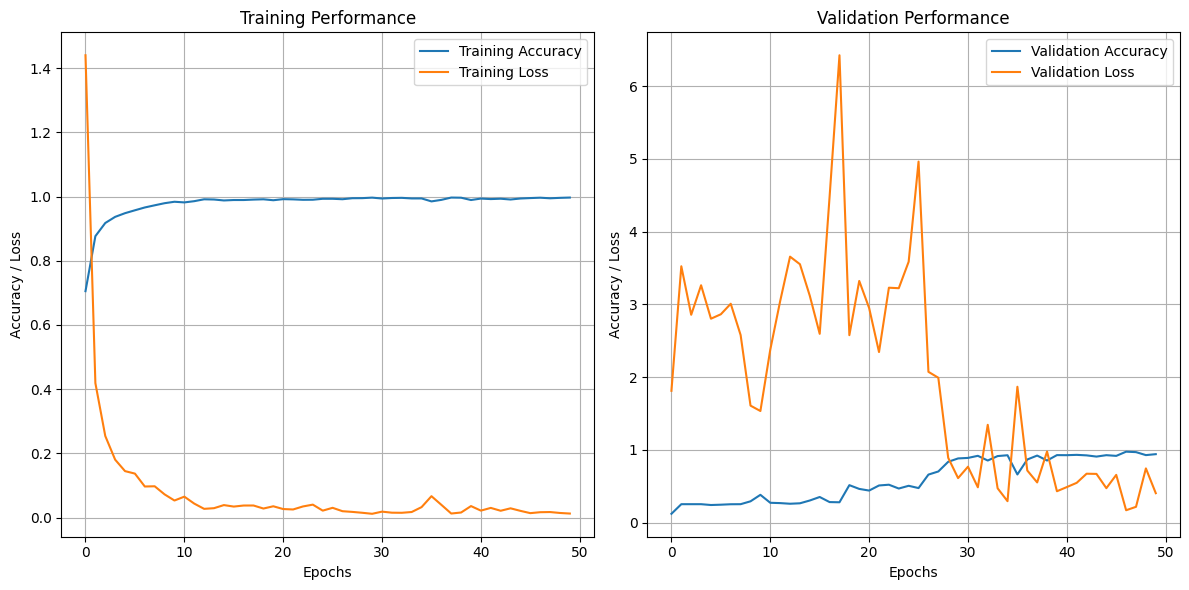

 1/36 [..............................] - ETA: 9s - loss: 0.1056 - accuracy: 0.9688

 3/36 [=>............................] - ETA: 3s - loss: 0.1296 - accuracy: 0.9688

 4/36 [==>...........................] - ETA: 3s - loss: 0.1733 - accuracy: 0.9609

 5/36 [===>..........................] - ETA: 3s - loss: 0.3285 - accuracy: 0.9563

 7/36 [====>.........................] - ETA: 3s - loss: 0.2451 - accuracy: 0.9643

 8/36 [=====>........................] - ETA: 3s - loss: 0.2144 - accuracy: 0.9688

10/36 [=======>......................] - ETA: 2s - loss: 0.3195 - accuracy: 0.9563

11/36 [========>.....................] - ETA: 2s - loss: 0.2995 - accuracy: 0.9574

13/36 [=========>....................] - ETA: 2s - loss: 0.3161 - accuracy: 0.9543

14/36 [==========>...................] - ETA: 2s - loss: 0.3031 - accuracy: 0.9554

16/36 [============>.................] - ETA: 2s - loss: 0.3692 - accuracy: 0.9531

17/36 [=============>................] - ETA: 2s - loss: 0.3761 - accuracy: 0.9540

19/36 [==============>...............] - ETA: 1s - loss: 0.3823 - accuracy: 0.9523

20/36 [===============>..............] - ETA: 1s - loss: 0.3924 - accuracy: 0.9516

22/36 [=================>............] - ETA: 1s - loss: 0.3685 - accuracy: 0.9531

23/36 [==================>...........] - ETA: 1s - loss: 0.3848 - accuracy: 0.9511

25/36 [===================>..........] - ETA: 1s - loss: 0.3771 - accuracy: 0.9500

26/36 [====================>.........] - ETA: 1s - loss: 0.3966 - accuracy: 0.9483

28/36 [======================>.......] - ETA: 0s - loss: 0.4075 - accuracy: 0.9487

29/36 [=======================>......] - ETA: 0s - loss: 0.4005 - accuracy: 0.9461

31/36 [========================>.....] - ETA: 0s - loss: 0.4090 - accuracy: 0.9456

32/36 [=========================>....] - ETA: 0s - loss: 0.4161 - accuracy: 0.9414

34/36 [===========================>..] - ETA: 0s - loss: 0.4081 - accuracy: 0.9421

35/36 [============================>.] - ETA: 0s - loss: 0.4040 - accuracy: 0.9429

36/36 [==============================] - 4s 107ms/step - loss: 0.4057 - accuracy: 0.9423


Validation Loss: 0.40567925572395325
Validation Accuracy: 0.9422572255134583


In [8]:
# Training Graph: Accuracy and Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.title('Training Performance')
plt.legend()
plt.grid(True)

# Validation Graph: Accuracy and Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.title('Validation Performance')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

# Evaluate the model on the validation (split) set
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 1s 636ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


Predicted label: glioma
Predicted label: meningioma
Predicted label: notumor
Predicted label: pituitary


 1/41 [..............................] - ETA: 6s - loss: 0.1842 - accuracy: 0.9375

 2/41 [>.............................] - ETA: 5s - loss: 0.1406 - accuracy: 0.9219

 3/41 [=>............................] - ETA: 5s - loss: 0.1095 - accuracy: 0.9375

 5/41 [==>...........................] - ETA: 4s - loss: 0.0917 - accuracy: 0.9563

 6/41 [===>..........................] - ETA: 4s - loss: 0.0765 - accuracy: 0.9635

 8/41 [====>.........................] - ETA: 3s - loss: 0.3160 - accuracy: 0.9375

 9/41 [=====>........................] - ETA: 3s - loss: 0.6468 - accuracy: 0.9062

11/41 [=======>......................] - ETA: 3s - loss: 0.6538 - accuracy: 0.9119

12/41 [=======>......................] - ETA: 3s - loss: 0.6820 - accuracy: 0.9089

14/41 [=========>....................] - ETA: 2s - loss: 0.6790 - accuracy: 0.9085

15/41 [=========>....................] - ETA: 2s - loss: 0.6456 - accuracy: 0.9125

17/41 [===========>..................] - ETA: 2s - loss: 0.6117 - accuracy: 0.9173

18/41 [============>.................] - ETA: 2s - loss: 0.6177 - accuracy: 0.9149

20/41 [=============>................] - ETA: 2s - loss: 0.6260 - accuracy: 0.9172

21/41 [==============>...............] - ETA: 2s - loss: 0.5963 - accuracy: 0.9211

23/41 [===============>..............] - ETA: 1s - loss: 0.5446 - accuracy: 0.9280

24/41 [================>.............] - ETA: 1s - loss: 0.5219 - accuracy: 0.9310

26/41 [==================>...........] - ETA: 1s - loss: 0.4818 - accuracy: 0.9363

27/41 [==================>...........] - ETA: 1s - loss: 0.4639 - accuracy: 0.9387

29/41 [====================>.........] - ETA: 1s - loss: 0.4319 - accuracy: 0.9429

30/41 [====================>.........] - ETA: 1s - loss: 0.4175 - accuracy: 0.9448

32/41 [======================>.......] - ETA: 0s - loss: 0.3930 - accuracy: 0.9473

33/41 [=======================>......] - ETA: 0s - loss: 0.3811 - accuracy: 0.9489

35/41 [========================>.....] - ETA: 0s - loss: 0.3593 - accuracy: 0.9518

36/41 [=========================>....] - ETA: 0s - loss: 0.3493 - accuracy: 0.9531

38/41 [==========================>...] - ETA: 0s - loss: 0.3309 - accuracy: 0.9556

39/41 [===========================>..] - ETA: 0s - loss: 0.3224 - accuracy: 0.9567

41/41 [==============================] - ETA: 0s - loss: 0.3069 - accuracy: 0.9588

41/41 [==============================] - 5s 109ms/step - loss: 0.3069 - accuracy: 0.9588


Testing Loss: 0.3069349229335785
Testing Accuracy: 0.9588100910186768


 1/41 [..............................] - ETA: 2s

 2/41 [>.............................] - ETA: 4s

 3/41 [=>............................] - ETA: 4s

 5/41 [==>...........................] - ETA: 3s

 6/41 [===>..........................] - ETA: 4s

 8/41 [====>.........................] - ETA: 3s

 9/41 [=====>........................] - ETA: 3s

11/41 [=======>......................] - ETA: 3s

12/41 [=======>......................] - ETA: 3s

14/41 [=========>....................] - ETA: 2s

15/41 [=========>....................] - ETA: 2s

17/41 [===========>..................] - ETA: 2s

19/41 [============>.................] - ETA: 2s

20/41 [=============>................] - ETA: 2s

22/41 [===============>..............] - ETA: 1s

23/41 [===============>..............] - ETA: 1s

24/41 [================>.............] - ETA: 1s

26/41 [==================>...........] - ETA: 1s

28/41 [===================>..........] - ETA: 1s

29/41 [====================>.........] - ETA: 1s

31/41 [=====================>........] - ETA: 1s

32/41 [======================>.......] - ETA: 0s

34/41 [=======================>......] - ETA: 0s

35/41 [========================>.....] - ETA: 0s

37/41 [==========================>...] - ETA: 0s

38/41 [==========================>...] - ETA: 0s

40/41 [============================>.] - ETA: 0s

41/41 [==============================] - ETA: 0s

41/41 [==============================] - 4s 106ms/step


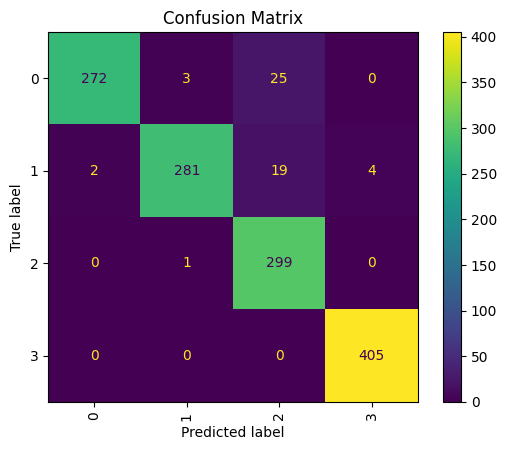

In [9]:
def test_image(model, image_path):
    # Load and preprocess the input image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Resize to match training input size
    img = img.astype('float32') / 255.0  # Normalize
    img = np.repeat(img, 3, axis=-1)  # Convert grayscale to RGB
    img = img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 3)  # Add batch dimension
    
    # Predict the class
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)  # Get the class index with the highest probability

    # Return the predicted label
    predicted_label = class_labels_reverse[predicted_class[0]]  # Map the class index to label
    return predicted_label

test_image_path1 = os.path.join(os.environ['DATASET_PATH'], 'Testing/glioma/Te-gl_0010.jpg')
test_image_path2 = os.path.join(os.environ['DATASET_PATH'], 'Testing/meningioma/Te-me_0018.jpg')
test_image_path3 = os.path.join(os.environ['DATASET_PATH'], 'Testing/notumor/Te-no_0027.jpg')
test_image_path4 = os.path.join(os.environ['DATASET_PATH'], 'Testing/pituitary/Te-pi_0094.jpg')

predicted_label1 = test_image(model, test_image_path1)
predicted_label2 = test_image(model, test_image_path2)
predicted_label3 = test_image(model, test_image_path3)
predicted_label4 = test_image(model, test_image_path4)

print(f"Predicted label: {predicted_label1}")
print(f"Predicted label: {predicted_label2}")
print(f"Predicted label: {predicted_label3}")
print(f"Predicted label: {predicted_label4}")

# Load the testing dataset
testing_dataset_path = os.path.join(os.environ['DATASET_PATH'], 'Testing')

test_images = []
test_labels = []

# Loop over the folders in the Testing dataset to load images and their labels
for folder in image_folders:
    folder_path = os.path.join(testing_dataset_path, folder)
    
    # List image files in the folder
    image_files = sorted(os.listdir(folder_path))

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)

        # Read the image (grayscale because MRI data)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Resize image if necessary (standardize image size)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Resize to 224x224 or any size you prefer

        # Append image and label (use list append method)
        test_images.append(img)
        test_labels.append(class_labels[folder])  # Assign label based on folder name

# Convert lists to numpy arrays after appending all images and labels
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Normalize the test images
test_images = test_images.astype('float32') / 255.0

# Convert images to 3 channels (grayscale to RGB) for ResNet50
test_X_rgb = np.repeat(test_images.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1), 3, axis=-1)

# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(test_X_rgb, test_labels)
print(f"Testing Loss: {test_loss}")
print(f"Testing Accuracy: {test_acc}")

# Generate predictions for the test dataset
predicted_probs = model.predict(test_X_rgb)
predicted_classes = np.argmax(predicted_probs, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_classes, labels=range(len(class_labels)))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(class_labels.values()))
disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d')

plt.title("Confusion Matrix")
plt.show()